# Sequencial NN

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,InputLayer,Dropout
from keras.layers import LSTM
from config.config import *
from config.constants import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import os
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
def plot_model(hist):
    fig, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)    

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy', fontsize=14)
    axs.set_xlabel('Epoch', fontsize=14)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print("Model has training accuracy of {:.2f}%".format(hist.history['accuracy'][-1]*100))

In [4]:
def pre_process_split(path):
    
    dataset = pd.read_csv(path)
    dataset.dropna(inplace = True)
    
    # assigning new column names to the dataframe
    # dataset.columns = constants.cols + ['label']
    
    # creating training set ignoring labels
    train_data = dataset[dataset.columns[:-1]].values
    #scaler = StandardScaler()    
    #train_data = scaler.fit_transform(train_data)

    labels = dataset['label'].values
    n_class = len(set(labels))
    
    X_train, X_test, y_train, y_test =   train_test_split(train_data, labels, test_size=0.20)

    X_train = X_train.reshape(-1, 1, train_data.shape[1])
    X_test  = X_test.reshape(-1, 1, train_data.shape[1])
    y_train = y_train.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    
    return X_train, X_test, y_train, y_test, n_class

In [5]:
def model_config_train(name,eps,bs,actvn,datalink):
    
    print("processing dataset")
    X_train, X_test, y_train, y_test, n_class = pre_process_split(datalink)
    
    print(n_class)
    model = Sequential()
    model.add(LSTM(200,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(n_class, activation=actvn))
    print(model.summary())
       
    chk = ModelCheckpoint(name+'.pkl',save_best_only=True, mode='auto', verbose=1)
    print("saving as:",name+'.pkl')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=eps, batch_size=bs, callbacks=[chk], validation_split=0.2)    
    plot_model(hist)
    
    return model

## Loading dataset for binary classifier

In [12]:
def plotter(plot_data,unique_labels,n_plots,save=False):
    
    data = plot_data.copy()
    predicted_labels = data['label']
    #print(len(set(predicted_labels)),unique_labels)
    #print(Counter(predicted_labels).values(),[unique_labels[each] for each in Counter(predicted_labels).keys()])
    
    matrics = sorted(zip([unique_labels[each] for each in Counter(predicted_labels).keys()],Counter(predicted_labels).values() ), key=lambda x: x[1])
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    score = [list(j) for j in matrics][::-1]
    
    
    
    total = sum([i[1] for i in score])

    c=0
    for i in score:

        score[c][1] = str(round(i[1]*100/total,2))+"%"
        #print("Fault type:", i[-1], "Percentage: {:.2f}%".format(i[1]*100/total))
        c+=1

    print(pd.DataFrame.from_records(score,columns=['Fault type','Percentage']))
    
    #print("changing numbers to labels again")
    data['label'] = [unique_labels[i] for i in predicted_labels]

    fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))

    for j in range(n_plots):

        legend_list = []
        available_labels = [each[0] for each in score ]
        
        for i in range(len(available_labels)):

            extract = data[data.label==available_labels[i]][cols[j]]    

            if len(unique_labels)==2:
                
                if available_labels[i]=='FAULT':
                    temp = ax[j].scatter(extract.index,extract,marker='+',s=40) 
                elif available_labels[i]=='NML':
                    temp = ax[j].scatter(extract.index,extract,marker='.',s=10) 
            else:
                #print(available_labels[i],score[i][0],score[i][1])
                if available_labels[i]==score[0][0]:
                    temp = ax[j].scatter(extract.index,extract,marker='+',s=40)
                else:
                    temp = ax[j].scatter(extract.index,extract,marker='.',s=10)


            legend_list.append(temp)

        ax[j].legend(legend_list,available_labels,scatterpoints=3,ncol=1,fontsize=15)

    fig.tight_layout()
    if save:
        plt.savefig('results.png')
    plt.show()

    return score[0][0]

In [7]:
def tester(model,frame):
    
    data = frame
    
    
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    
    if data.shape[1]==6:
        data.columns = cols
    elif data.shape[1]==7:
        data.columns = cols + ['label']
        data = data[cols]
    elif data.shape[1]==3:
        data.columns = cols[:3]
    elif data.shape[1]==4:
        data.columns = cols[:3]+['label']
        
    else:
        print("columns length is ",data.shape[1])
    
    #test_preds = model.predict(data)
    if frame.shape[1]<=4:
        tup = 3
    elif frame.shape[1]>=6:
        tup = 6
    test_preds = model.predict(data.values.reshape(-1,1,tup).tolist())
    predicted_labels = np.argmax(test_preds,axis=1)
    
    data['label'] = predicted_labels
    
    return data
    

## Testing the models

processing dataset
2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               163200    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 163,602
Trainable params: 163,602
Non-trainable params: 0
_________________________________________________________________
None
saving as: new_binary_clf.pkl
Epoch 1/10
640/640 [==============================] - 21s 23ms/step - loss: 0.3390 - accuracy: 0.8867 - val_loss: 0.1769 - val_accuracy: 0.9433

Epoch 00001: val_loss improved from inf to 0.17695, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 2/10
640/640 [==============================] - 14s 22ms/step - loss: 0.1731 - accuracy: 0.9436 - val_loss: 0.1680 - val_accuracy: 0.9438

Epoch 00002: val_loss improved from 0.17695 to 0.16796, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 3/10
640/640 [==============================] - 14s 22ms/step - loss: 0.1627 - accuracy: 0.9445 - val_loss: 0.1530 - val_accuracy: 0.9551

Epoch 00003: val_loss improved from 0.16796 to 0.15304, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 4/10
640/640 [==============================] - 15s 24ms/step - loss: 0.1471 - accuracy: 0.9553 - val_loss: 0.1381 - val_accuracy: 0.9557

Epoch 00004: val_loss improved from 0.15304 to 0.13812, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 5/10
640/640 [==============================] - 14s 23ms/step - loss: 0.1343 - accuracy: 0.9570 - val_loss: 0.1298 - val_accuracy: 0.9544

Epoch 00005: val_loss improved from 0.13812 to 0.12978, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 6/10
640/640 [==============================] - 14s 22ms/step - loss: 0.1259 - accuracy: 0.9598 - val_loss: 0.1251 - val_accuracy: 0.9576

Epoch 00006: val_loss improved from 0.12978 to 0.12508, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 7/10
640/640 [==============================] - 15s 23ms/step - loss: 0.1218 - accuracy: 0.9590 - val_loss: 0.1210 - val_accuracy: 0.9584

Epoch 00007: val_loss improved from 0.12508 to 0.12102, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 8/10
640/640 [==============================] - 14s 23ms/step - loss: 0.1188 - accuracy: 0.9578 - val_loss: 0.1195 - val_accuracy: 0.9576

Epoch 00008: val_loss improved from 0.12102 to 0.11947, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 9/10
640/640 [==============================] - 14s 22ms/step - loss: 0.1172 - accuracy: 0.9576 - val_loss: 0.1177 - val_accuracy: 0.9566

Epoch 00009: val_loss improved from 0.11947 to 0.11766, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


Epoch 10/10
640/640 [==============================] - 14s 22ms/step - loss: 0.1156 - accuracy: 0.9584 - val_loss: 0.1176 - val_accuracy: 0.9569

Epoch 00010: val_loss improved from 0.11766 to 0.11762, saving model to new_binary_clf.pkl


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: new_binary_clf.pkl/assets


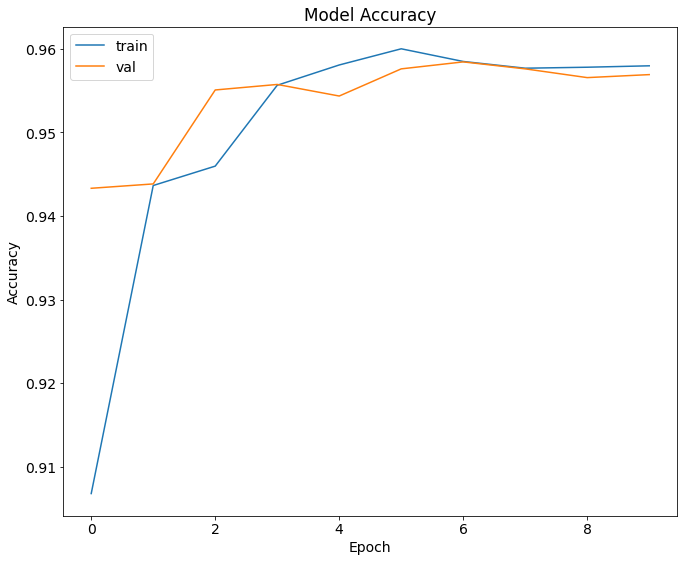

Model has training accuracy of 95.80%


In [28]:
model_config_train('new_binary_clf',10,2000,'softmax','./NewKMTraining/binary/bin_dataset_simulink.csv')

processing dataset
10
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               163200    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2010      
Total params: 165,210
Trainable params: 165,210
Non-trainable params: 0
_________________________________________________________________
None
saving as: new_multi_clf.pkl
Epoch 1/20
78/78 [==============================] - 4s 31ms/step - loss: 2.2194 - accuracy: 0.2117 - val_loss: 1.9030 - val_accuracy: 0.4052

Epoch 00001: val_loss improved from inf to 1.90302, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 2/20
78/78 [==============================] - 2s 25ms/step - loss: 1.7378 - accuracy: 0.6006 - val_loss: 1.2080 - val_accuracy: 0.7526

Epoch 00002: val_loss improved from 1.90302 to 1.20799, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 3/20
78/78 [==============================] - 2s 24ms/step - loss: 1.0665 - accuracy: 0.7617 - val_loss: 0.7242 - val_accuracy: 0.8377

Epoch 00003: val_loss improved from 1.20799 to 0.72423, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 4/20
78/78 [==============================] - 2s 24ms/step - loss: 0.6541 - accuracy: 0.8501 - val_loss: 0.4904 - val_accuracy: 0.8774

Epoch 00004: val_loss improved from 0.72423 to 0.49044, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 5/20
78/78 [==============================] - 2s 24ms/step - loss: 0.4589 - accuracy: 0.8804 - val_loss: 0.3715 - val_accuracy: 0.9080

Epoch 00005: val_loss improved from 0.49044 to 0.37151, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 6/20
78/78 [==============================] - 2s 24ms/step - loss: 0.3565 - accuracy: 0.9080 - val_loss: 0.3089 - val_accuracy: 0.9159

Epoch 00006: val_loss improved from 0.37151 to 0.30890, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 7/20
78/78 [==============================] - 2s 23ms/step - loss: 0.3024 - accuracy: 0.9145 - val_loss: 0.2730 - val_accuracy: 0.9160

Epoch 00007: val_loss improved from 0.30890 to 0.27300, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 8/20
78/78 [==============================] - 2s 25ms/step - loss: 0.2706 - accuracy: 0.9142 - val_loss: 0.2495 - val_accuracy: 0.9167

Epoch 00008: val_loss improved from 0.27300 to 0.24953, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 9/20
78/78 [==============================] - 2s 24ms/step - loss: 0.2471 - accuracy: 0.9152 - val_loss: 0.2327 - val_accuracy: 0.9166

Epoch 00009: val_loss improved from 0.24953 to 0.23267, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 10/20
78/78 [==============================] - 2s 25ms/step - loss: 0.2325 - accuracy: 0.9152 - val_loss: 0.2188 - val_accuracy: 0.9175

Epoch 00010: val_loss improved from 0.23267 to 0.21880, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 11/20
78/78 [==============================] - 2s 24ms/step - loss: 0.2183 - accuracy: 0.9165 - val_loss: 0.2081 - val_accuracy: 0.9186

Epoch 00011: val_loss improved from 0.21880 to 0.20810, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 12/20
78/78 [==============================] - 2s 26ms/step - loss: 0.2085 - accuracy: 0.9173 - val_loss: 0.1998 - val_accuracy: 0.9211

Epoch 00012: val_loss improved from 0.20810 to 0.19978, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 13/20
78/78 [==============================] - 2s 24ms/step - loss: 0.2019 - accuracy: 0.9202 - val_loss: 0.1933 - val_accuracy: 0.9237

Epoch 00013: val_loss improved from 0.19978 to 0.19333, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 14/20
78/78 [==============================] - 2s 25ms/step - loss: 0.1966 - accuracy: 0.9208 - val_loss: 0.1888 - val_accuracy: 0.9236

Epoch 00014: val_loss improved from 0.19333 to 0.18877, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 15/20
78/78 [==============================] - 2s 26ms/step - loss: 0.1909 - accuracy: 0.9215 - val_loss: 0.1838 - val_accuracy: 0.9242

Epoch 00015: val_loss improved from 0.18877 to 0.18382, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 16/20
78/78 [==============================] - 2s 24ms/step - loss: 0.1877 - accuracy: 0.9215 - val_loss: 0.1808 - val_accuracy: 0.9245

Epoch 00016: val_loss improved from 0.18382 to 0.18076, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 17/20
78/78 [==============================] - 2s 25ms/step - loss: 0.1861 - accuracy: 0.9213 - val_loss: 0.1783 - val_accuracy: 0.9242

Epoch 00017: val_loss improved from 0.18076 to 0.17829, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 18/20
78/78 [==============================] - 2s 25ms/step - loss: 0.1813 - accuracy: 0.9221 - val_loss: 0.1759 - val_accuracy: 0.9247

Epoch 00018: val_loss improved from 0.17829 to 0.17587, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 19/20
78/78 [==============================] - 2s 24ms/step - loss: 0.1790 - accuracy: 0.9216 - val_loss: 0.1743 - val_accuracy: 0.9249

Epoch 00019: val_loss improved from 0.17587 to 0.17427, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


Epoch 20/20
78/78 [==============================] - 2s 24ms/step - loss: 0.1788 - accuracy: 0.9209 - val_loss: 0.1729 - val_accuracy: 0.9186

Epoch 00020: val_loss improved from 0.17427 to 0.17293, saving model to new_multi_clf.pkl


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: new_multi_clf.pkl/assets


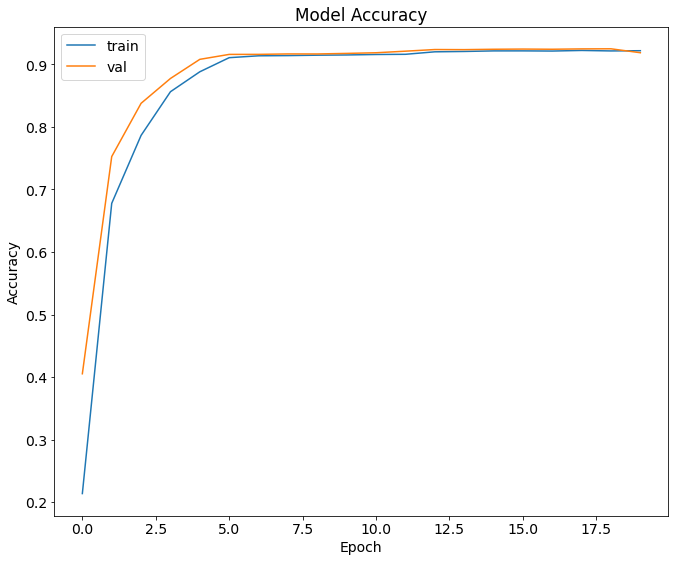

Model has training accuracy of 92.18%


In [29]:
model_config_train('new_multi_clf',20,2000,'softmax','./NewKMTraining/multi/mul_dataset_simulink.csv')

In [8]:
binary_labels_list = ['NML','FAULT']


In [9]:
#multi_labels_list = ['AB', 'AC', 'BC', 'ABC', 'AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']
multi_labels_list = ['AB', 'AC', 'BC','AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']


In [10]:
binary_model = load_model('new_binary_clf.pkl')
multi_model = load_model('new_multi_clf.pkl')

  Fault type Percentage
0        NML      99.0%
1      FAULT      0.99%


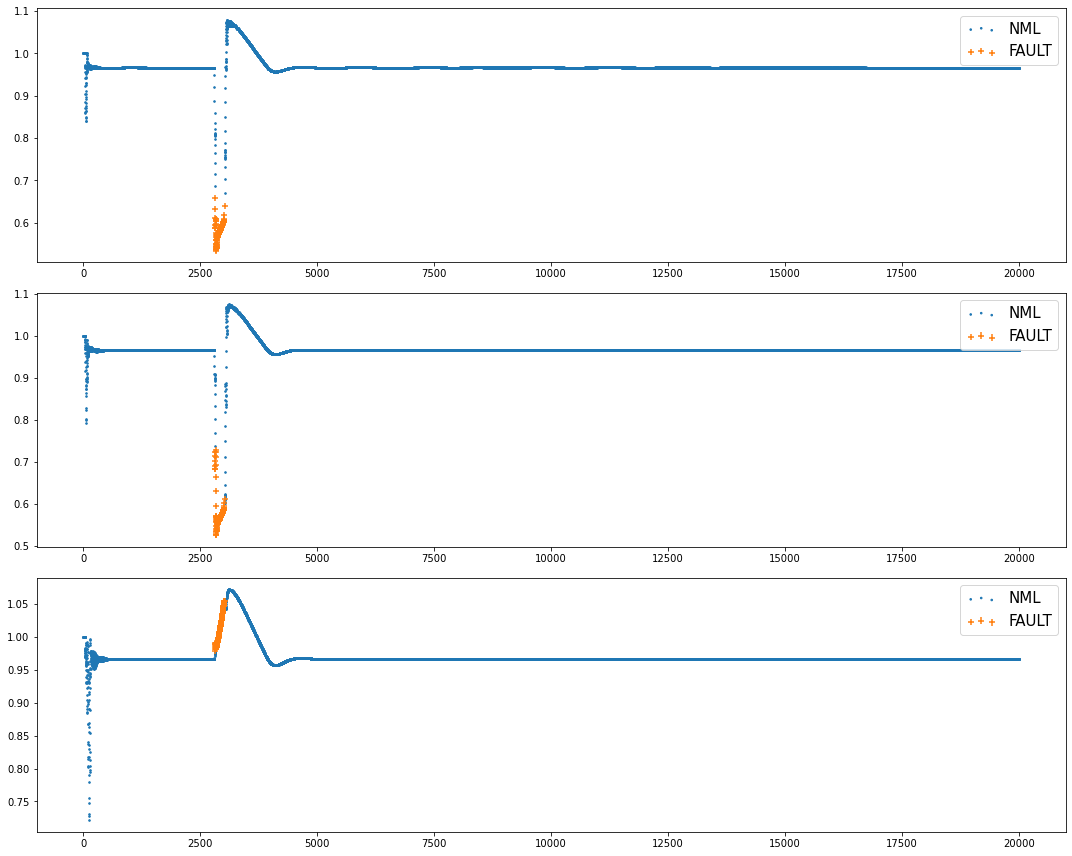

  Fault type Percentage
0         BG     100.0%


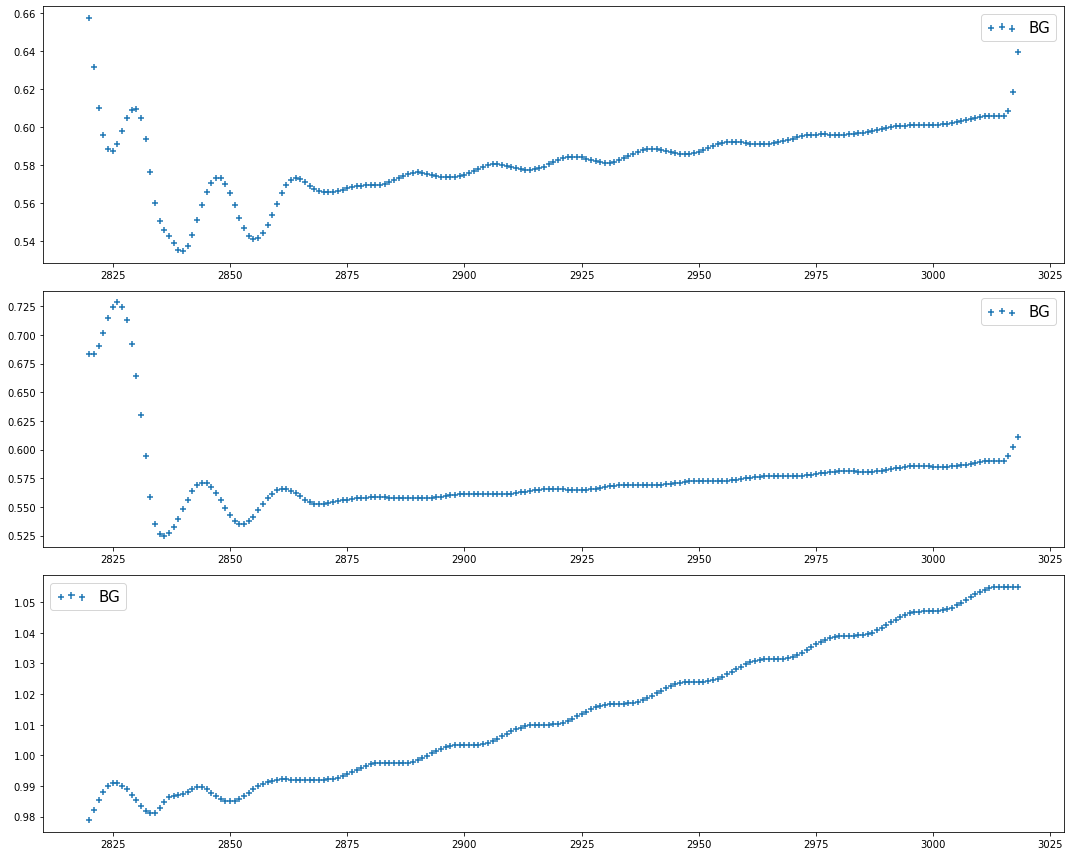

'BG'

In [15]:
dat = pd.read_csv('ml_test.csv')
dat = dat[dat.columns[:3]]
data = tester(binary_model,dat)
plotter(data,binary_labels_list,3)
data = tester(multi_model,data[data.label!=0][data.columns[:3]])
plotter(data,multi_labels_list,3,save=True)


In [38]:
# current directory
path = "./RangeTrainingset/"

# list of file of the given path is assigned to the variable 
file_list = [each for each in list(os.walk(path))[0][-1] if ".csv" in each]


.
.
 5ABCG.csv
  Fault type Percentage
0        NML     96.91%
1      FAULT      3.09%


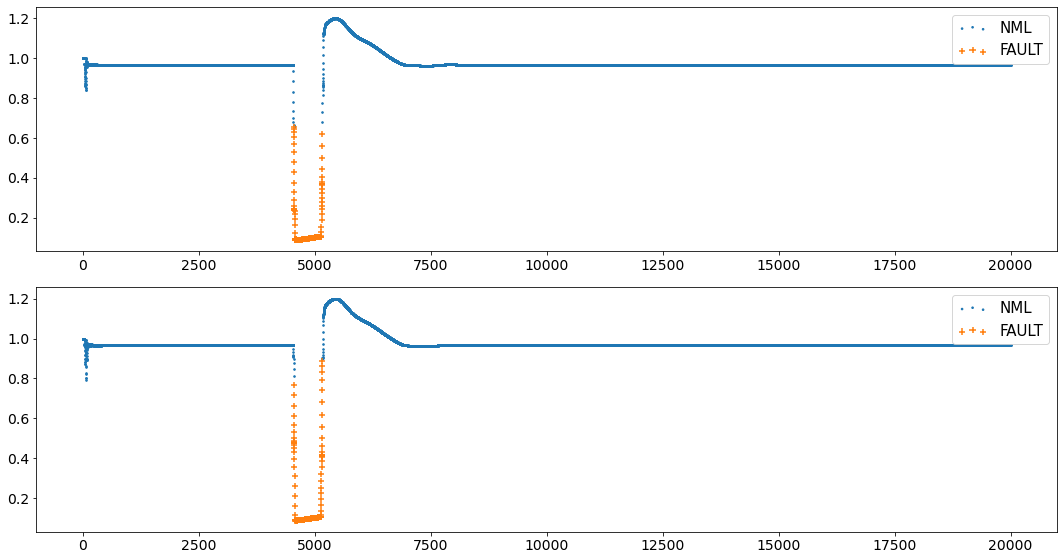

  Fault type Percentage
0       ABCG     96.12%
1        ABG      2.91%
2         AG      0.65%
3        ACG      0.32%


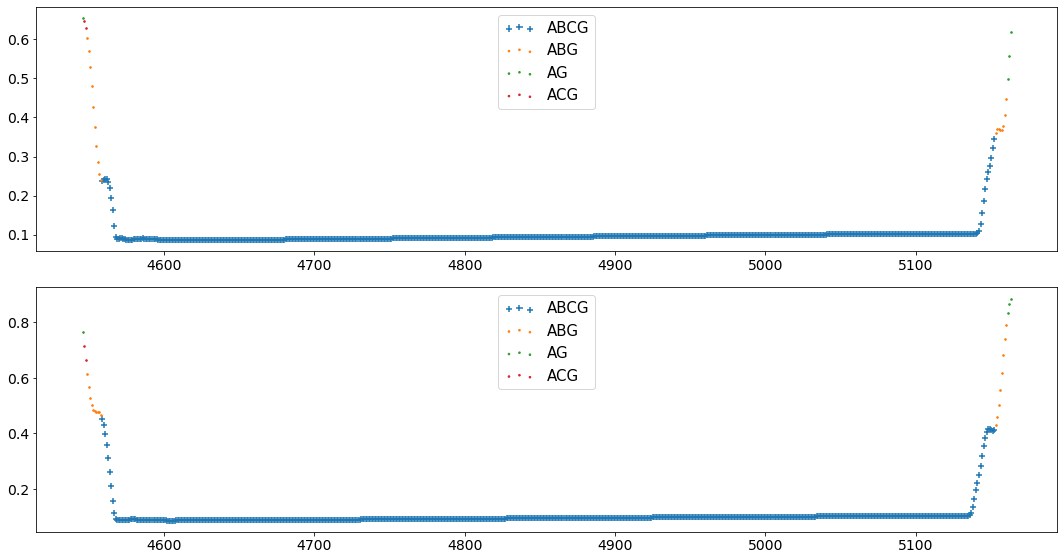


.
.
 10ABG.csv
  Fault type Percentage
0        NML     75.89%
1      FAULT     24.11%


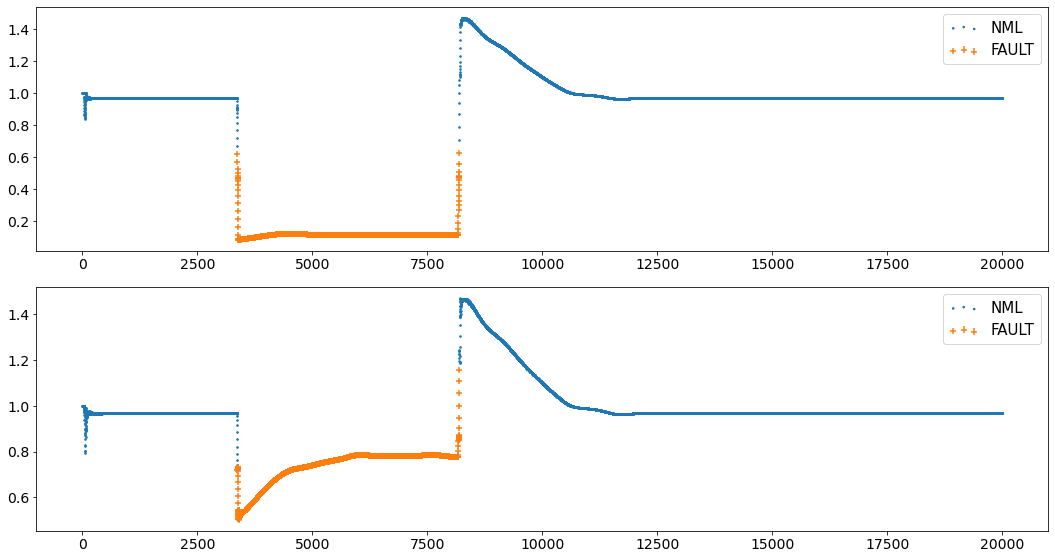

  Fault type Percentage
0        ABG     99.79%
1         AB      0.19%
2         BG      0.02%


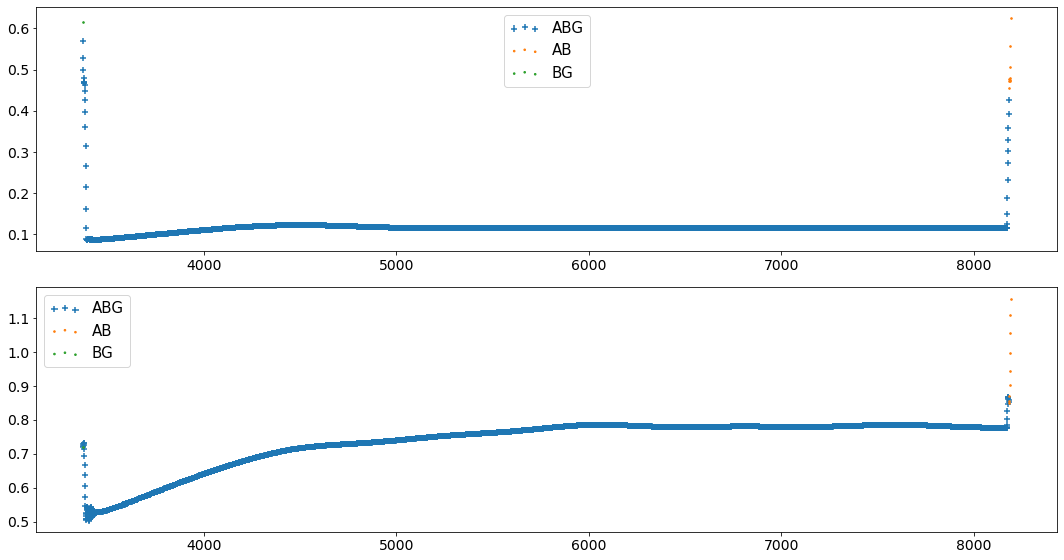


.
.
 3BC.csv
  Fault type Percentage
0        NML     76.65%
1      FAULT     23.35%


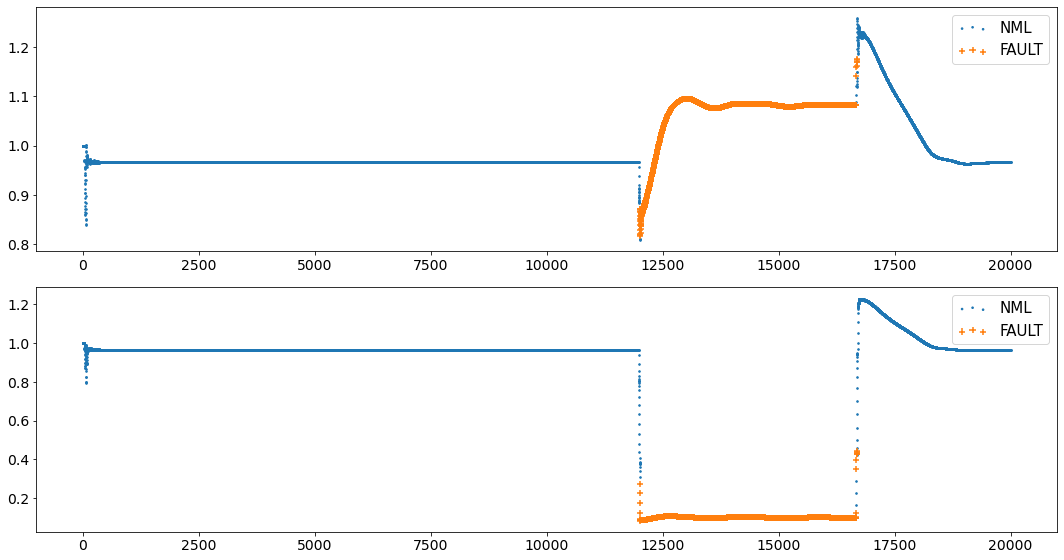

  Fault type Percentage
0         BC     100.0%


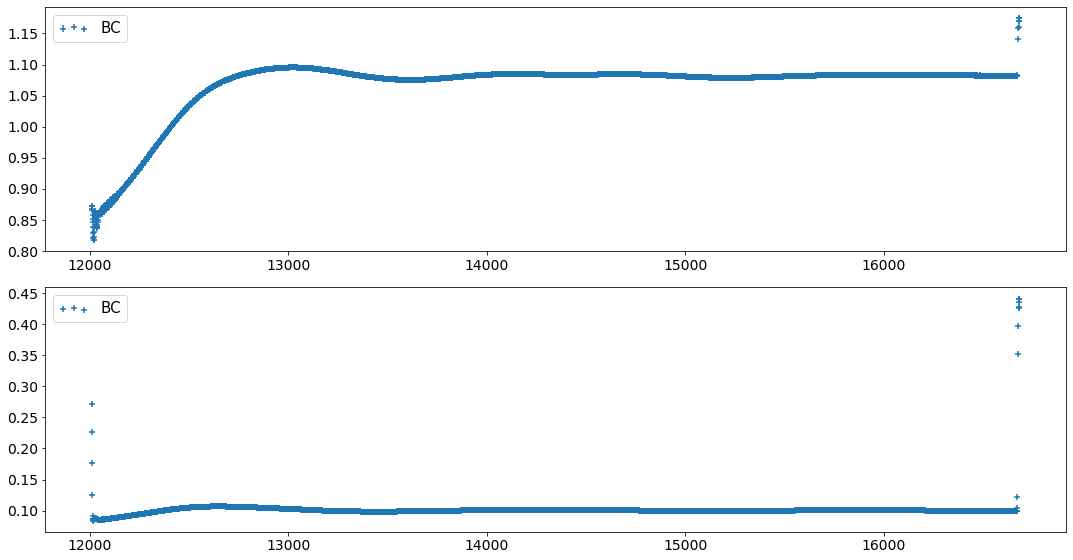


.
.
 3CG.csv
  Fault type Percentage
0        NML     59.85%
1      FAULT     40.15%


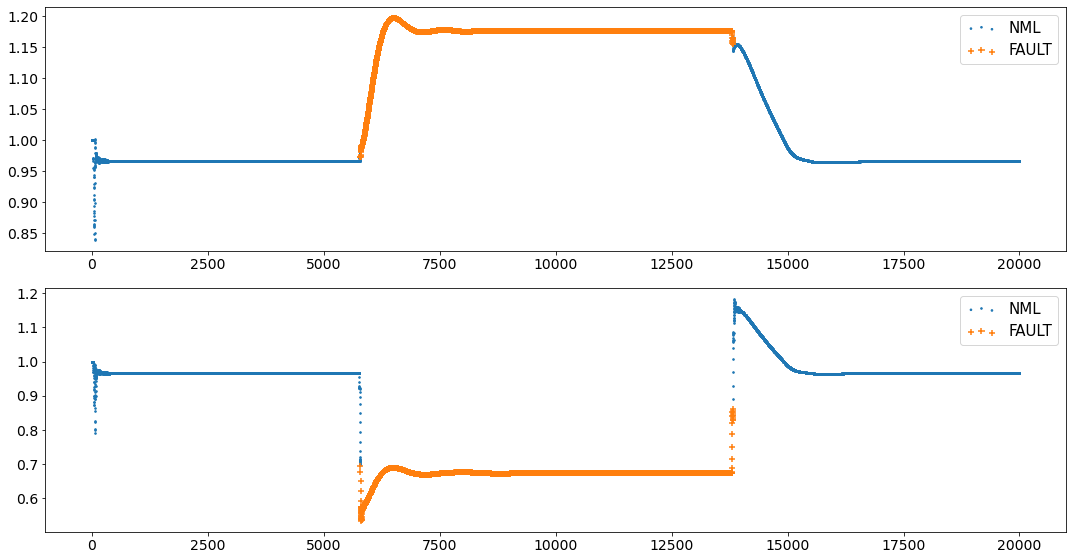

  Fault type Percentage
0         CG     100.0%


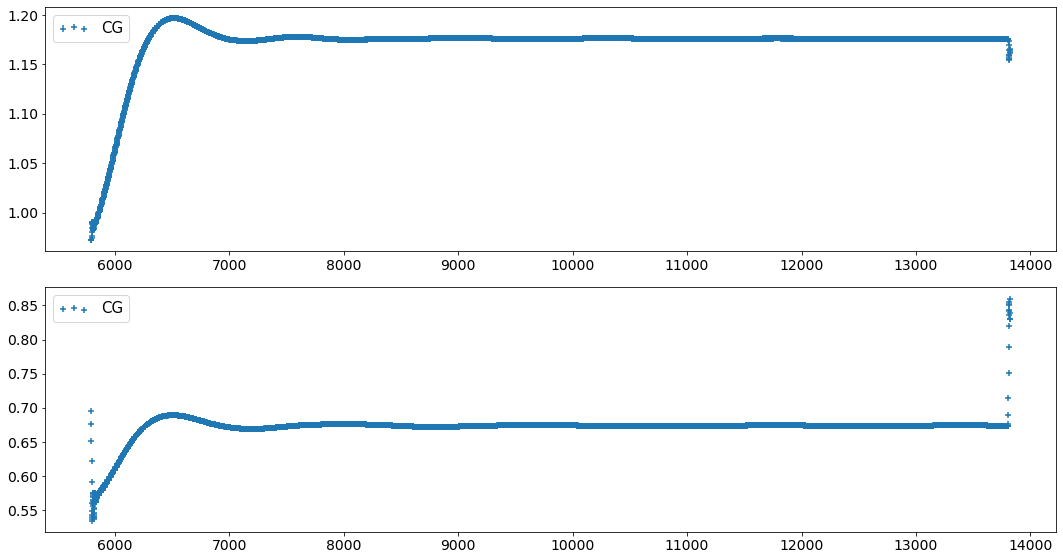


.
.
 1BCG.csv
  Fault type Percentage
0        NML     96.75%
1      FAULT      3.25%


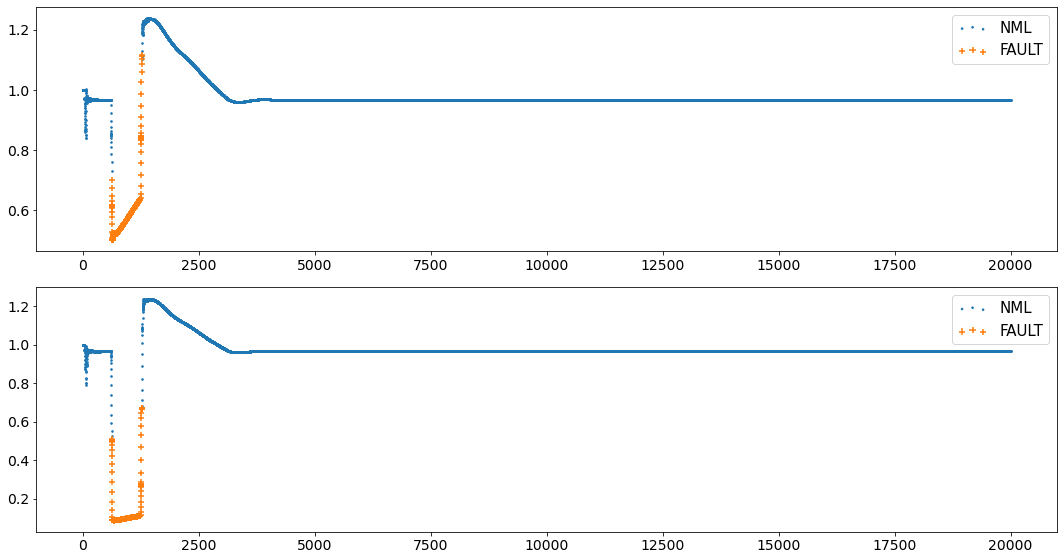

  Fault type Percentage
0        BCG      98.0%
1         CG      1.38%
2         BC      0.61%


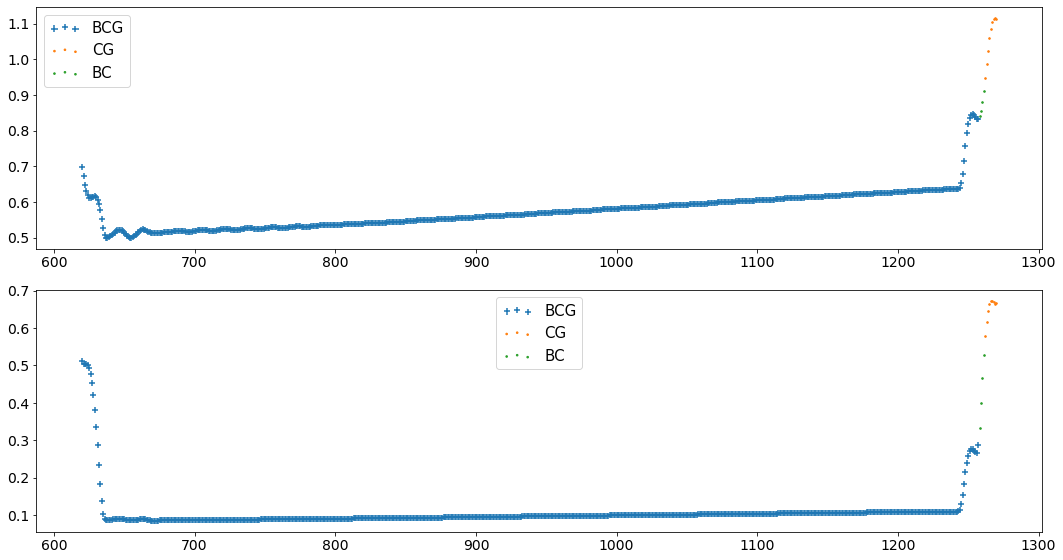


.
.
 7BG.csv
  Fault type Percentage
0        NML     93.12%
1      FAULT      6.88%


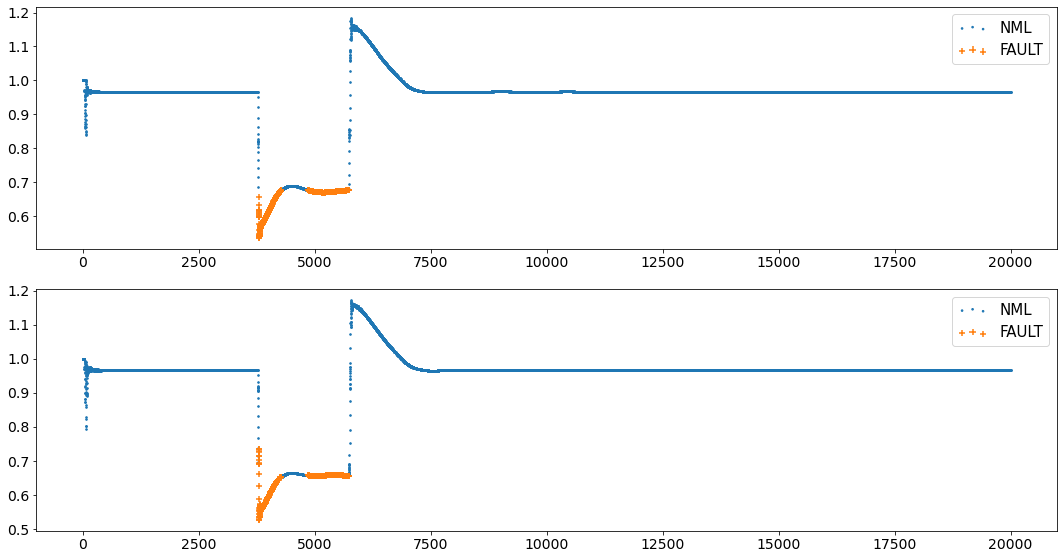

  Fault type Percentage
0         BG     100.0%


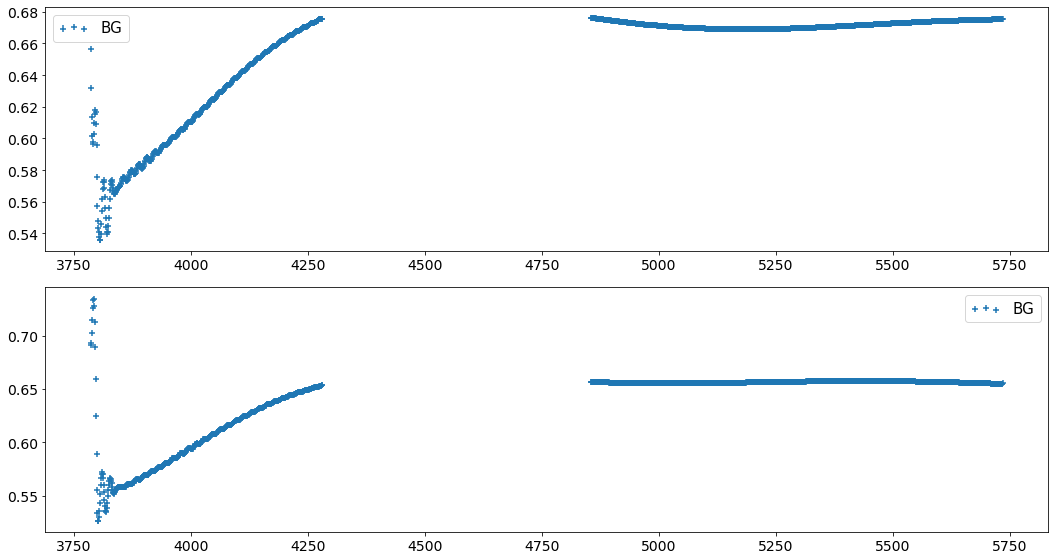


.
.
 5BG.csv
  Fault type Percentage
0        NML      98.5%
1      FAULT       1.5%


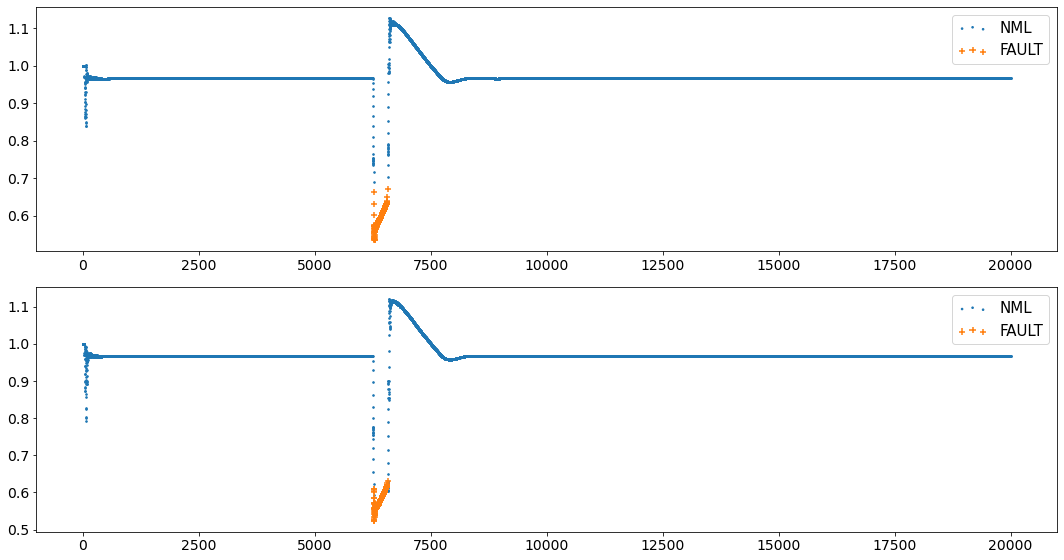

  Fault type Percentage
0         BG     100.0%


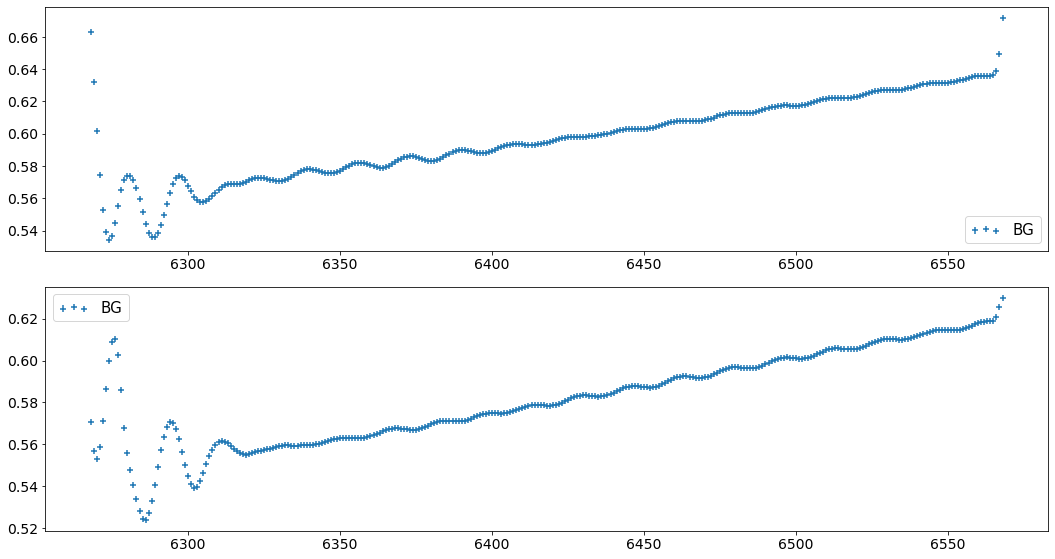


.
.
 9ABG.csv
  Fault type Percentage
0        NML     94.83%
1      FAULT      5.17%


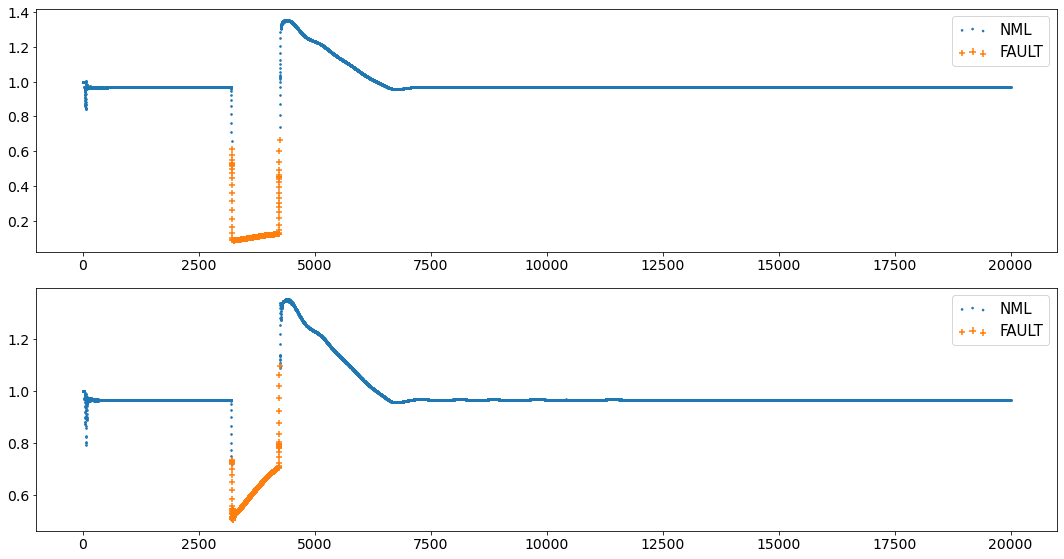

  Fault type Percentage
0        ABG     99.03%
1         AB      0.58%
2         BG      0.29%
3         AG       0.1%


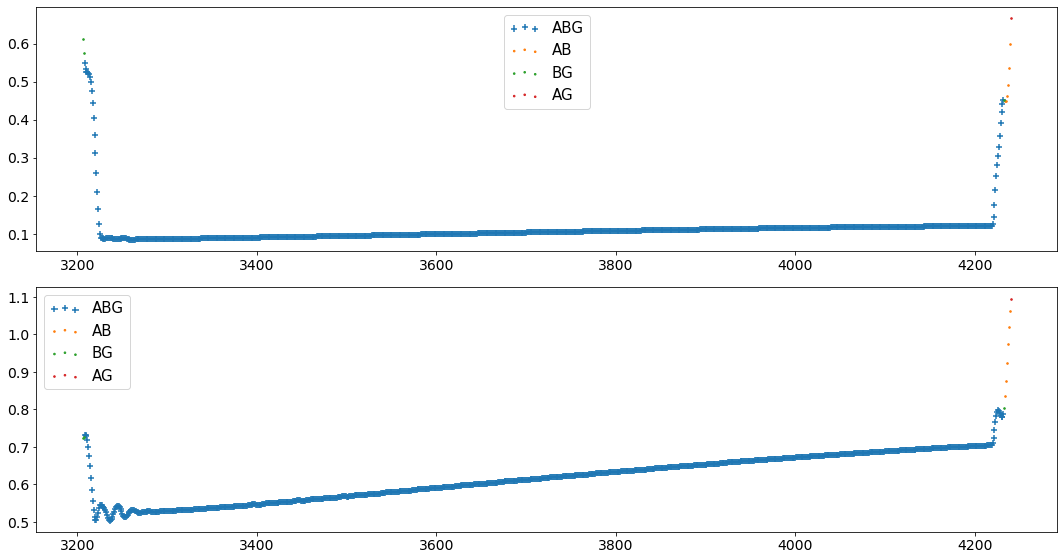


.
.
 1BC.csv
  Fault type Percentage
0        NML     97.44%
1      FAULT      2.56%


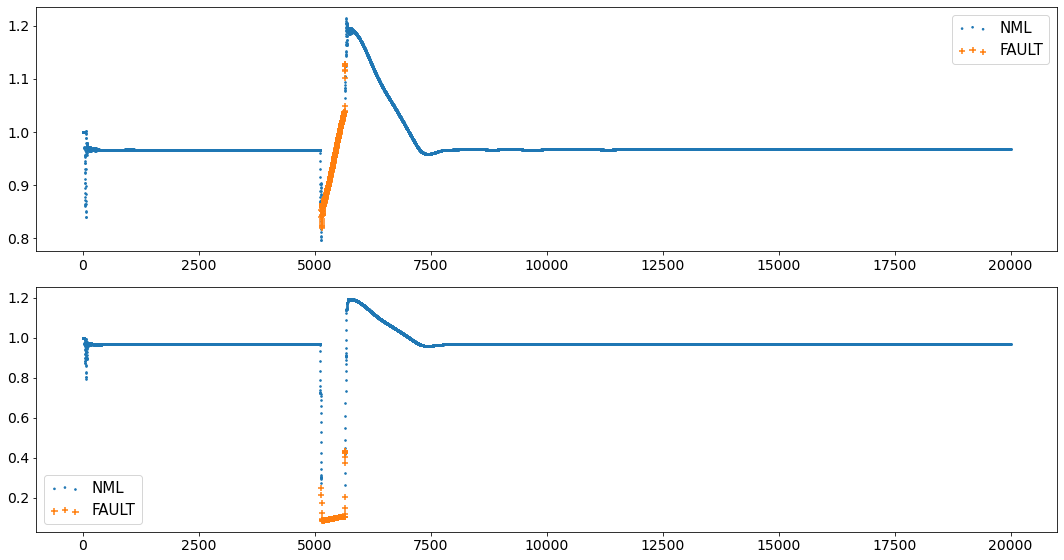

  Fault type Percentage
0         BC     100.0%


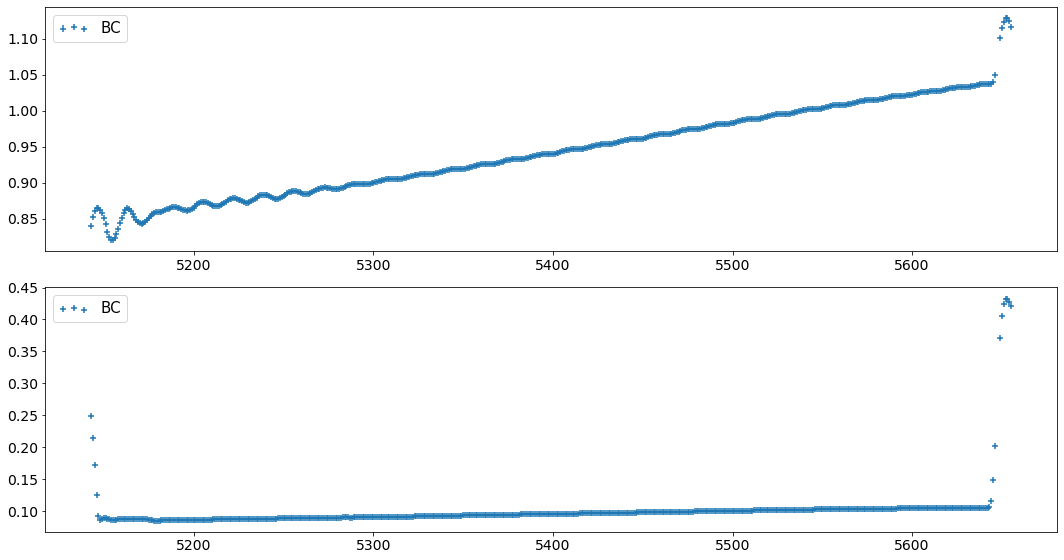


.
.
 1CG.csv
  Fault type Percentage
0        NML     86.05%
1      FAULT     13.96%


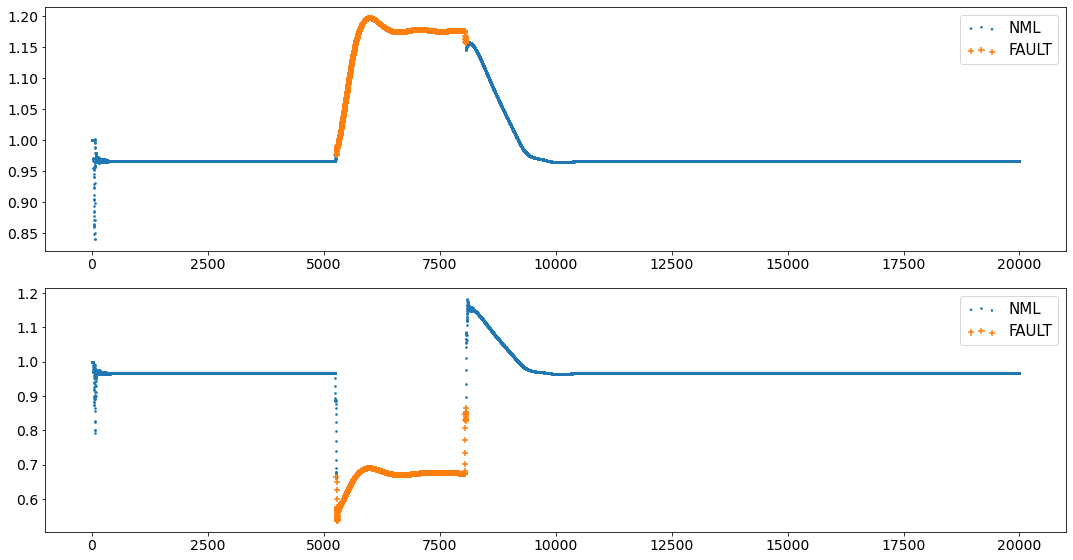

  Fault type Percentage
0         CG     100.0%


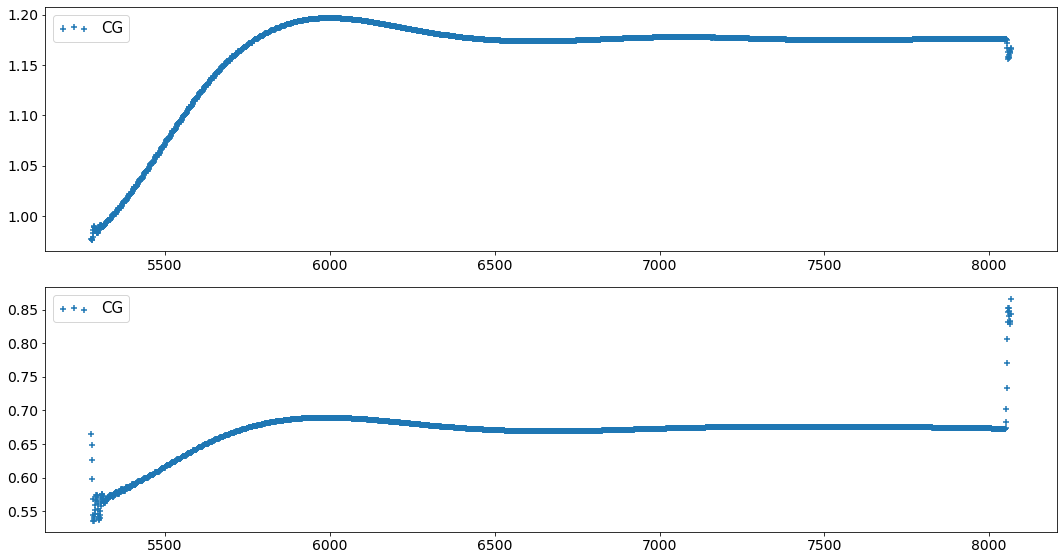


.
.
 5ABG.csv
  Fault type Percentage
0        NML     61.91%
1      FAULT     38.09%


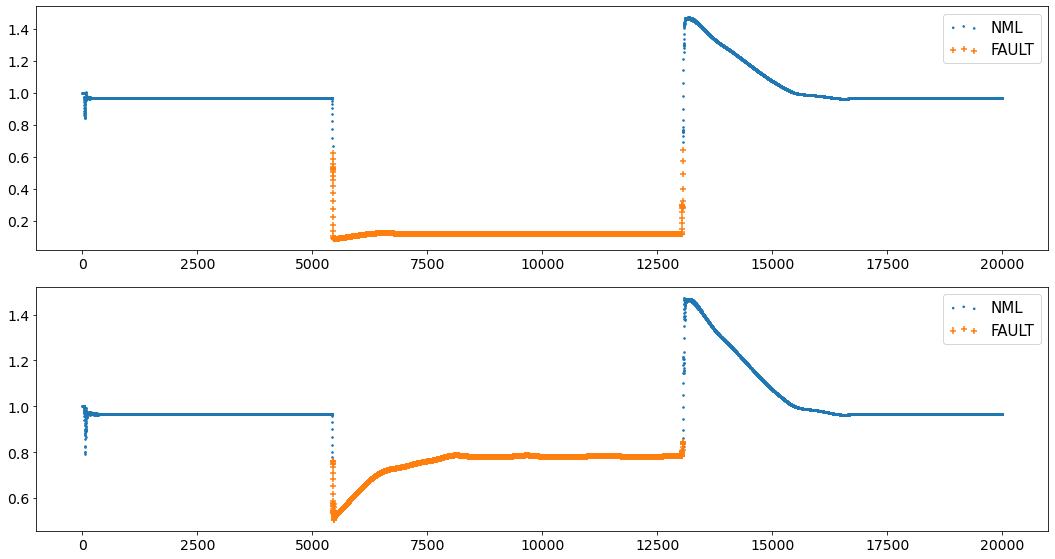

  Fault type Percentage
0        ABG     99.79%
1         AB      0.13%
2         BG      0.08%


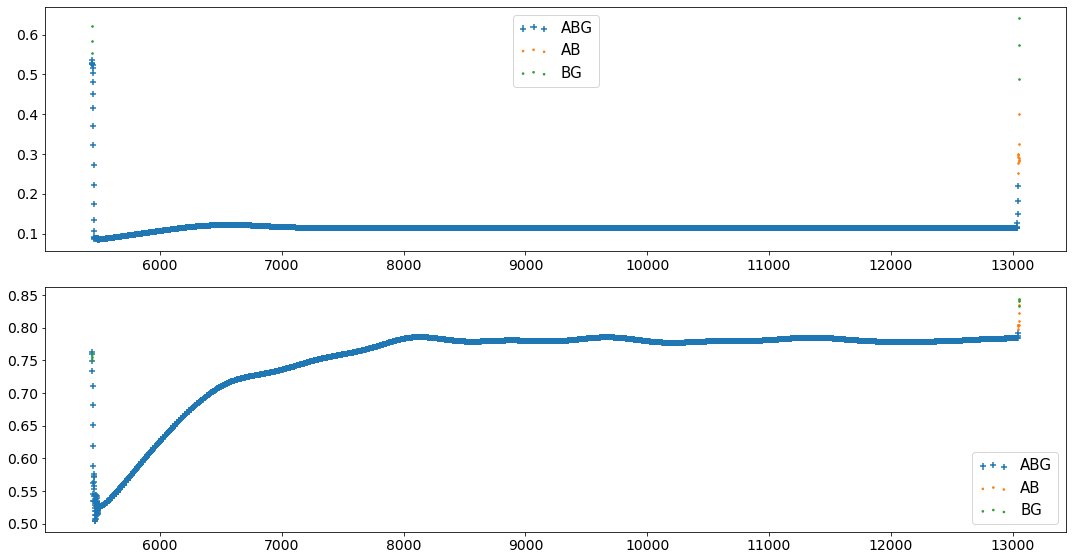


.
.
 9AG.csv
  Fault type Percentage
0        NML      85.5%
1      FAULT      14.5%


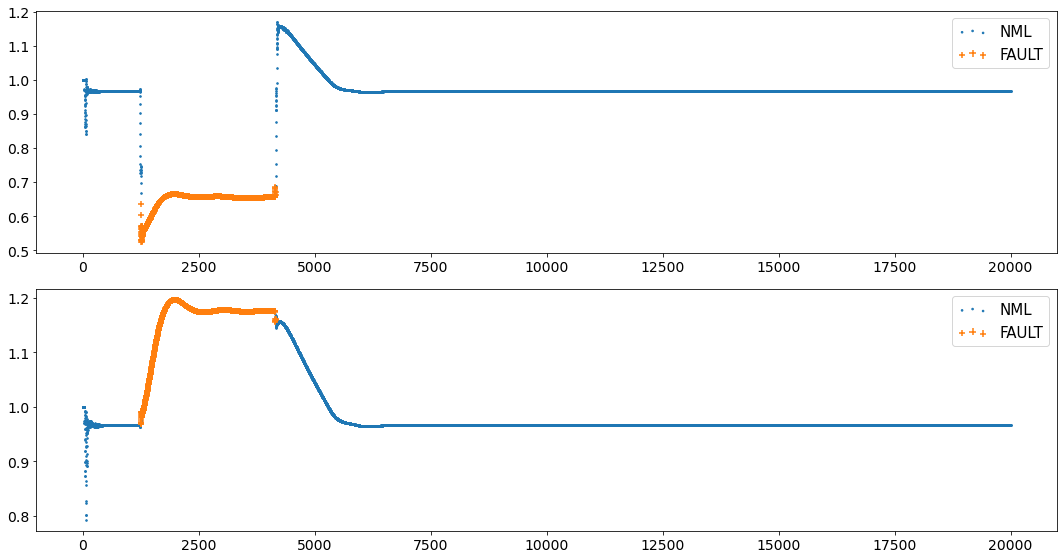

  Fault type Percentage
0         AG     100.0%


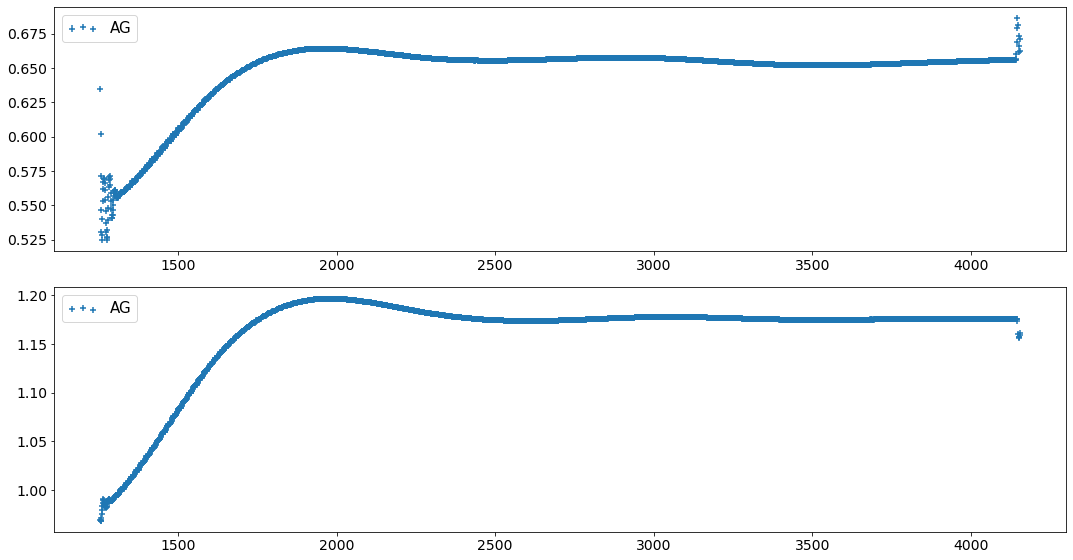


.
.
 7ACG.csv
  Fault type Percentage
0        NML     95.25%
1      FAULT      4.75%


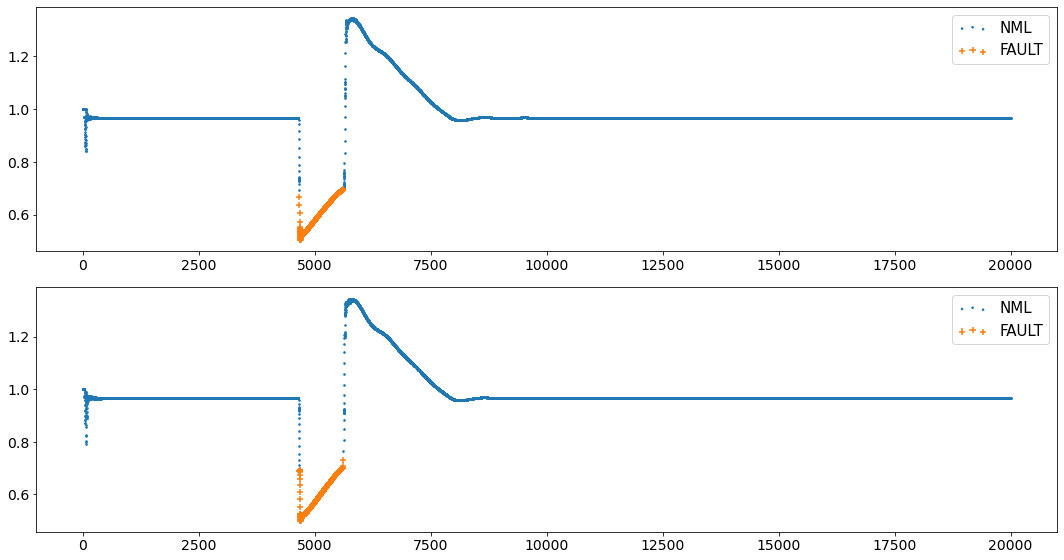

  Fault type Percentage
0        ACG     100.0%


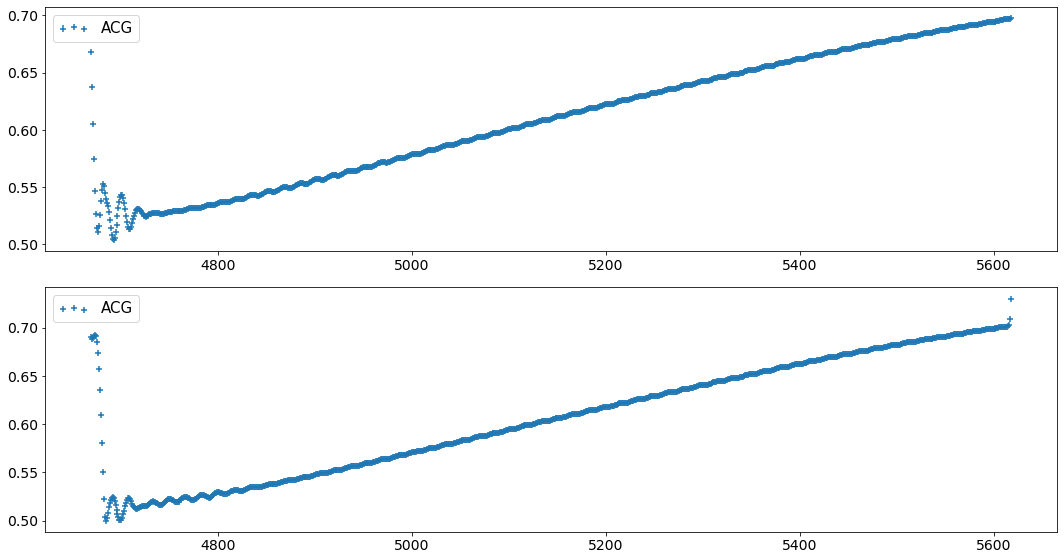


.
.
 7ABG.csv
  Fault type Percentage
0        NML     98.09%
1      FAULT      1.91%


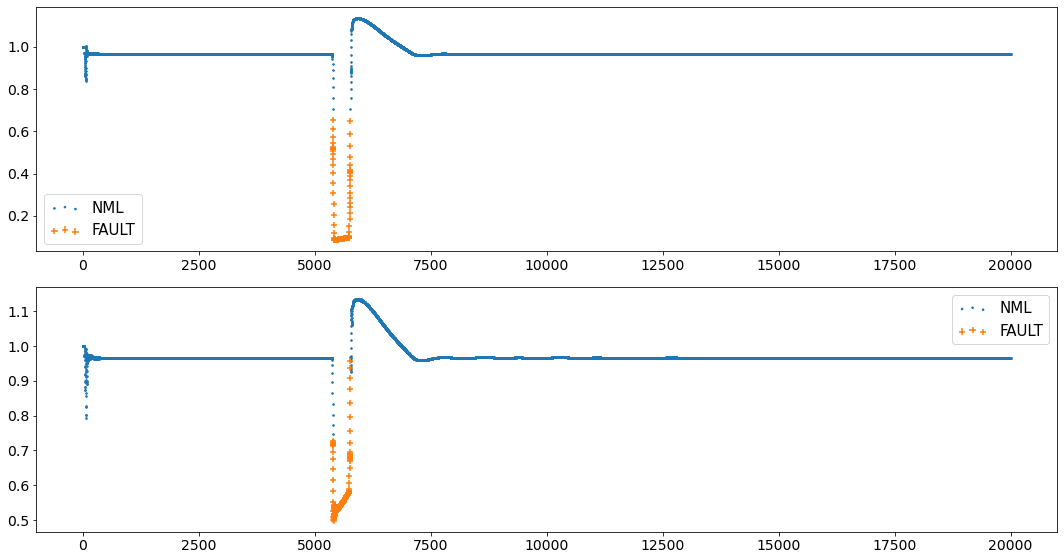

  Fault type Percentage
0        ABG     98.43%
1         AG      1.05%
2         BG      0.52%


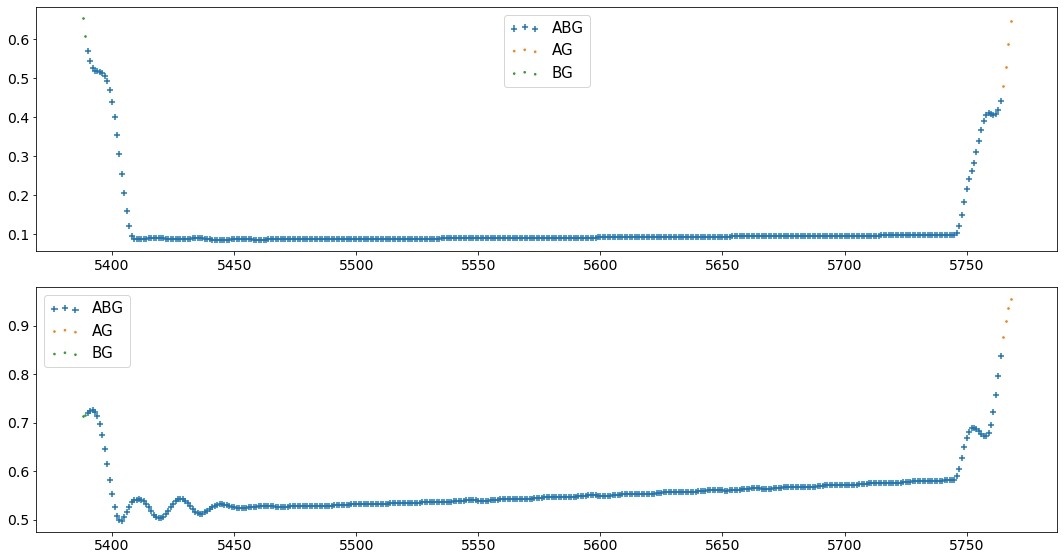


.
.
 9AC.csv
  Fault type Percentage
0        NML     99.58%
1      FAULT      0.41%


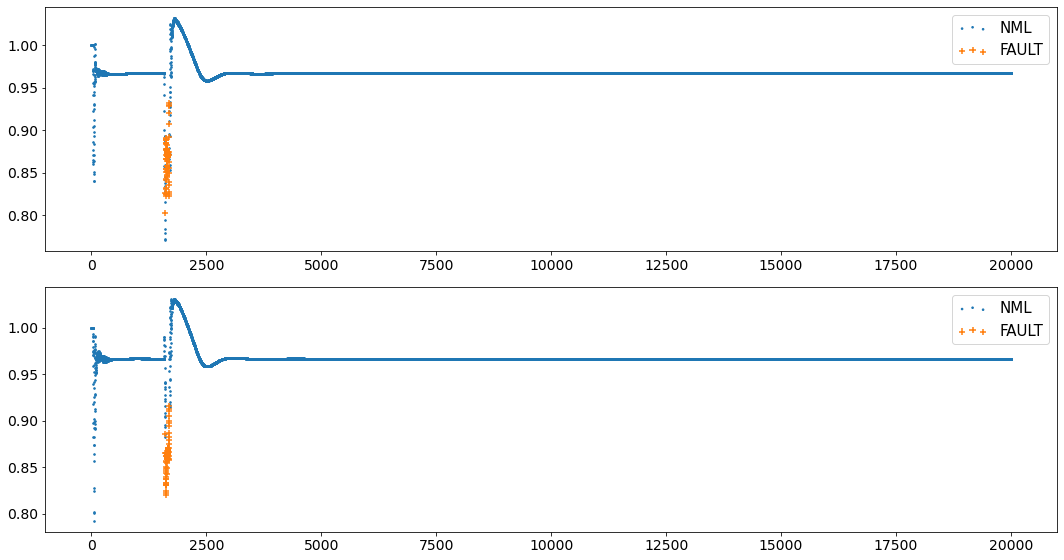

  Fault type Percentage
0         AC     96.39%
1        ACG      3.61%


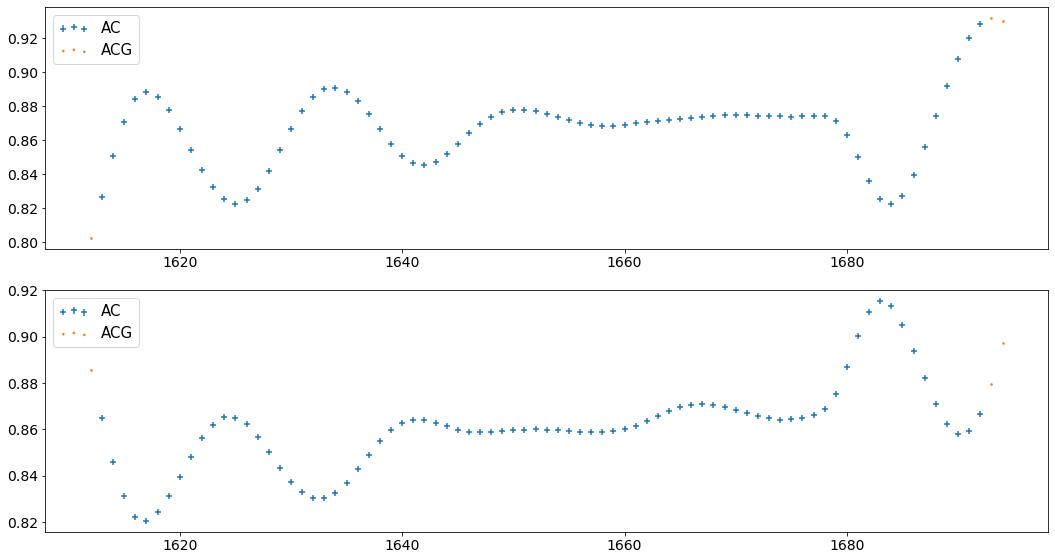


.
.
 1BG.csv
  Fault type Percentage
0        NML     97.57%
1      FAULT      2.43%


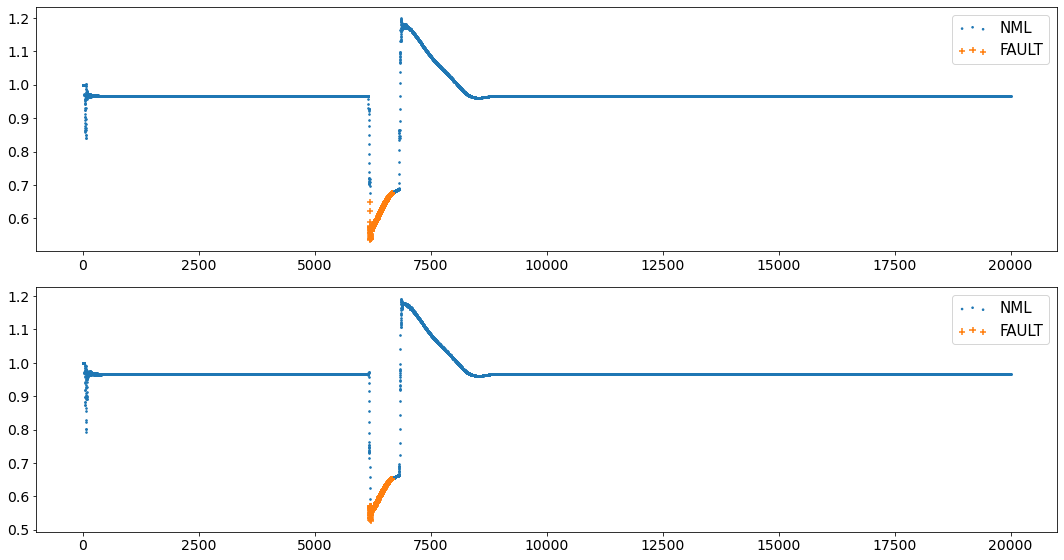

  Fault type Percentage
0         BG     100.0%


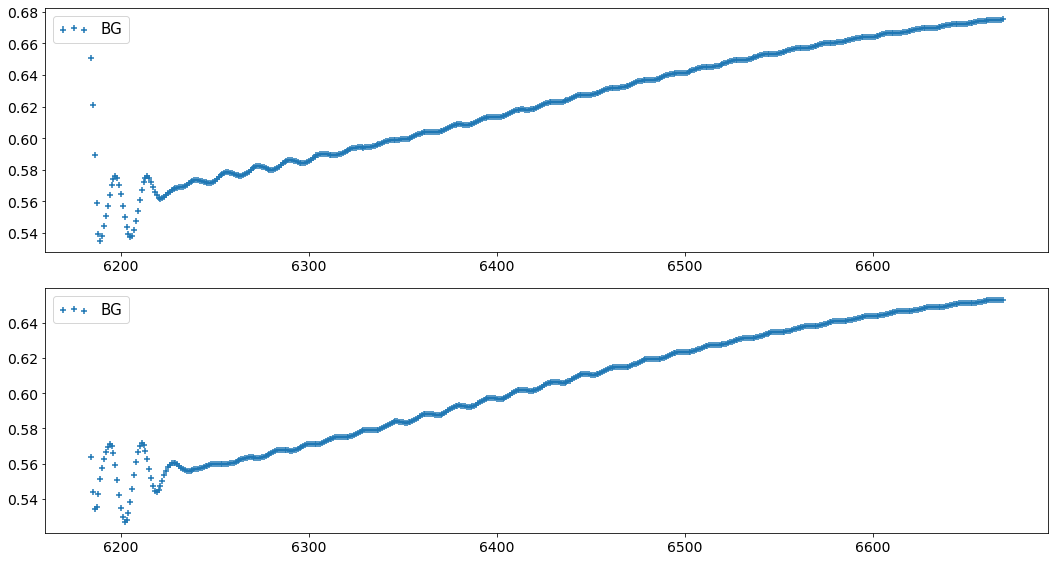


.
.
 5ACG.csv
  Fault type Percentage
0        NML     64.52%
1      FAULT     35.48%


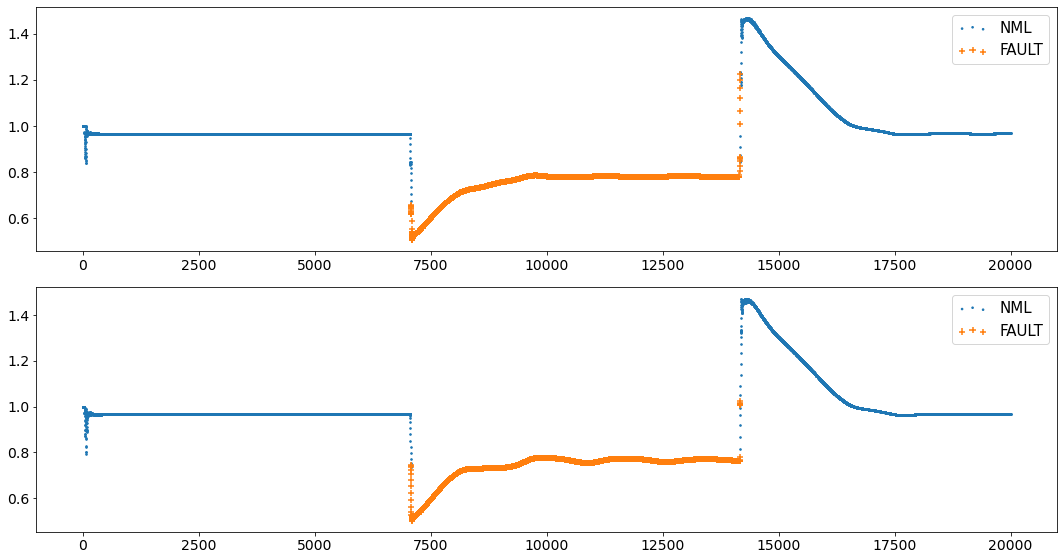

  Fault type Percentage
0        ACG     99.92%
1         AC      0.07%
2         CG      0.01%


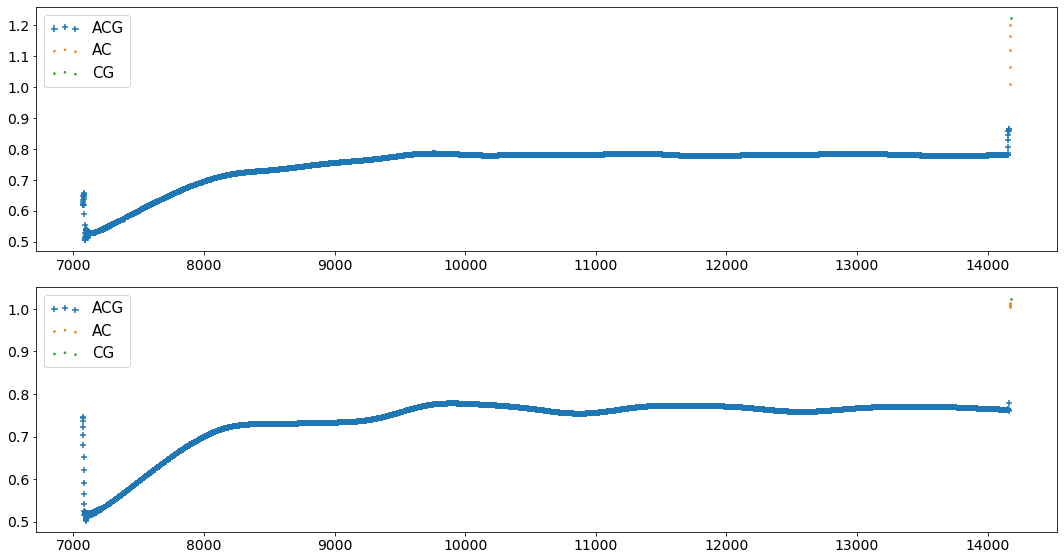


.
.
 9AB.csv
  Fault type Percentage
0        NML     99.11%
1      FAULT      0.89%


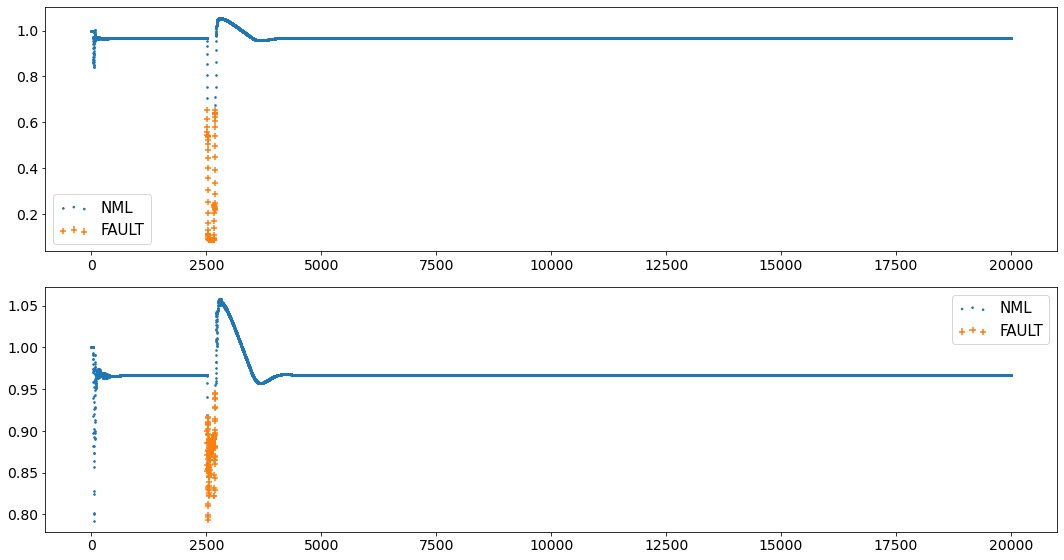

  Fault type Percentage
0         AB     84.18%
1        ABG      6.78%
2         BG      6.21%
3         AG      2.82%


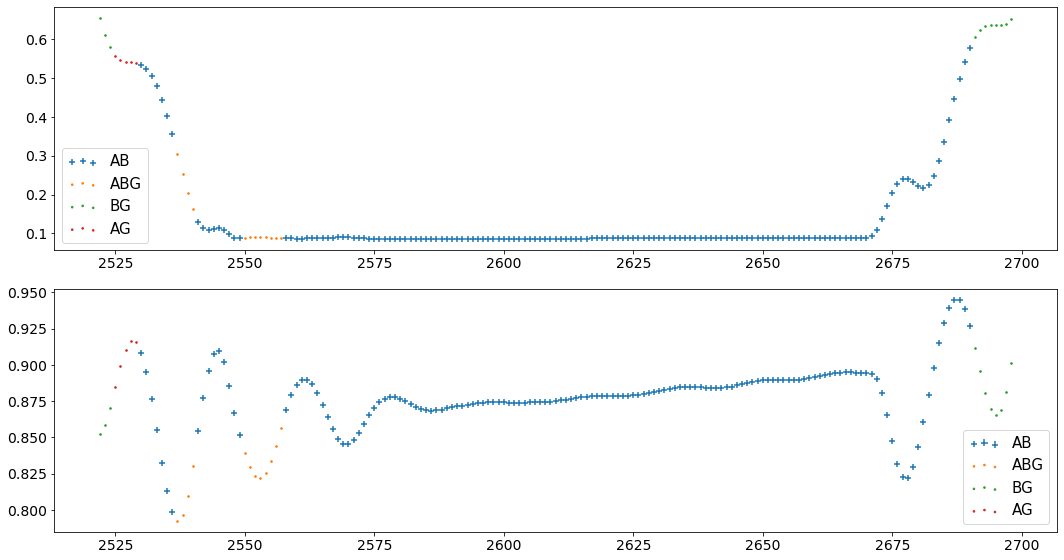


.
.
 9ACG.csv
  Fault type Percentage
0        NML     92.53%
1      FAULT      7.47%


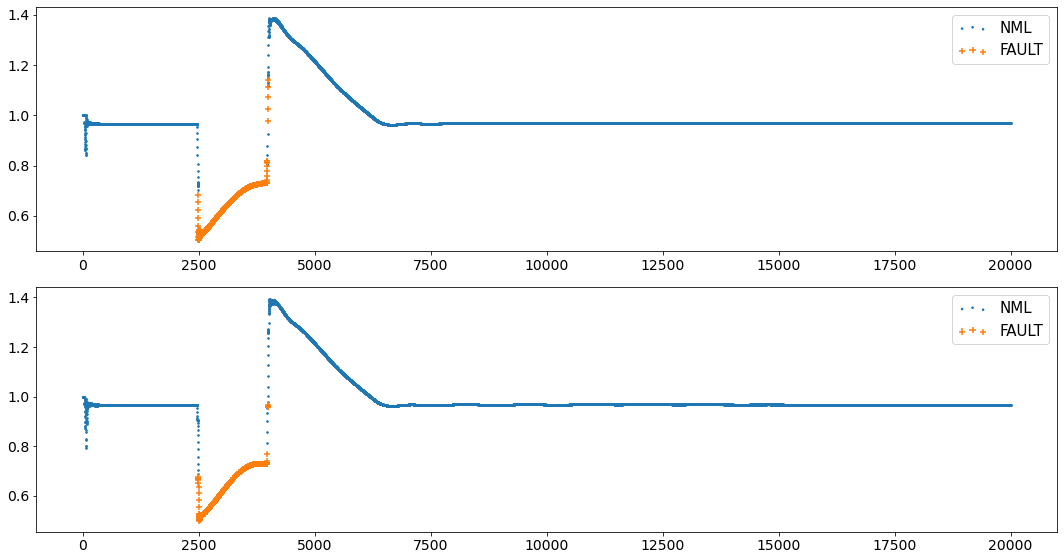

  Fault type Percentage
0        ACG     99.67%
1         AC      0.27%
2         CG      0.07%


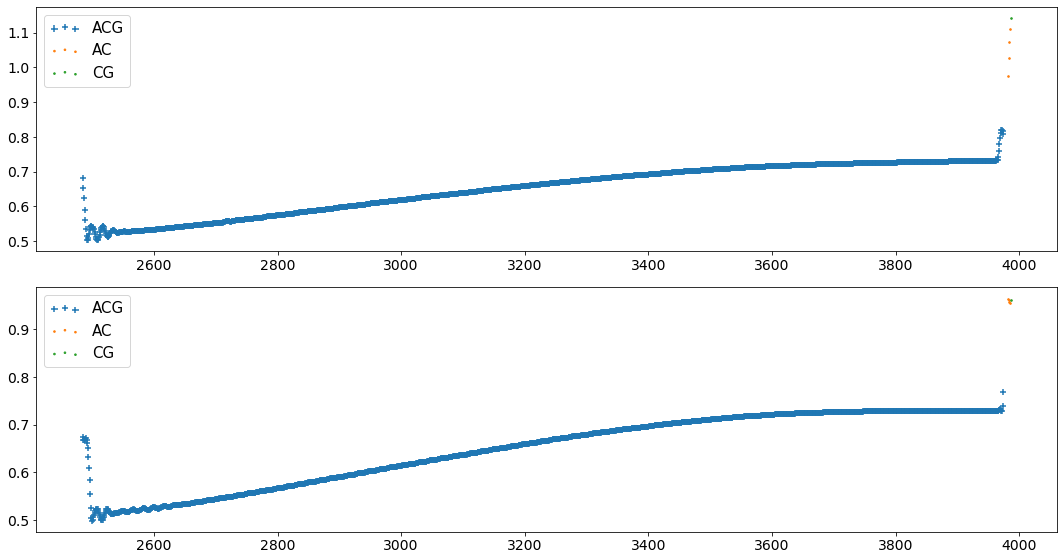


.
.
 5BC.csv
  Fault type Percentage
0        NML     68.82%
1      FAULT     31.18%


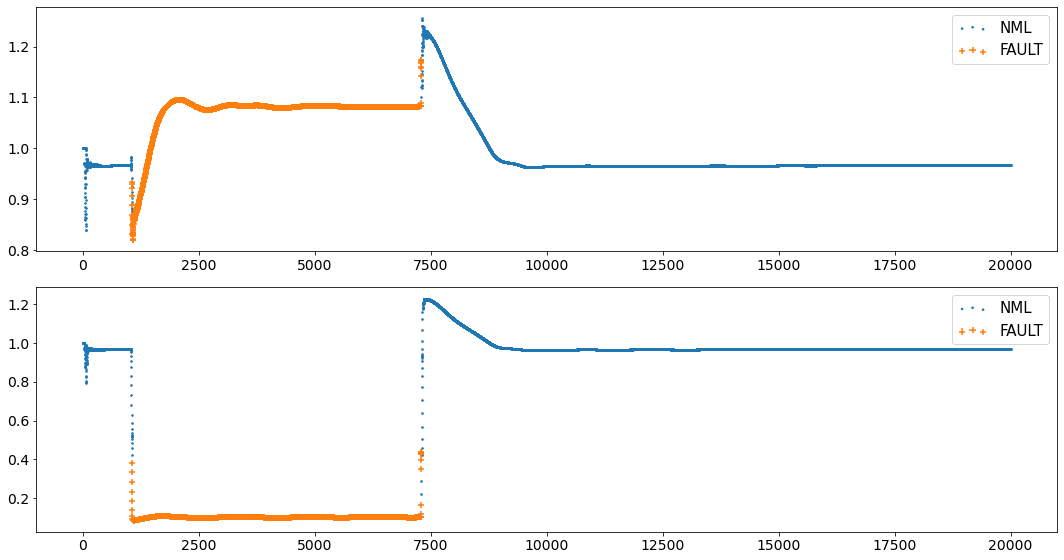

  Fault type Percentage
0         BC     100.0%


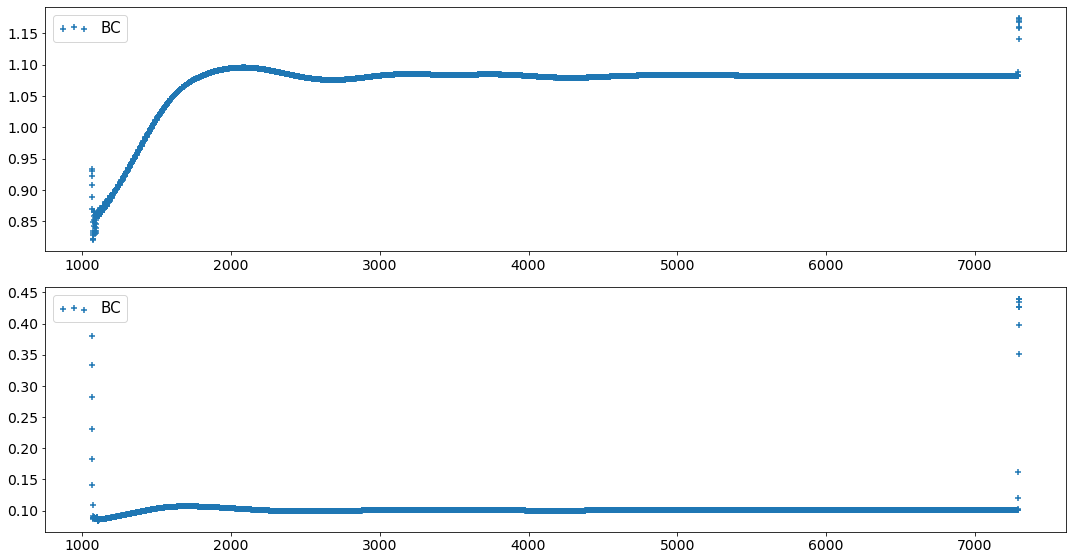


.
.
 5CG.csv
  Fault type Percentage
0        NML     93.78%
1      FAULT      6.22%


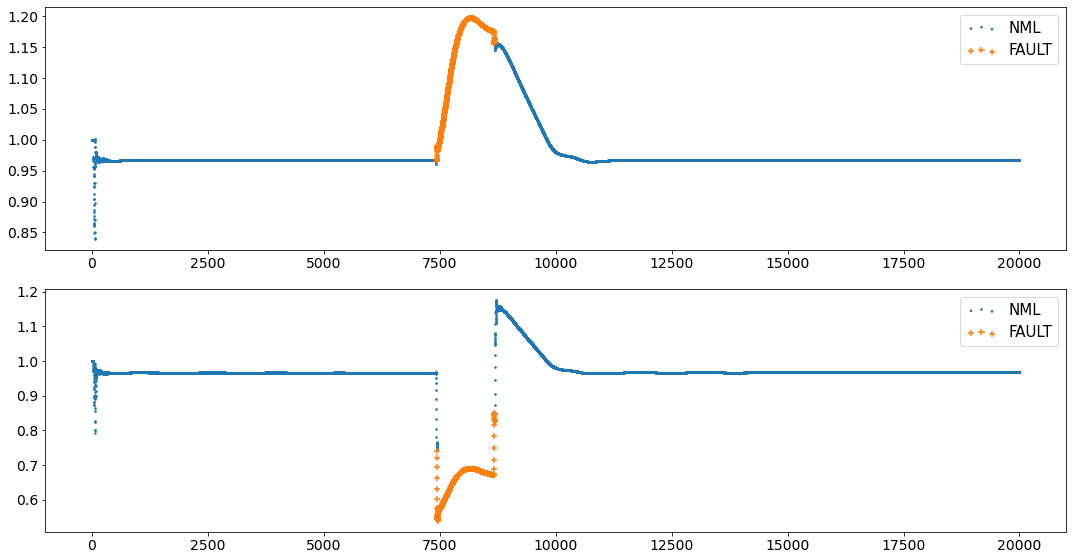

  Fault type Percentage
0         CG     100.0%


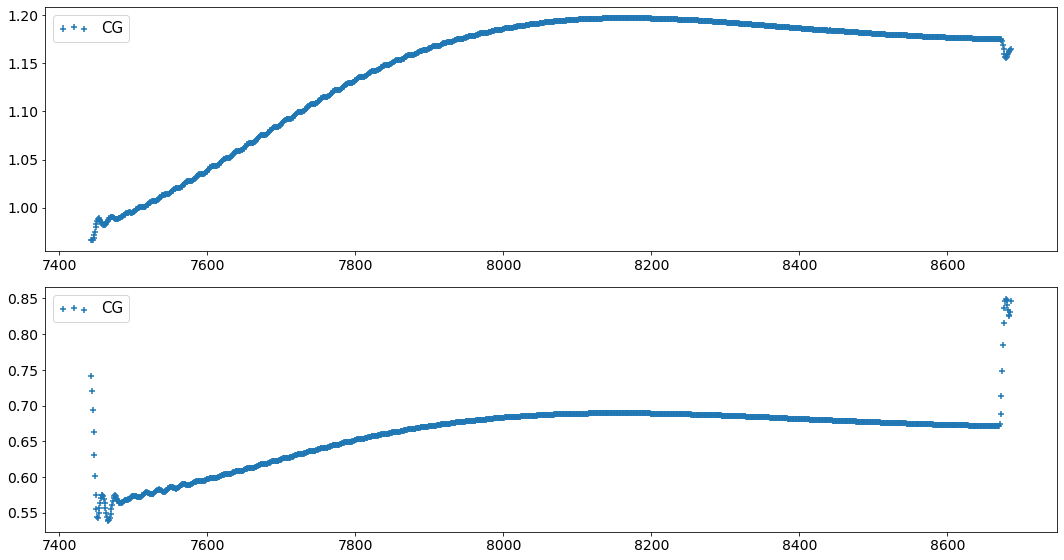


.
.
 4ABCG.csv
  Fault type Percentage
0        NML     94.26%
1      FAULT      5.74%


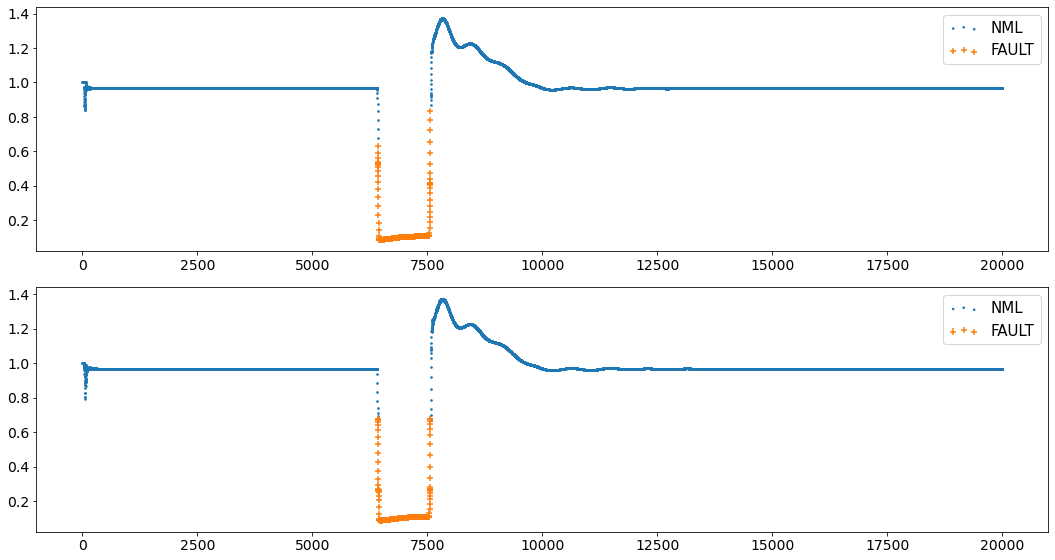

  Fault type Percentage
0       ABCG     98.08%
1        ABG      0.78%
2        BCG      0.52%
3        ACG      0.44%
4         BG      0.17%


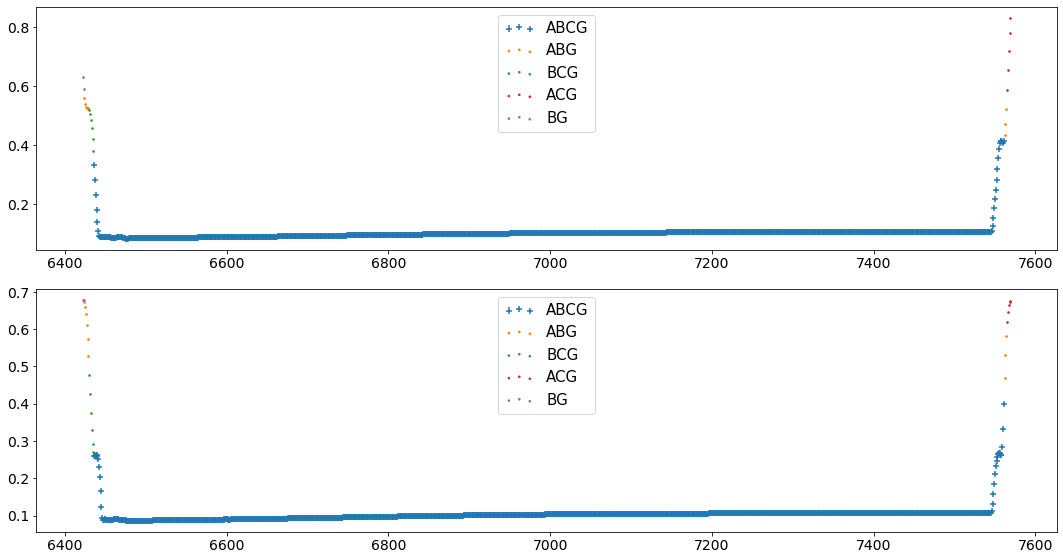


.
.
 7BC.csv
  Fault type Percentage
0        NML     98.56%
1      FAULT      1.44%


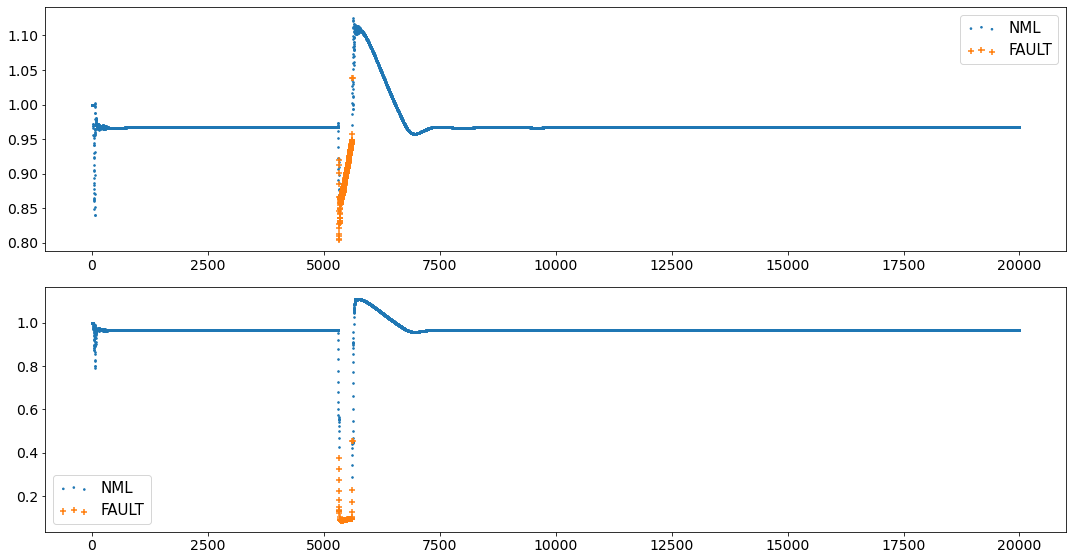

  Fault type Percentage
0         BC     100.0%


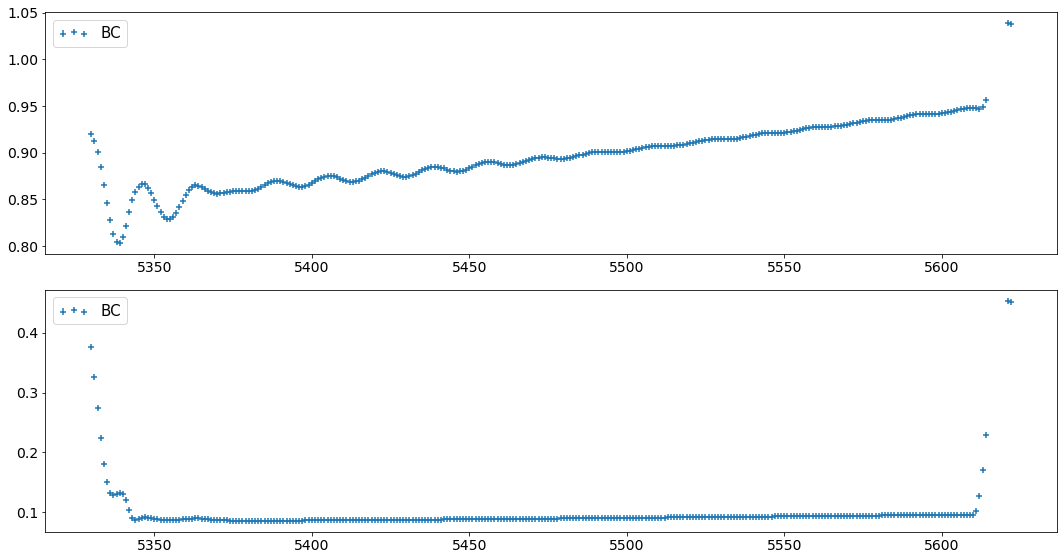


.
.
 7CG.csv
  Fault type Percentage
0        NML      95.6%
1      FAULT       4.4%


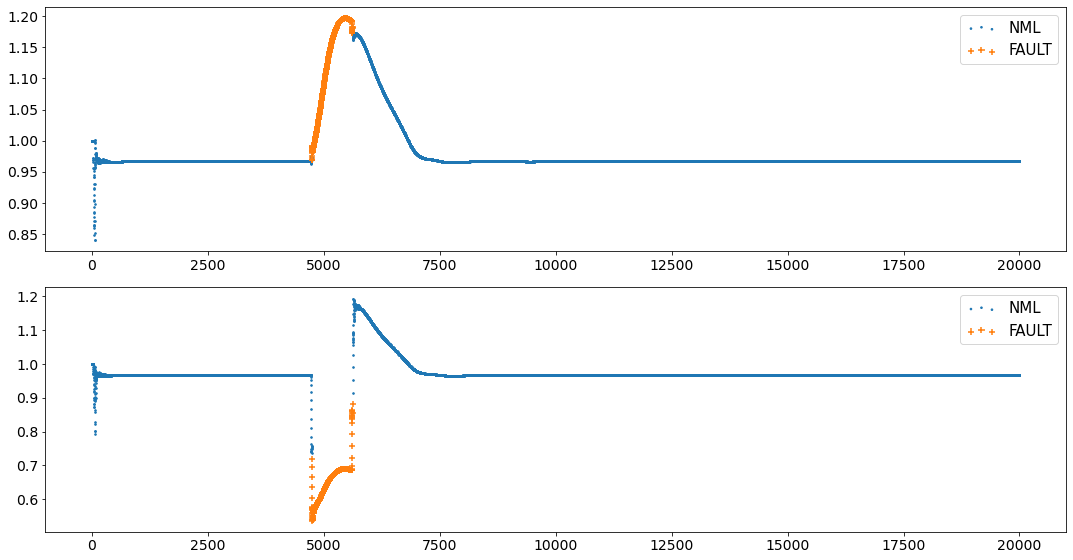

  Fault type Percentage
0         CG     100.0%


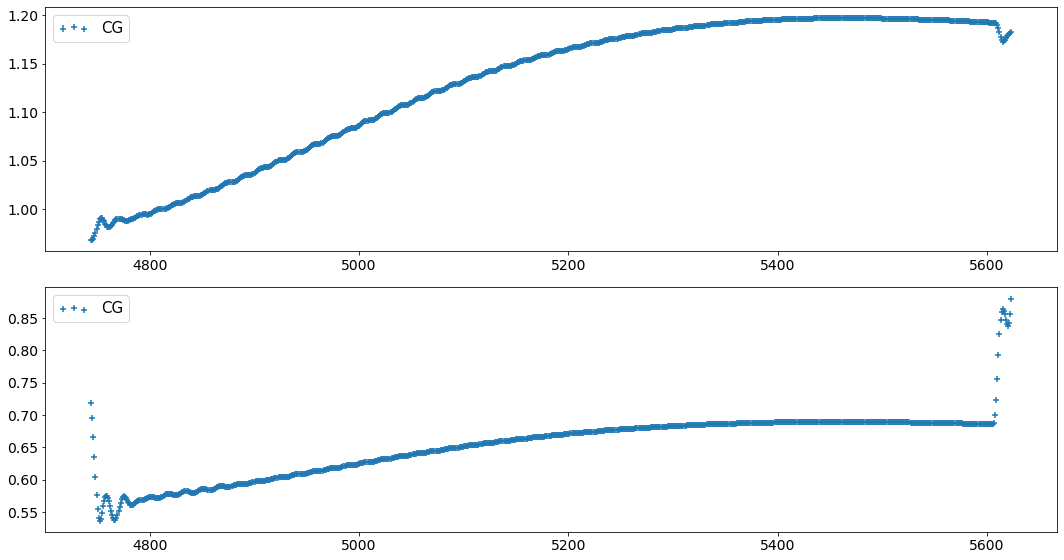


.
.
 10ACG.csv
  Fault type Percentage
0        NML     82.78%
1      FAULT     17.22%


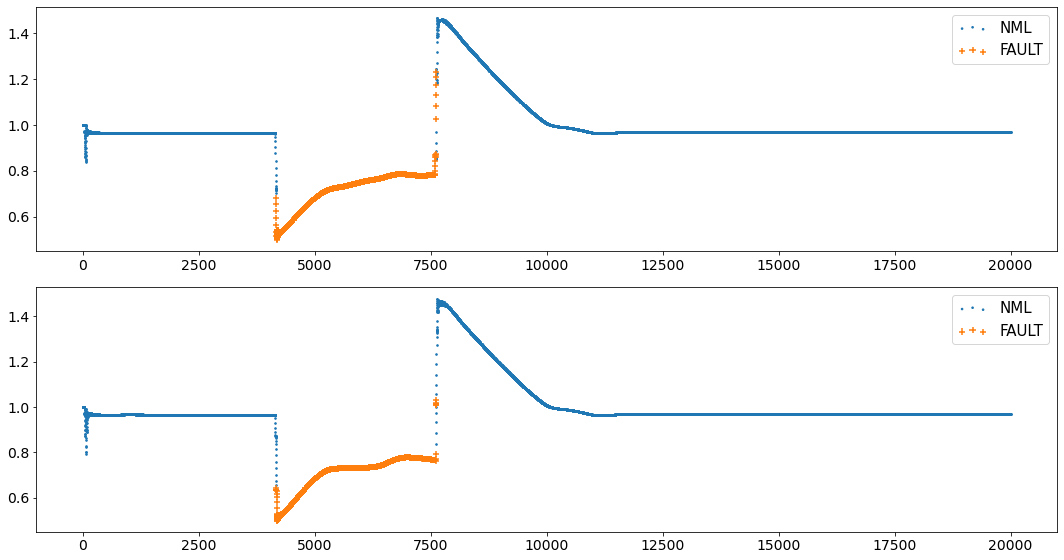

  Fault type Percentage
0        ACG     99.83%
1         AC      0.15%
2         CG      0.03%


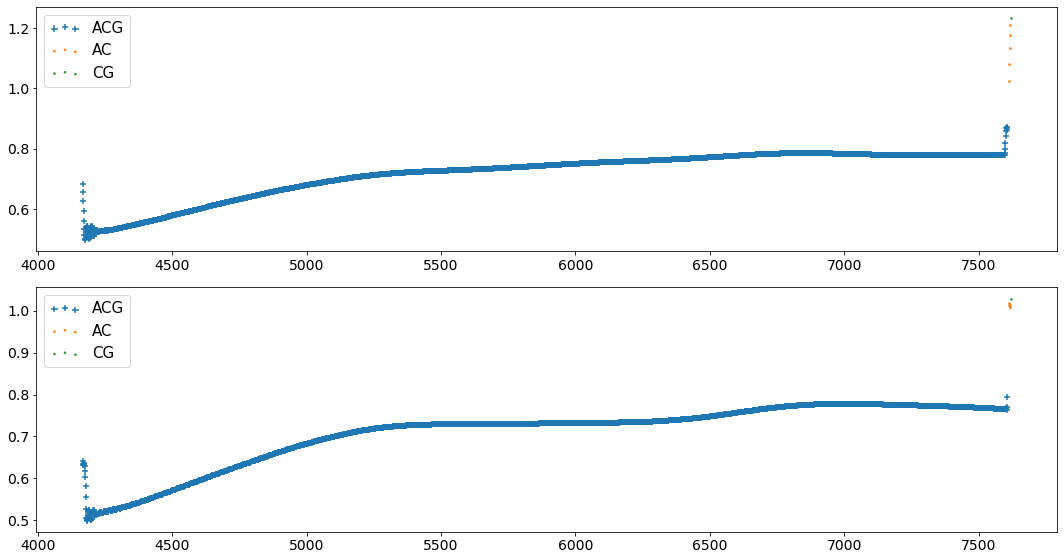


.
.
 3BG.csv
  Fault type Percentage
0        NML     99.91%
1      FAULT      0.09%


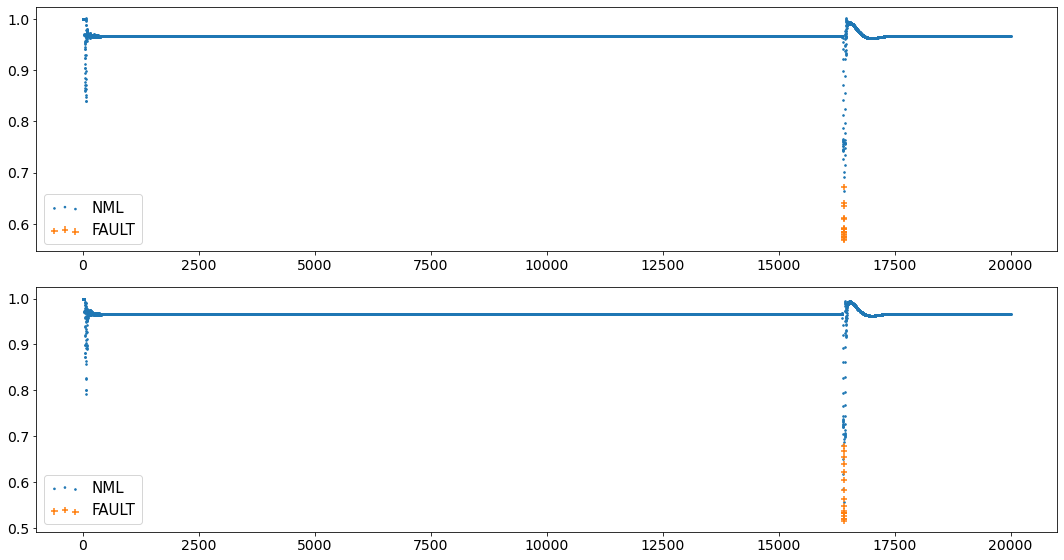

  Fault type Percentage
0         BG     100.0%


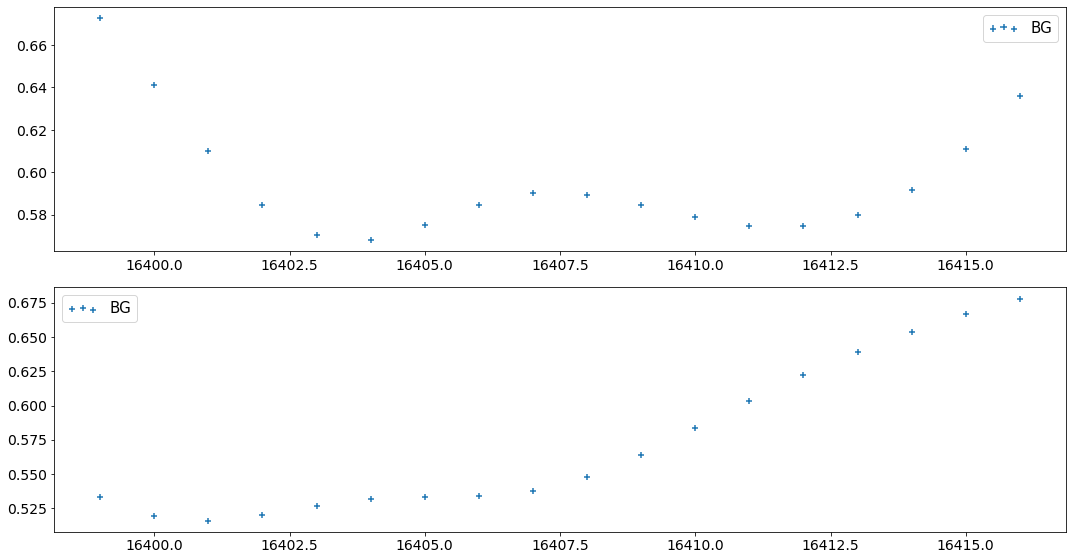


.
.
 3BCG.csv
  Fault type Percentage
0        NML     61.72%
1      FAULT     38.28%


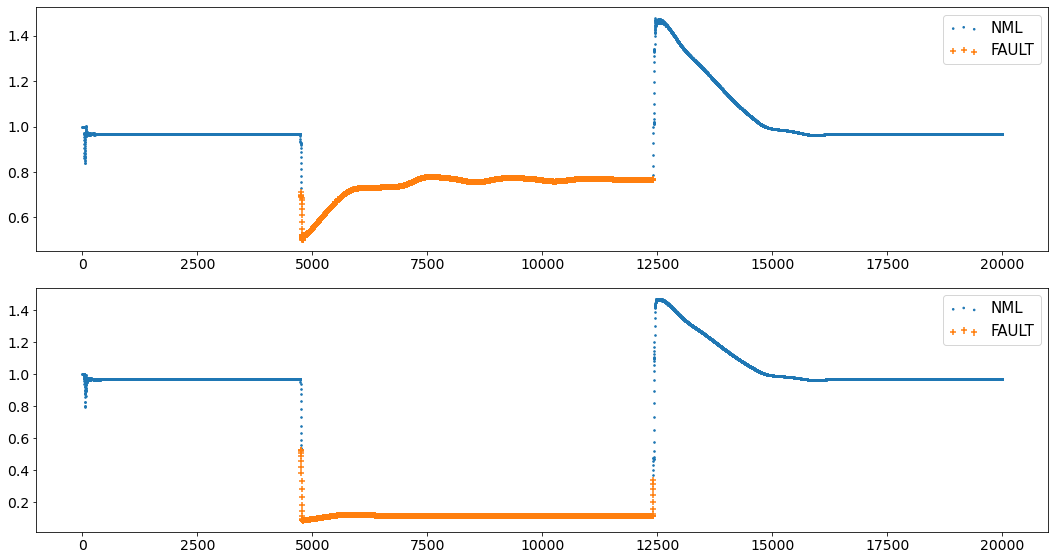

  Fault type Percentage
0        BCG     99.95%
1         BC      0.05%


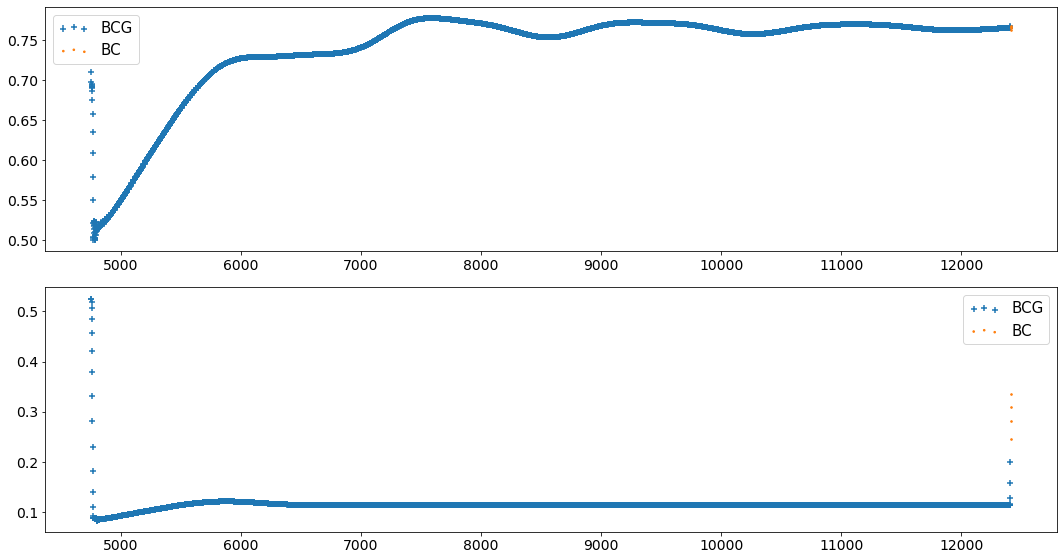


.
.
 4BG.csv
  Fault type Percentage
0        NML     99.17%
1      FAULT      0.83%


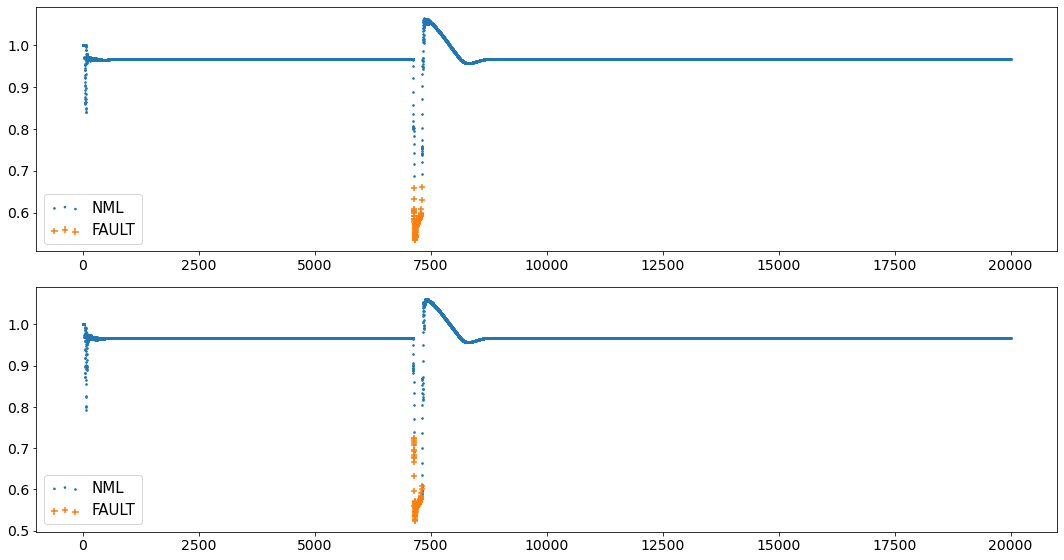

  Fault type Percentage
0         BG     100.0%


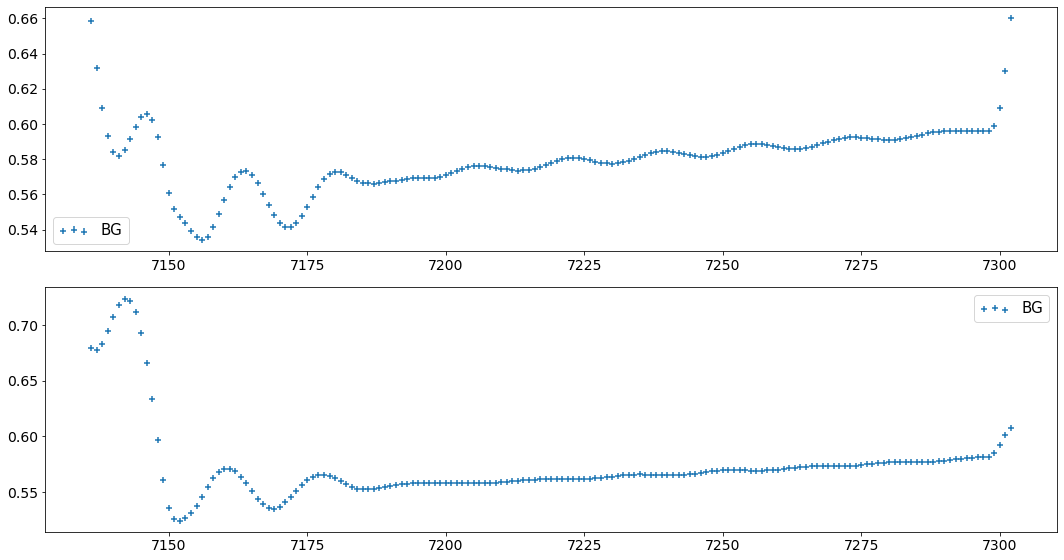


.
.
 1ACG.csv
  Fault type Percentage
0        NML     91.75%
1      FAULT      8.25%


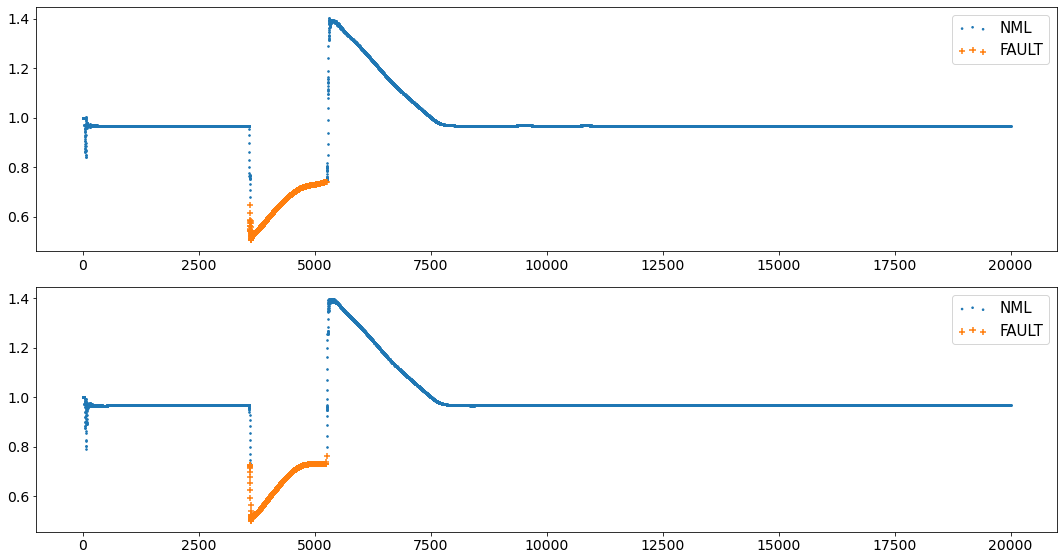

  Fault type Percentage
0        ACG     100.0%


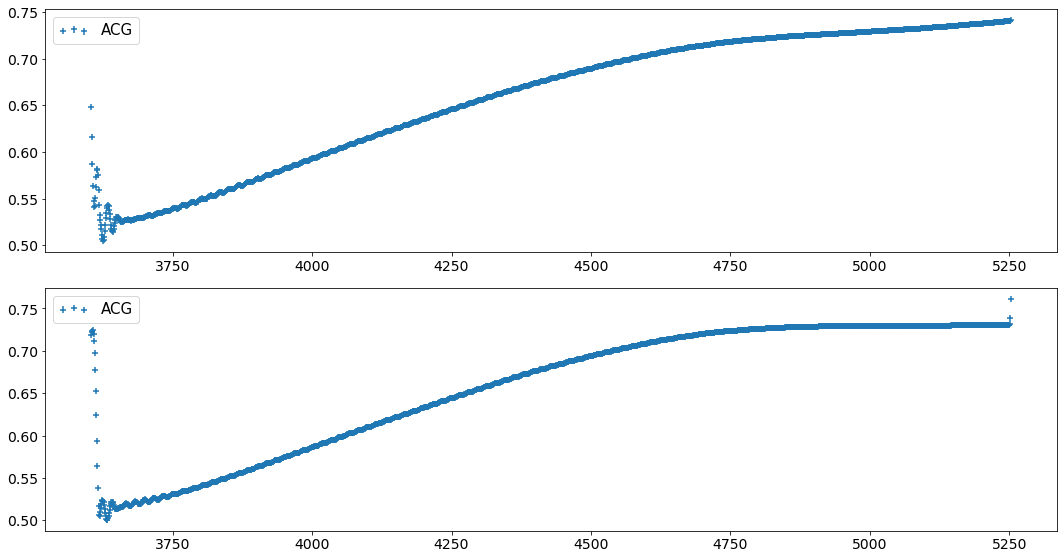


.
.
 8AG.csv
  Fault type Percentage
0        NML     98.27%
1      FAULT      1.74%


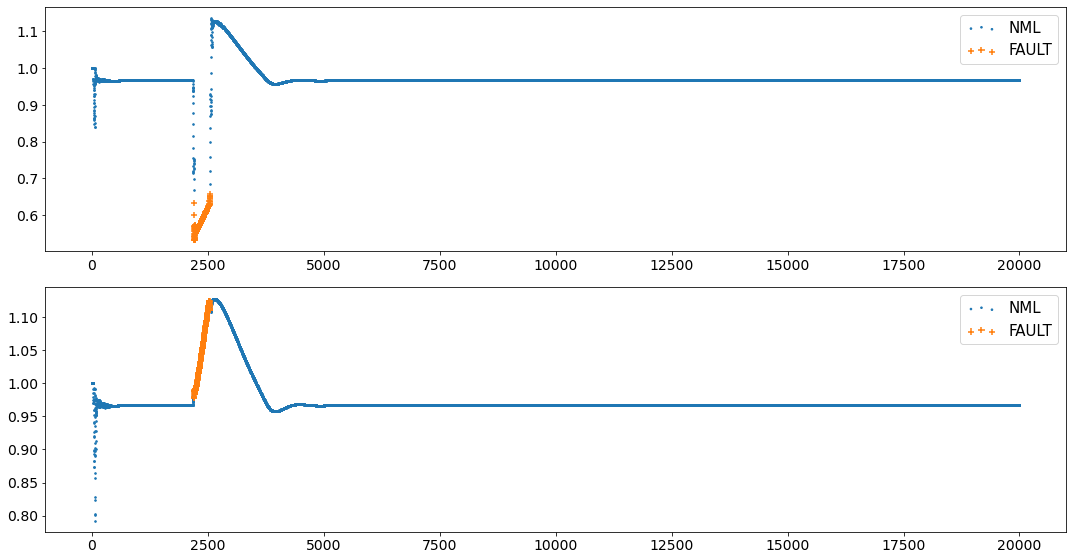

  Fault type Percentage
0         AG     100.0%


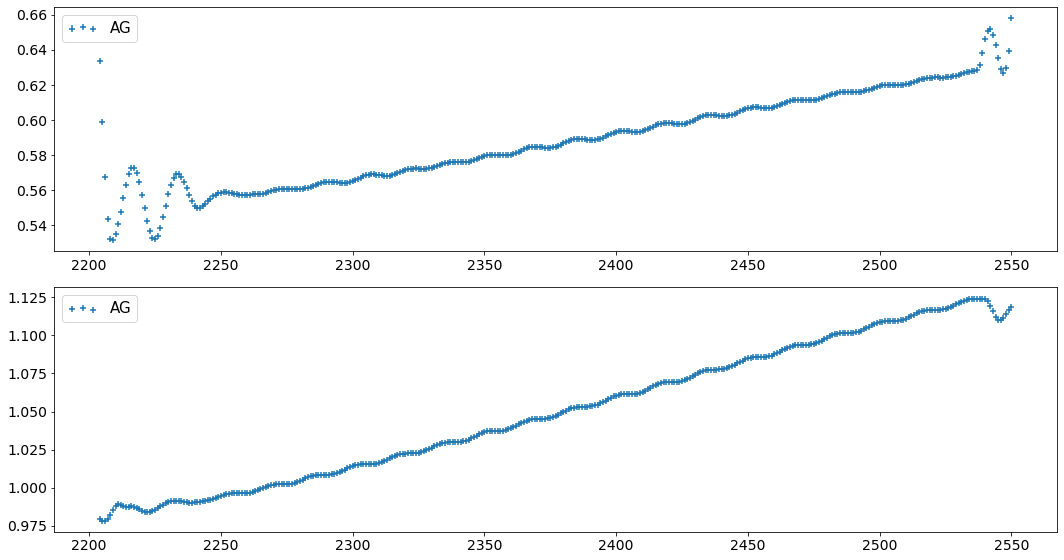


.
.
 3ABG.csv
  Fault type Percentage
0      FAULT     68.45%
1        NML     31.55%


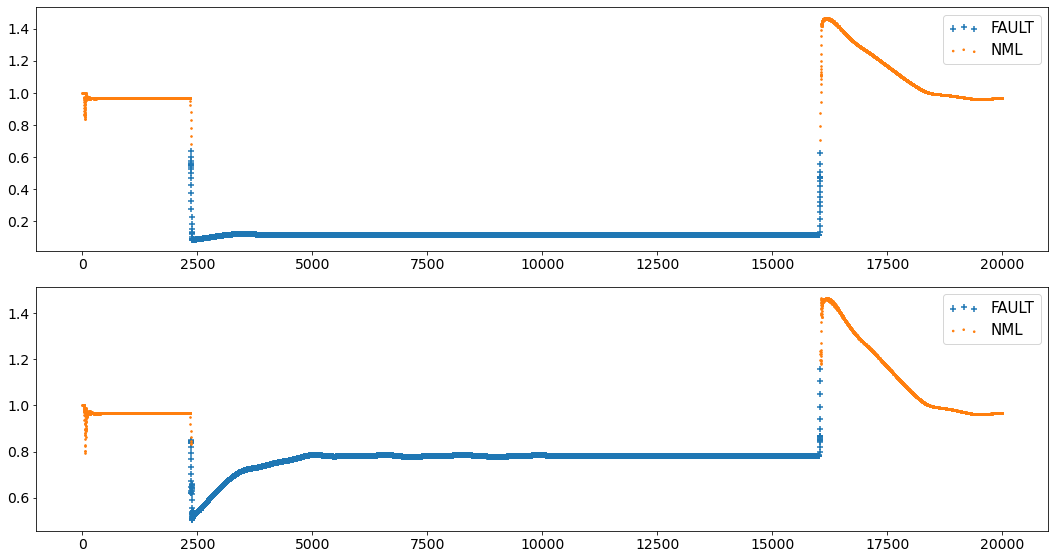

  Fault type Percentage
0        ABG     99.88%
1         AB      0.07%
2         AG      0.04%
3         BG      0.01%


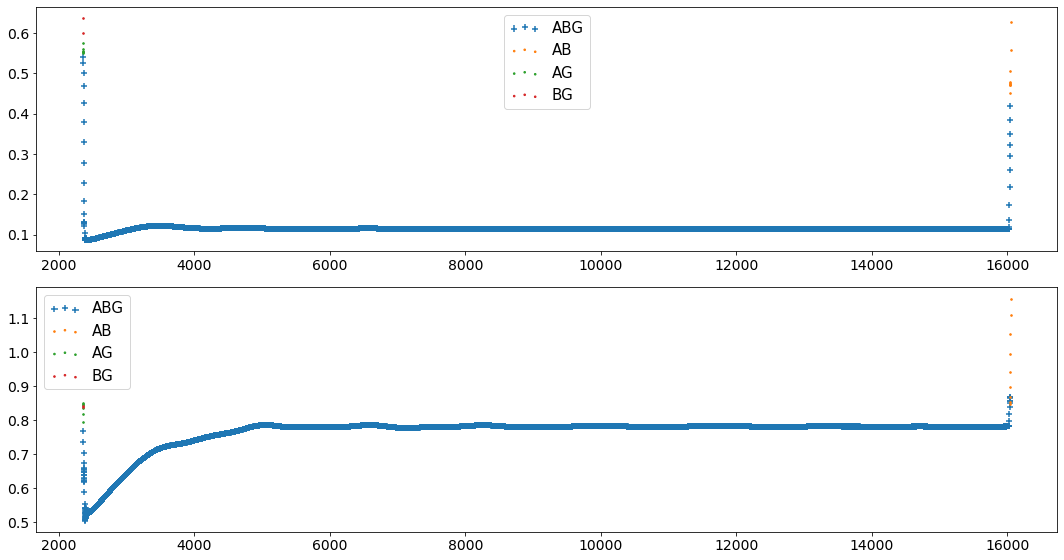


.
.
 10AC.csv
  Fault type Percentage
0        NML     89.99%
1      FAULT     10.01%


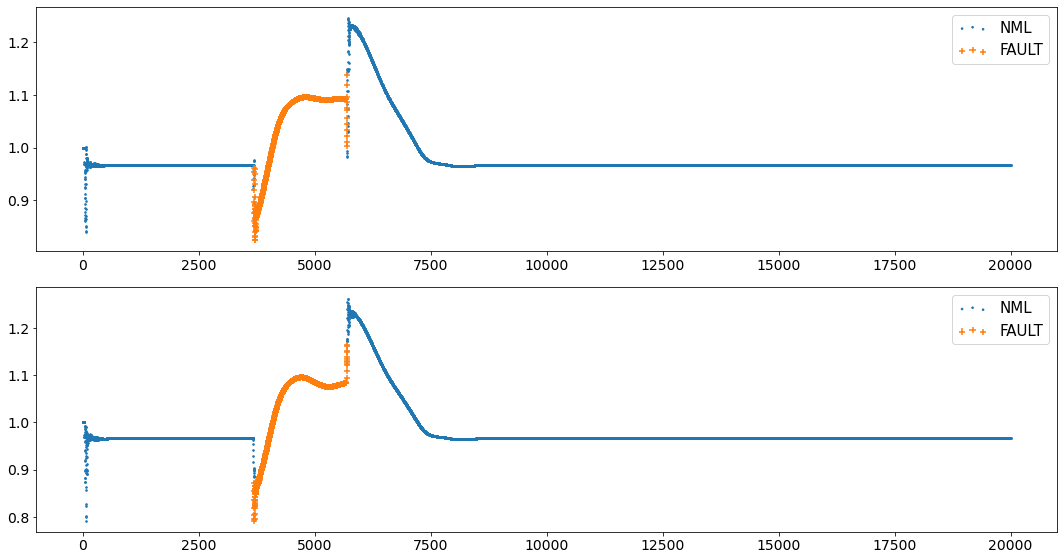

  Fault type Percentage
0         AC     99.85%
1        ACG      0.15%


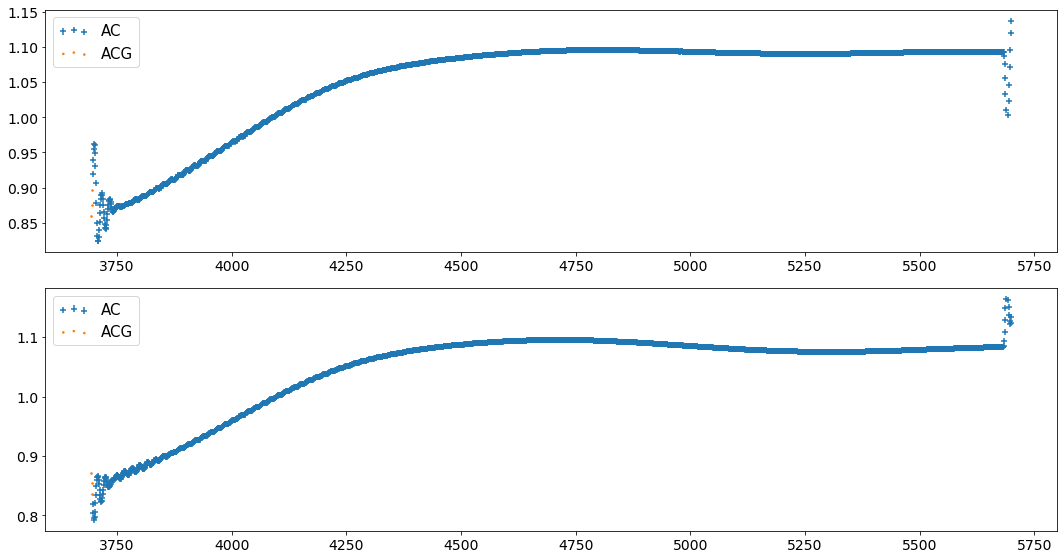


.
.
 7BCG.csv
  Fault type Percentage
0        NML     96.78%
1      FAULT      3.22%


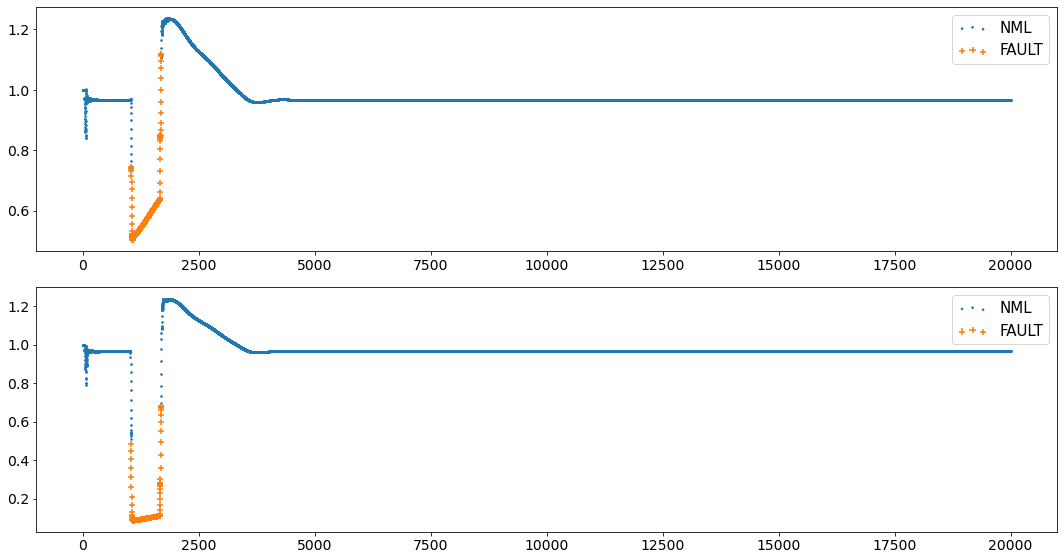

  Fault type Percentage
0        BCG     97.98%
1         CG      1.55%
2         BC      0.47%


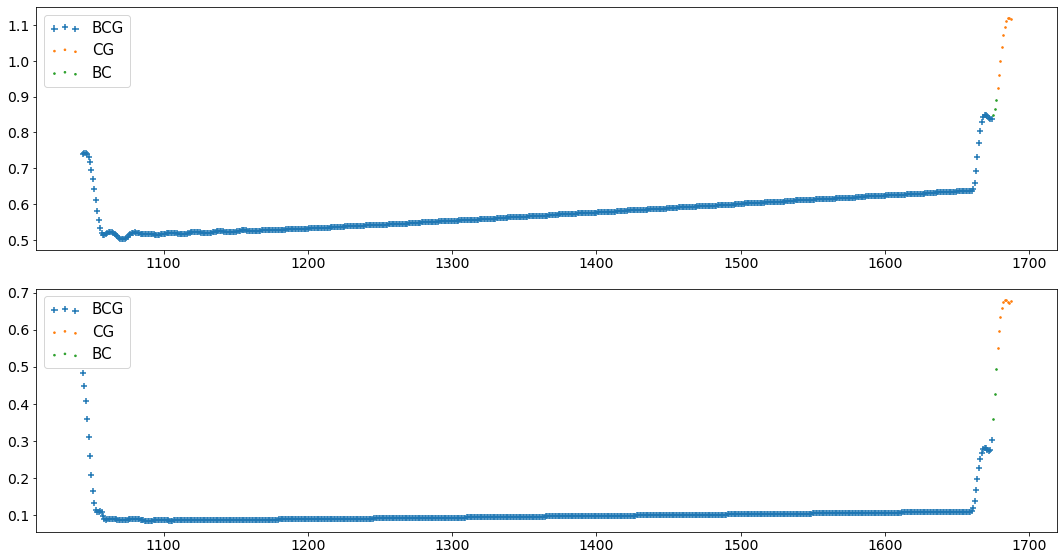


.
.
 6ABCG.csv
  Fault type Percentage
0      FAULT     67.17%
1        NML     32.83%


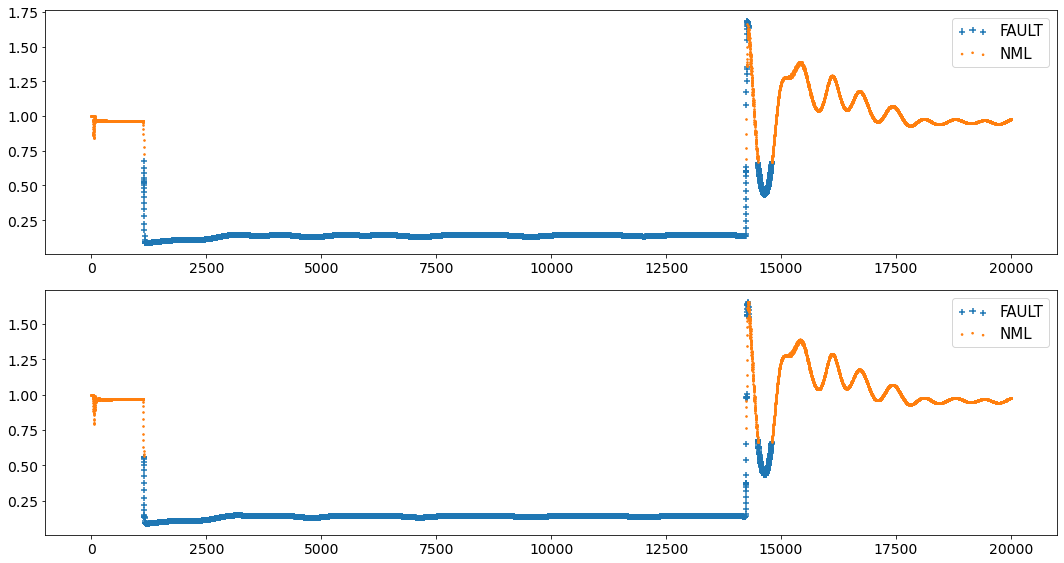

  Fault type Percentage
0       ABCG     97.38%
1        ABG      2.21%
2        BCG      0.19%
3        ACG      0.13%
4         AC      0.04%
5         CG      0.03%
6         BG      0.01%


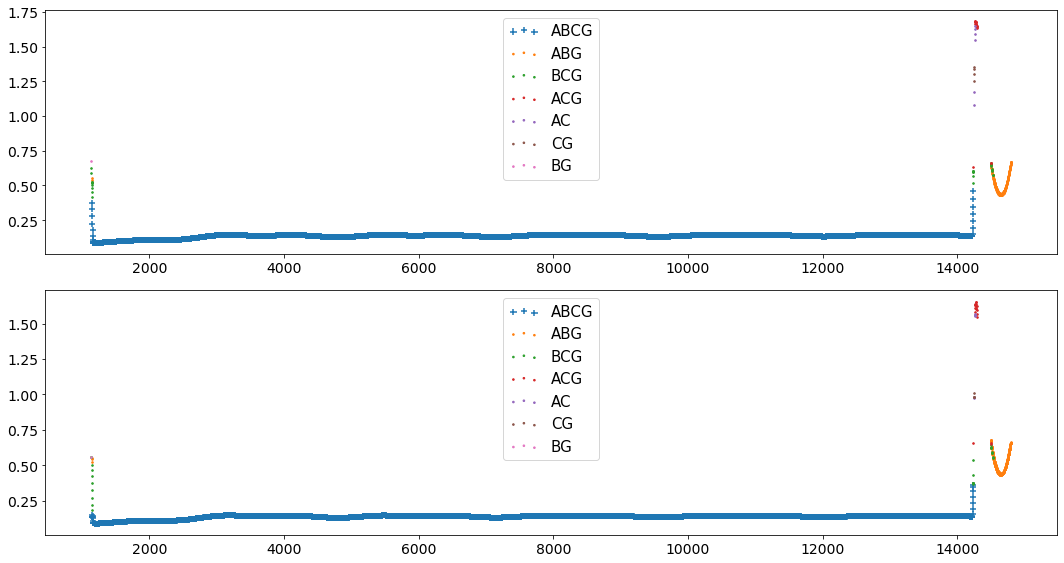


.
.
 6BG.csv
  Fault type Percentage
0        NML      65.8%
1      FAULT      34.2%


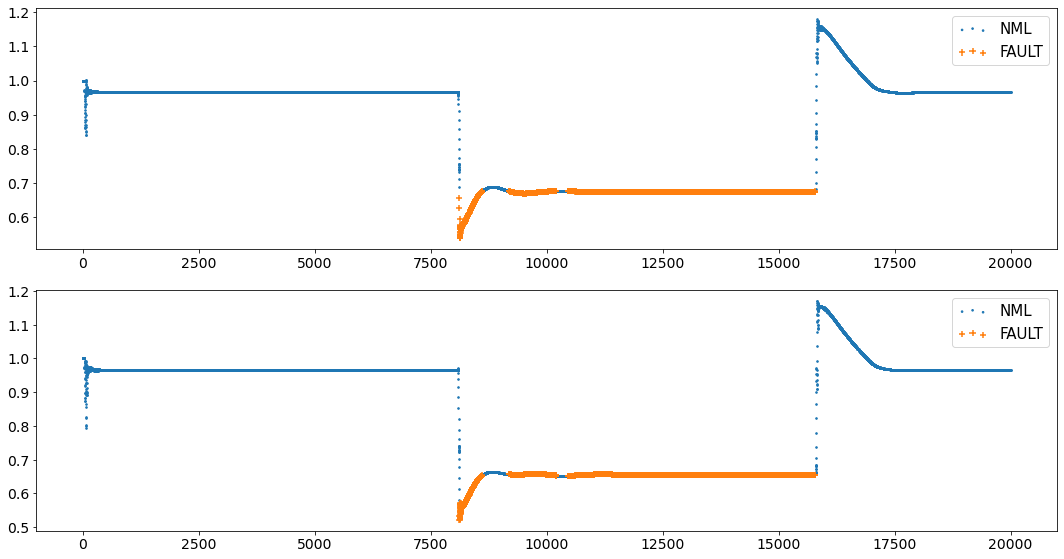

  Fault type Percentage
0         BG     100.0%


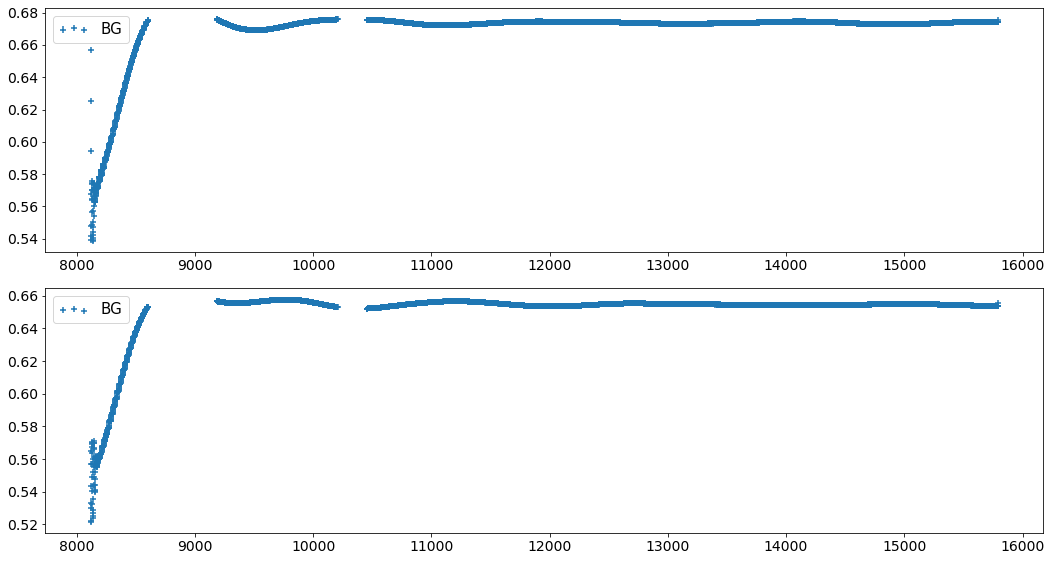


.
.
 10AB.csv
  Fault type Percentage
0        NML     97.68%
1      FAULT      2.32%


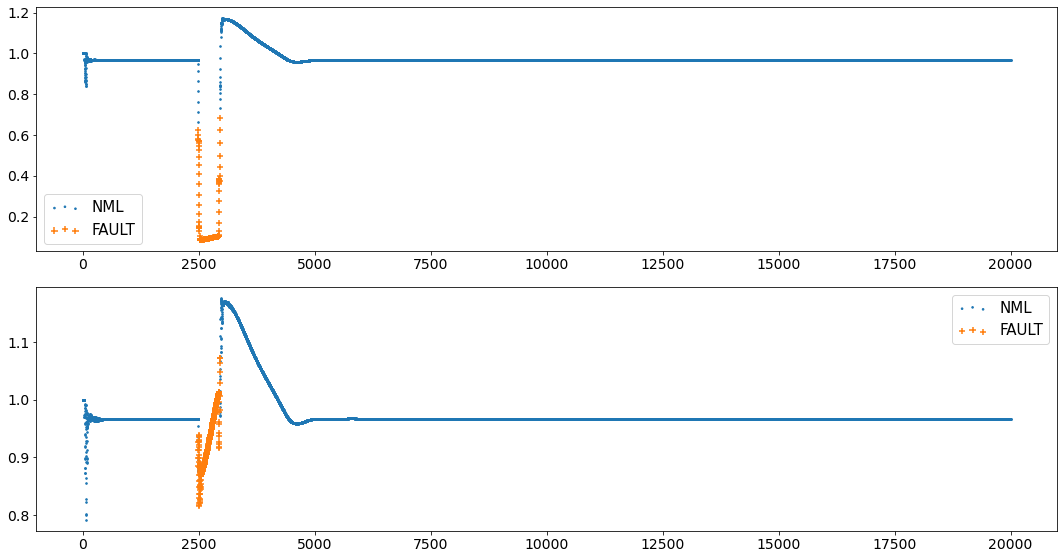

  Fault type Percentage
0         AB     96.77%
1        ABG      1.51%
2         AG      1.51%
3         BG      0.22%


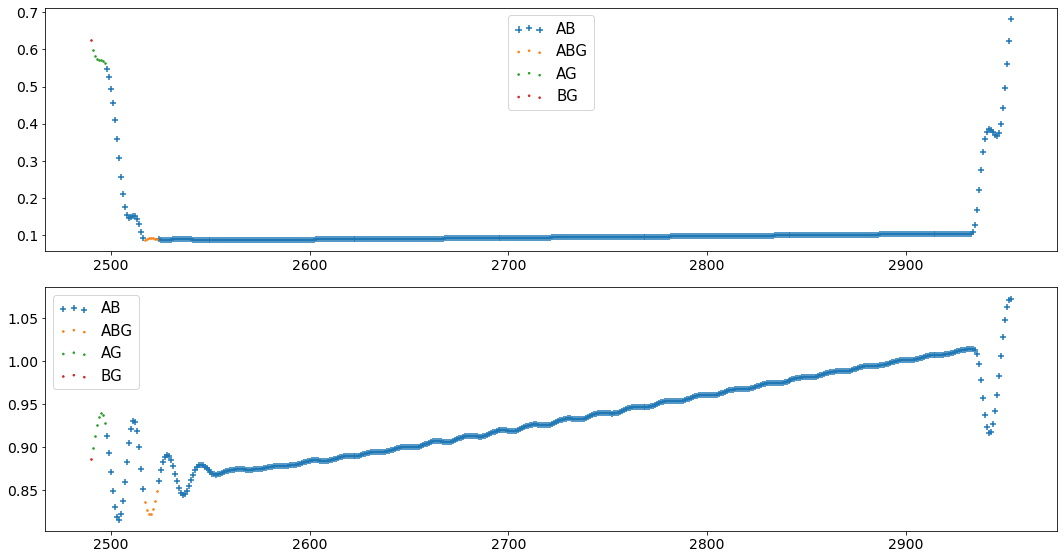


.
.
 2BC.csv
  Fault type Percentage
0        NML     95.24%
1      FAULT      4.76%


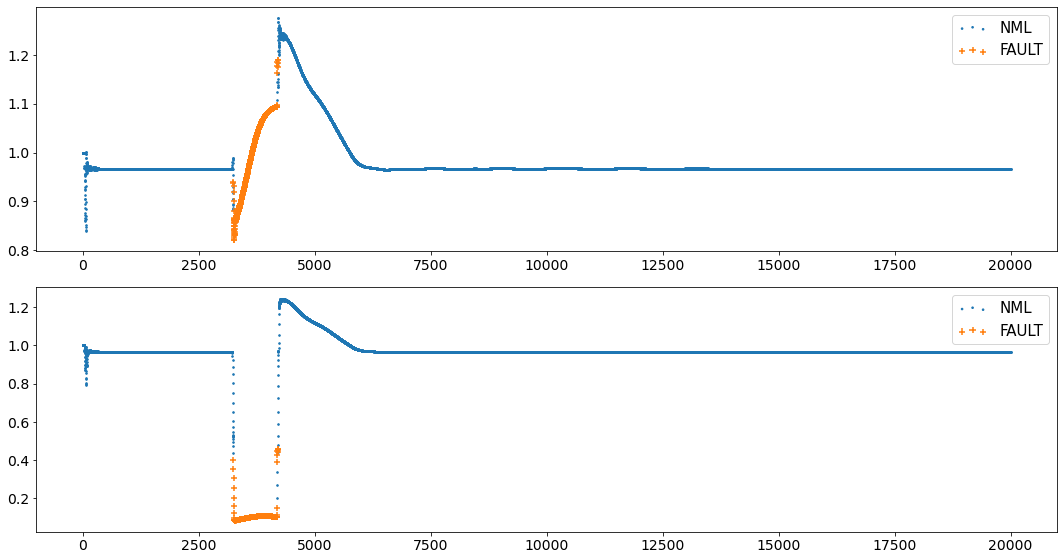

  Fault type Percentage
0         BC     100.0%


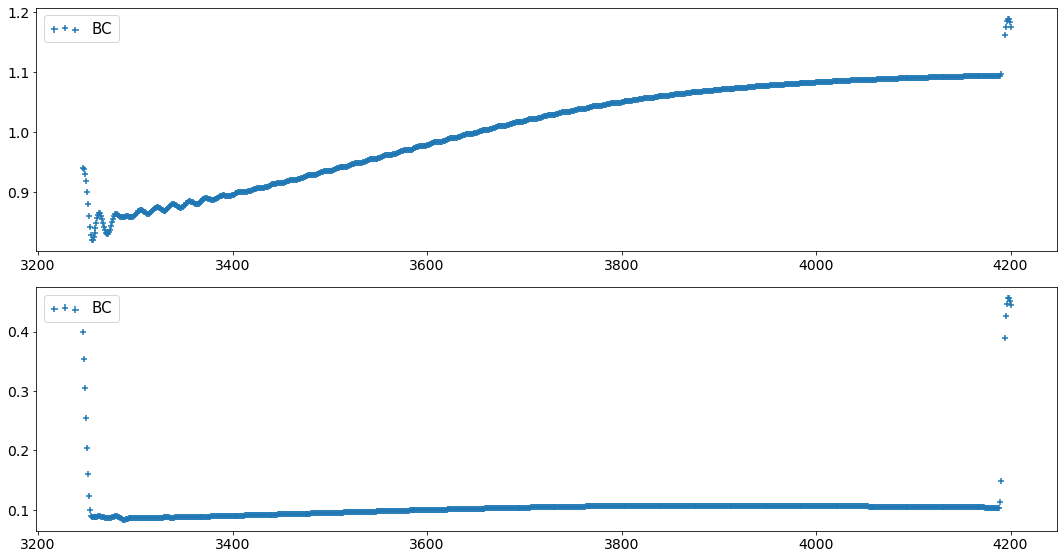


.
.
 2CG.csv
  Fault type Percentage
0        NML     98.18%
1      FAULT      1.82%


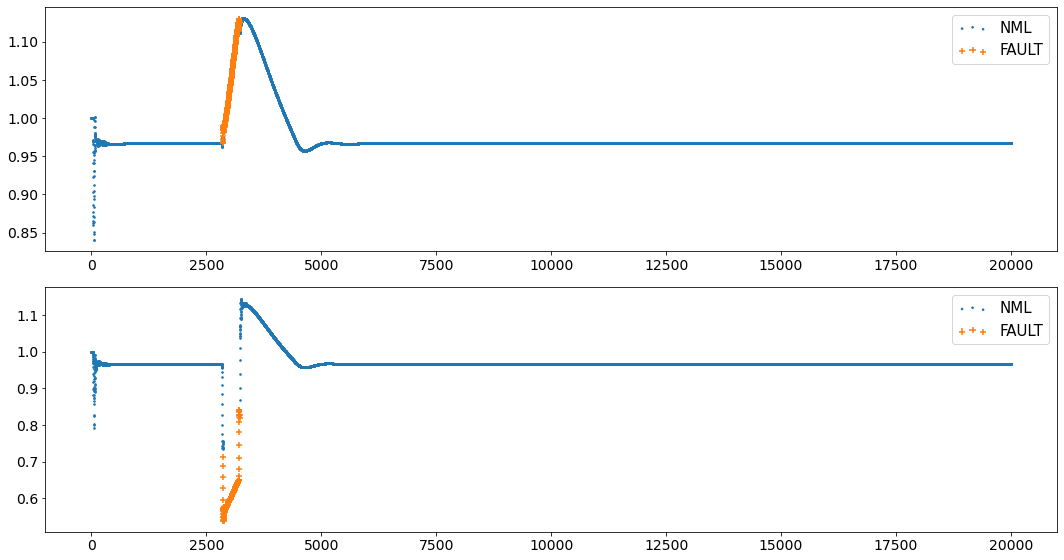

  Fault type Percentage
0         CG     100.0%


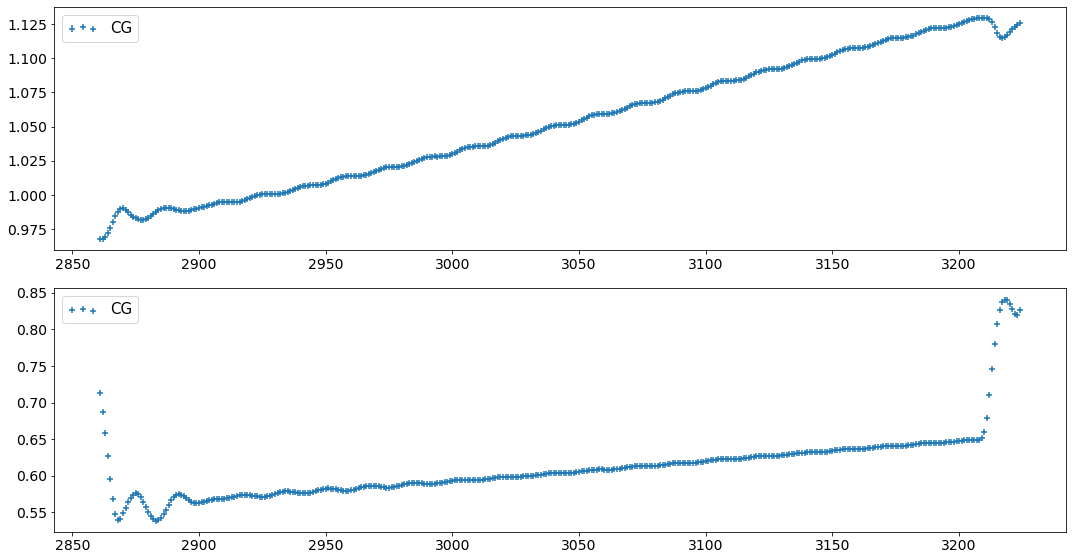


.
.
 5BCG.csv
  Fault type Percentage
0        NML     91.84%
1      FAULT      8.16%


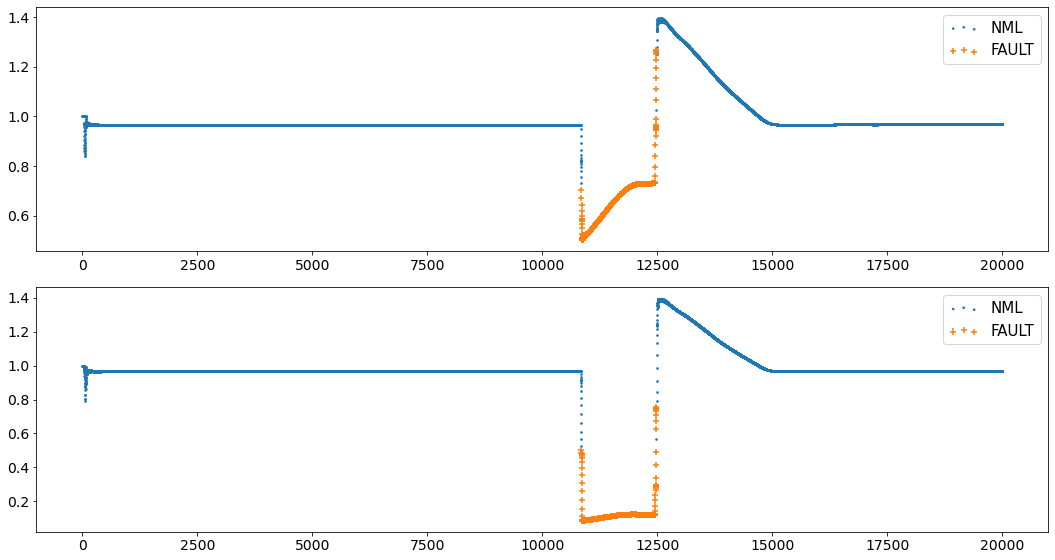

  Fault type Percentage
0        BCG     98.59%
1         BC       0.8%
2         CG      0.61%


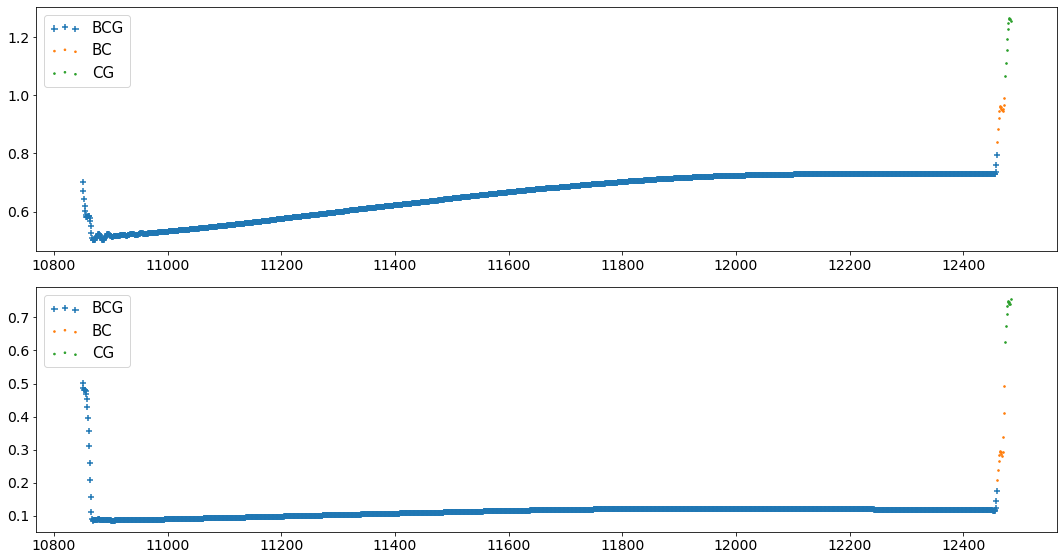


.
.
 2BG.csv
  Fault type Percentage
0        NML     100.0%


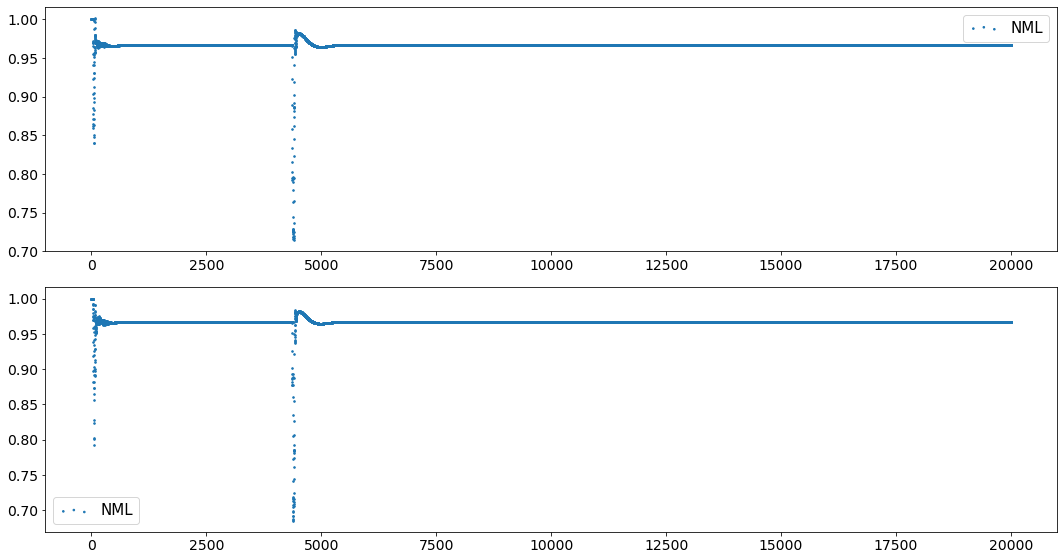


.
.
 6BC.csv
  Fault type Percentage
0        NML     51.69%
1      FAULT     48.31%


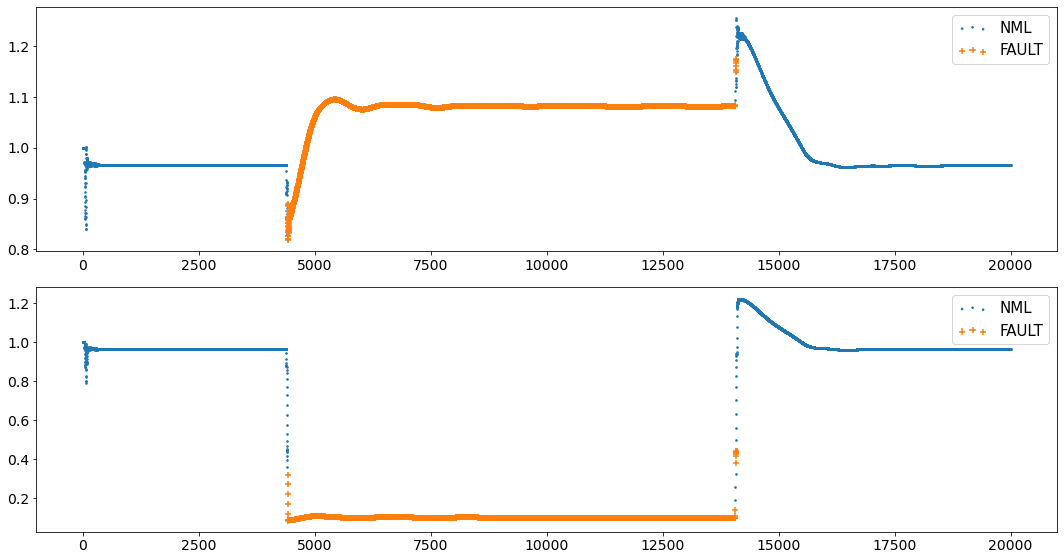

  Fault type Percentage
0         BC     100.0%


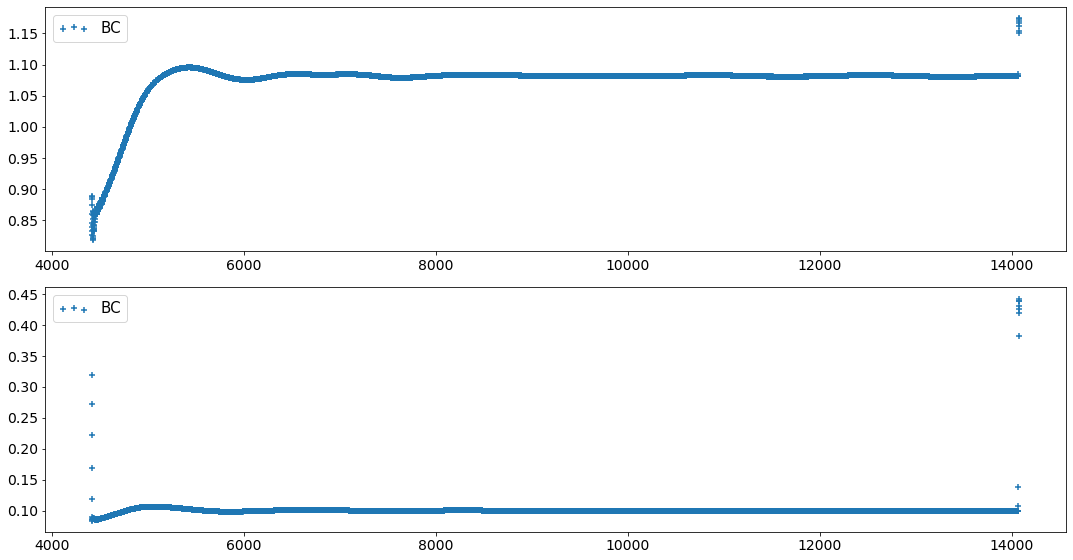


.
.
 6CG.csv
  Fault type Percentage
0        NML     92.95%
1      FAULT      7.04%


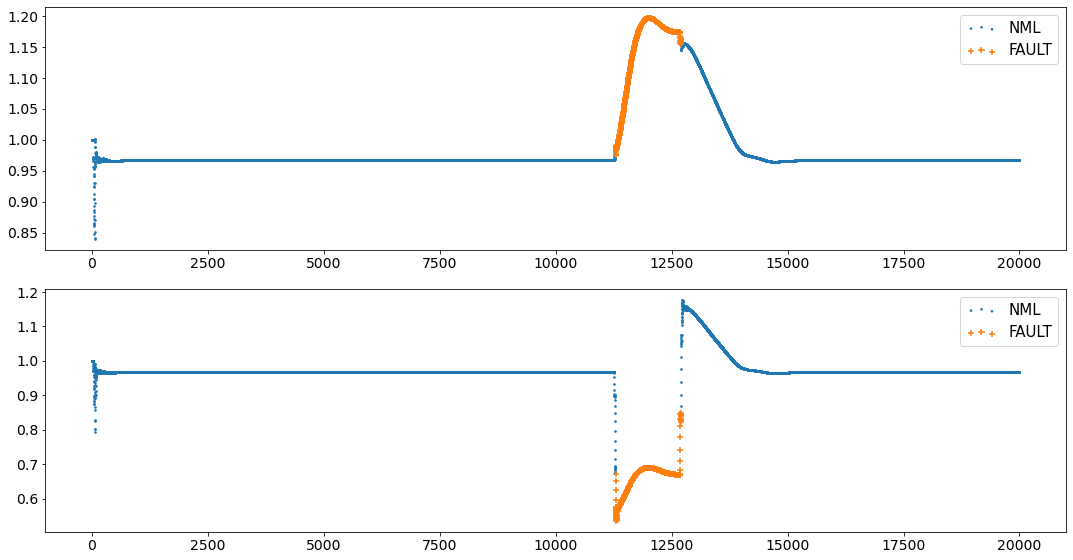

  Fault type Percentage
0         CG     100.0%


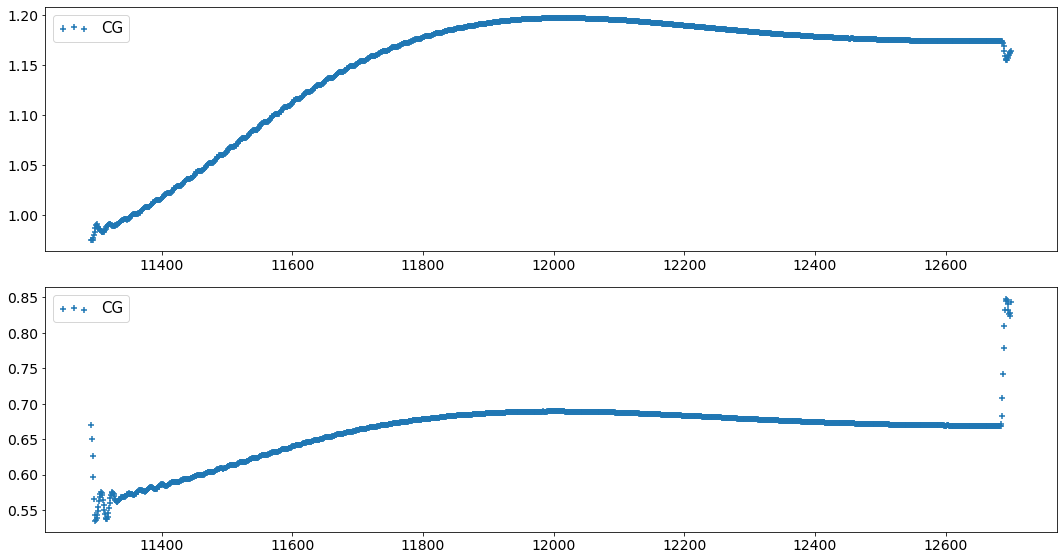


.
.
 7ABCG.csv
  Fault type Percentage
0        NML     77.66%
1      FAULT     22.34%


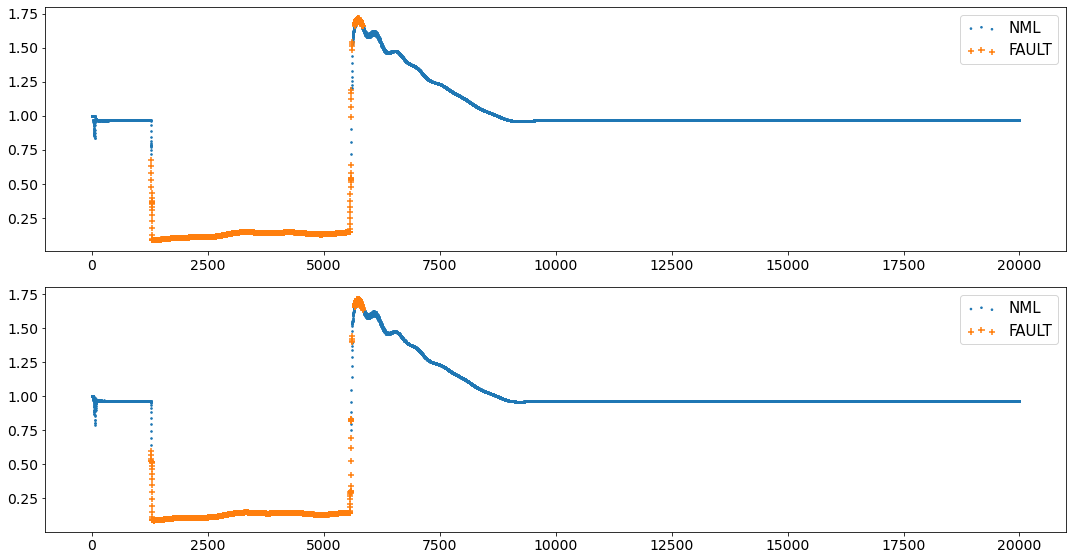

  Fault type Percentage
0       ABCG     95.93%
1        ACG      3.62%
2        BCG       0.2%
3        ABG      0.16%
4         CG      0.09%


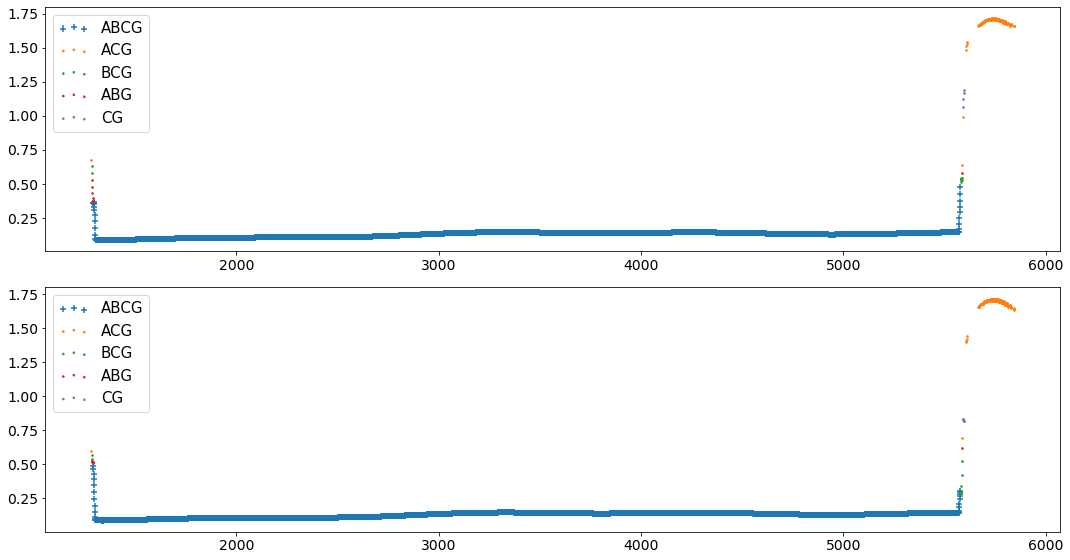


.
.
 9BCG.csv
  Fault type Percentage
0        NML     99.42%
1      FAULT      0.58%


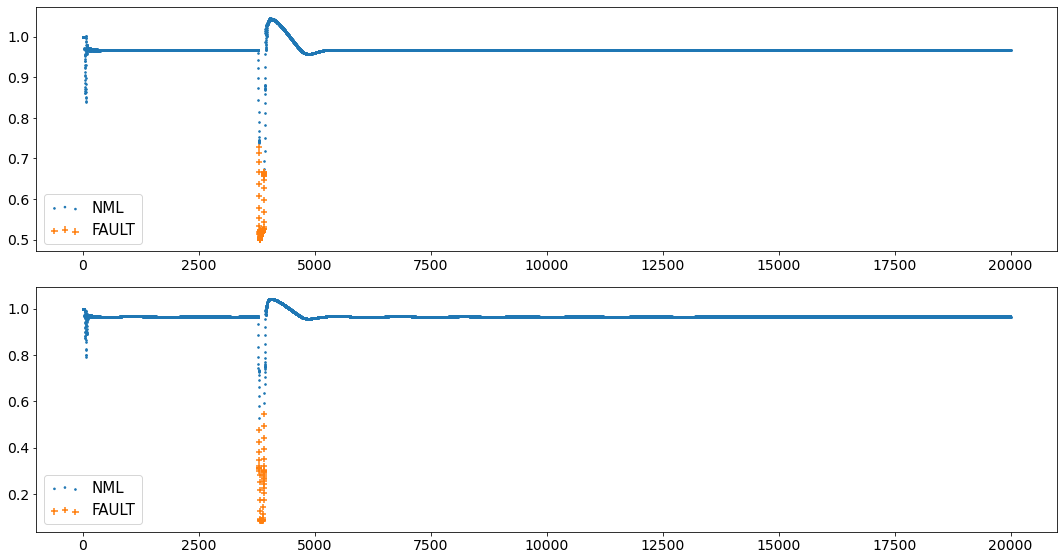

  Fault type Percentage
0        BCG     97.44%
1         BG      2.56%


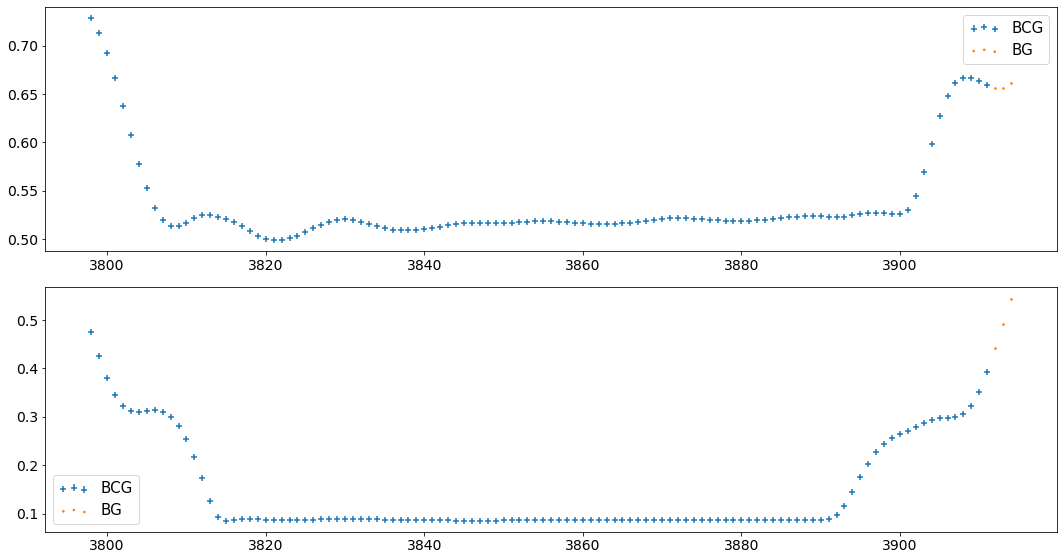


.
.
 10AG.csv
  Fault type Percentage
0        NML     71.72%
1      FAULT     28.28%


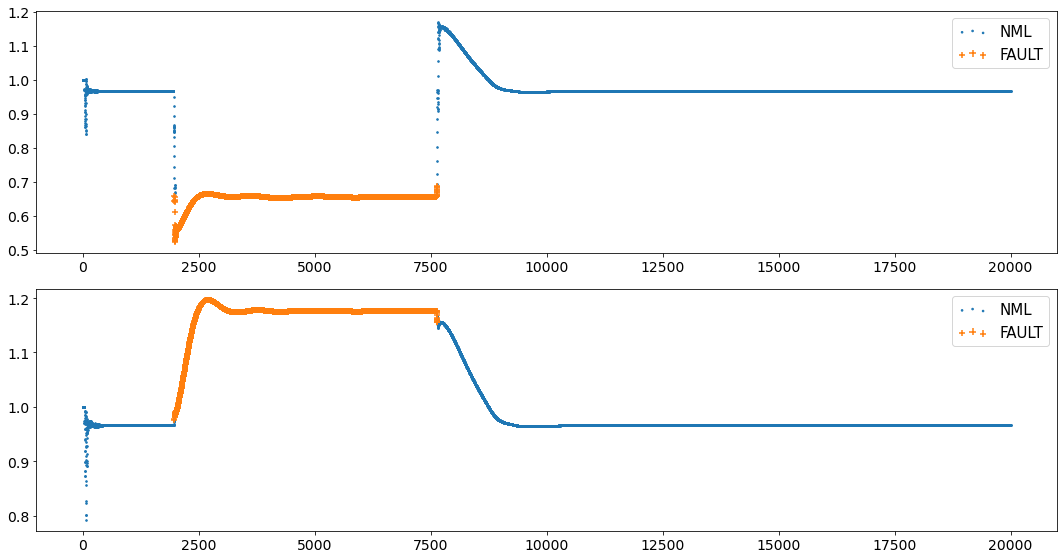

  Fault type Percentage
0         AG     100.0%


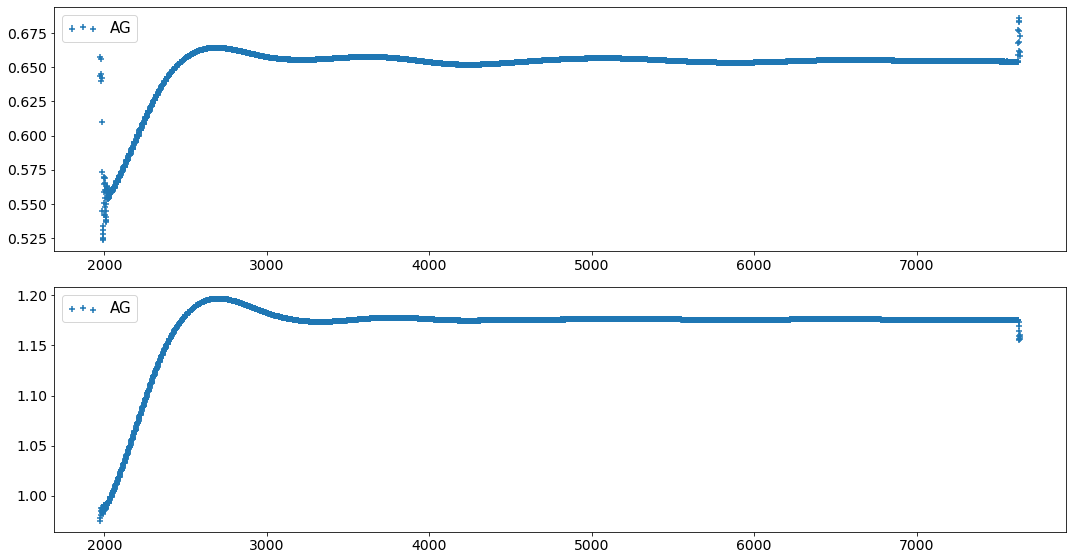


.
.
 3ACG.csv
  Fault type Percentage
0      FAULT     59.13%
1        NML     40.87%


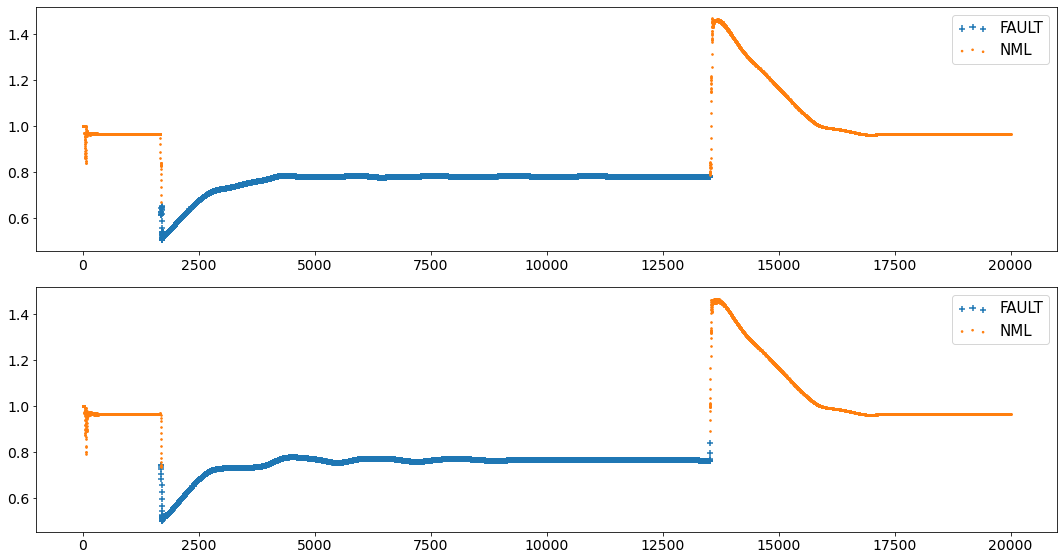

  Fault type Percentage
0        ACG     100.0%


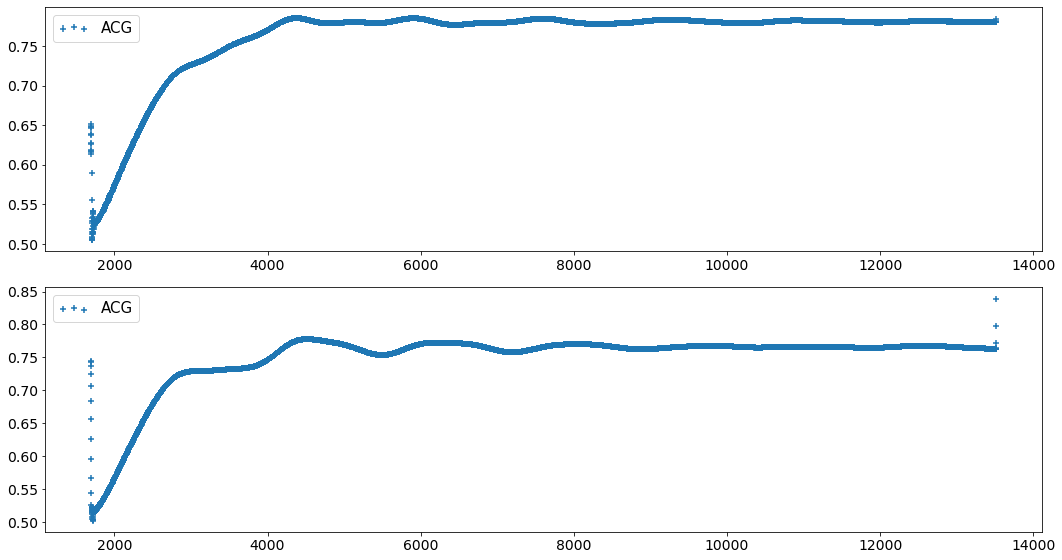


.
.
 8AC.csv
  Fault type Percentage
0        NML     88.02%
1      FAULT     11.98%


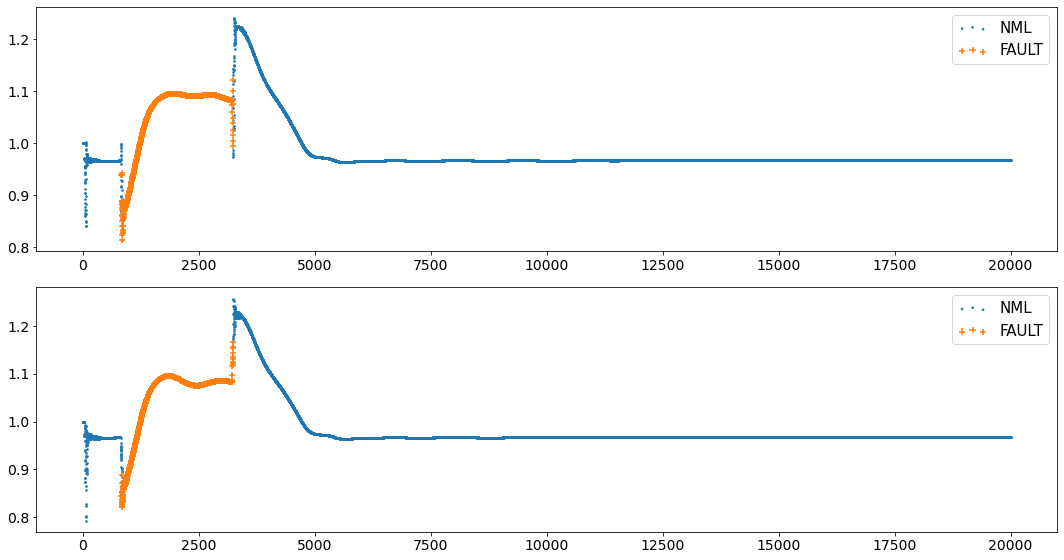

  Fault type Percentage
0         AC     99.83%
1        ACG      0.17%


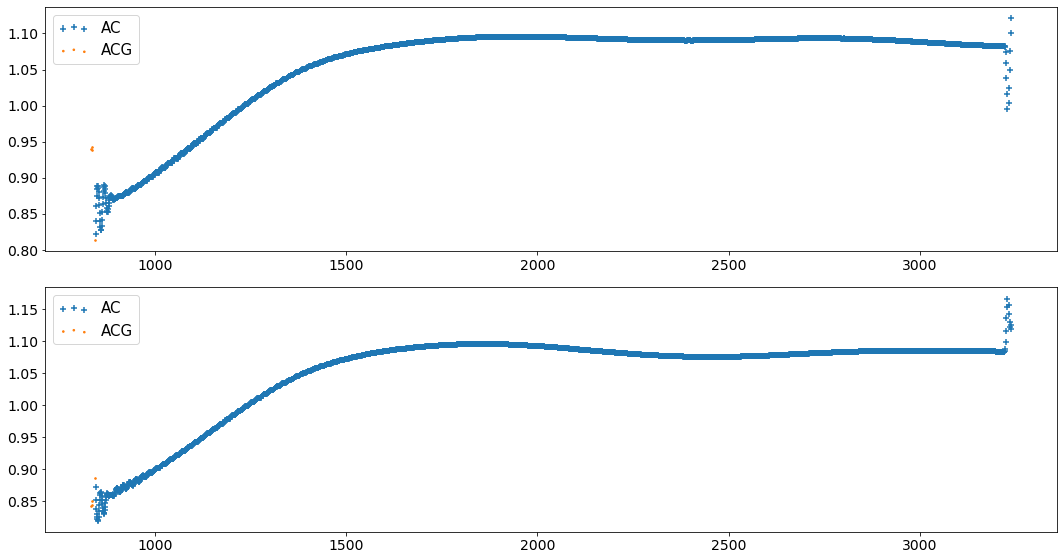


.
.
 4BC.csv
  Fault type Percentage
0        NML     96.38%
1      FAULT      3.62%


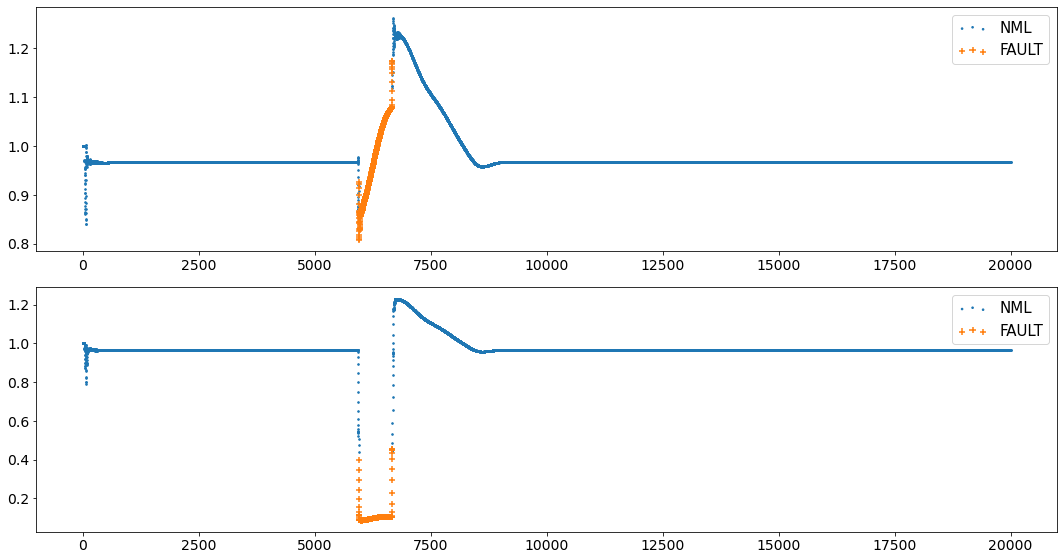

  Fault type Percentage
0         BC     100.0%


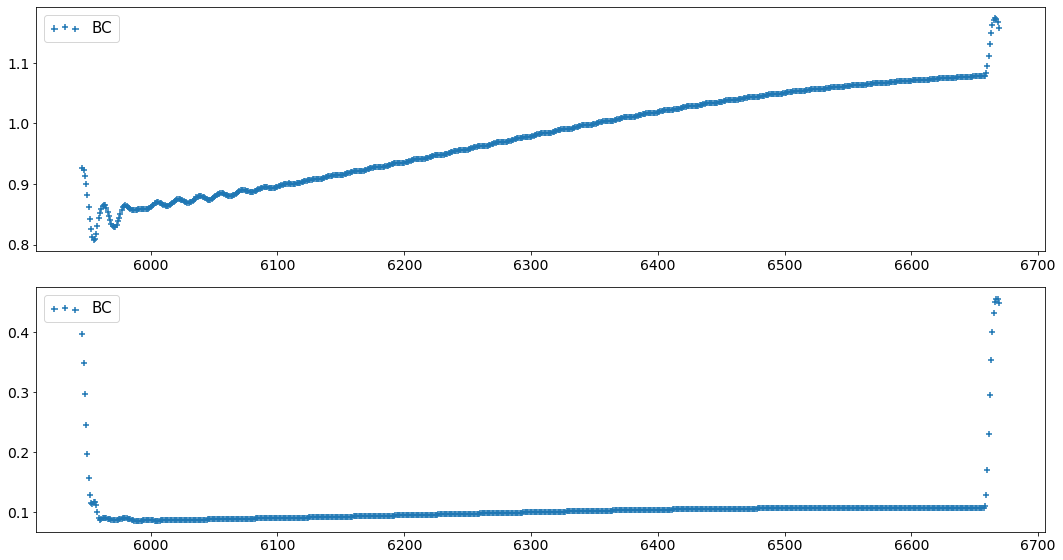


.
.
 4CG.csv
  Fault type Percentage
0        NML     73.92%
1      FAULT     26.08%


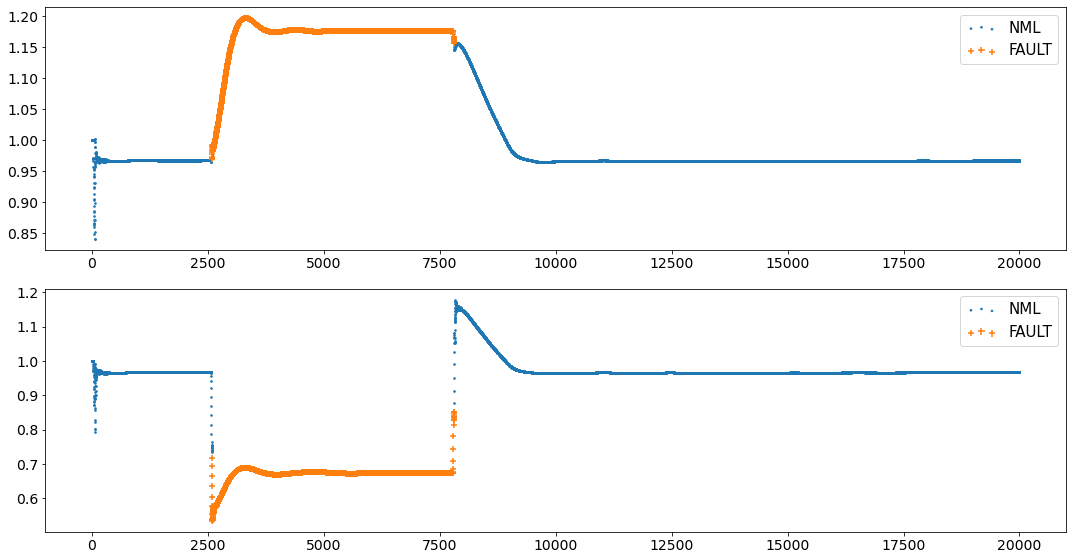

  Fault type Percentage
0         CG     100.0%


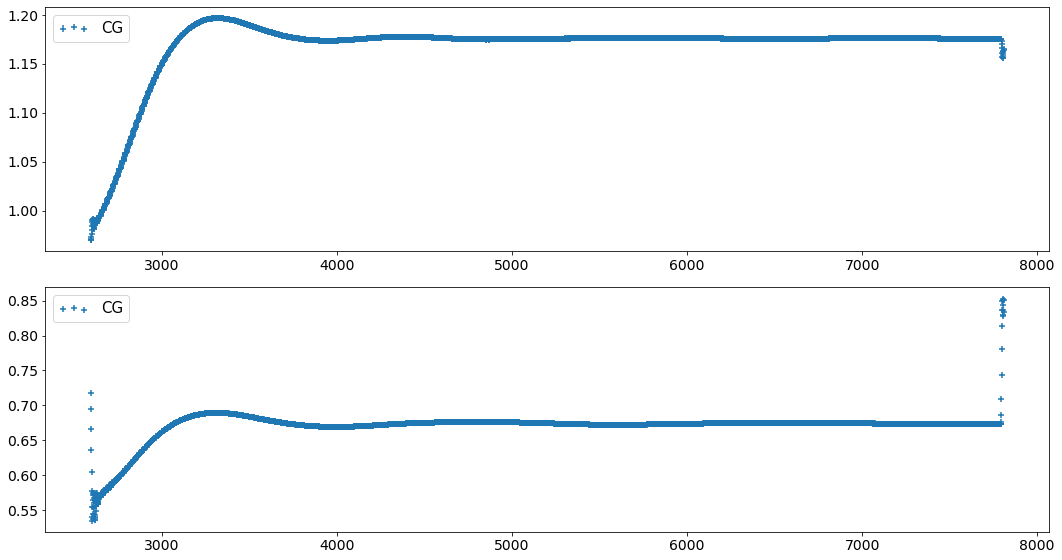


.
.
 1ABG.csv
  Fault type Percentage
0        NML     80.98%
1      FAULT     19.02%


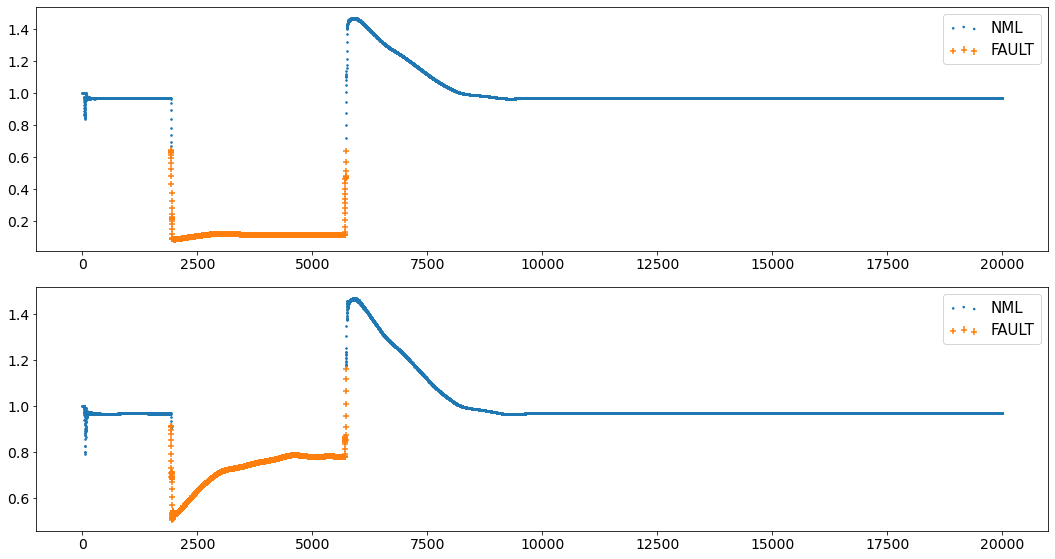

  Fault type Percentage
0        ABG     99.55%
1         AB      0.24%
2         AG      0.21%


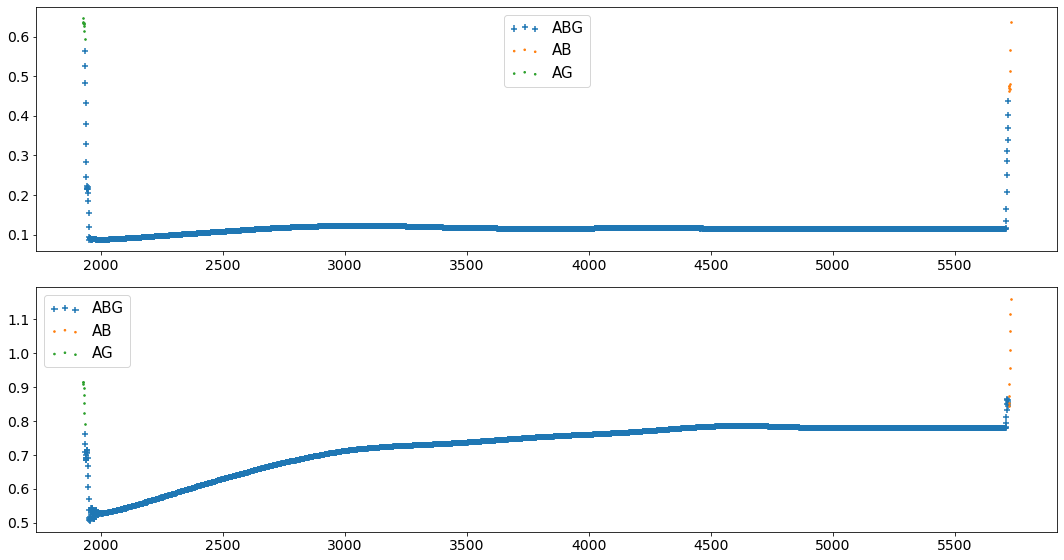


.
.
 8AB.csv
  Fault type Percentage
0        NML     94.12%
1      FAULT      5.88%


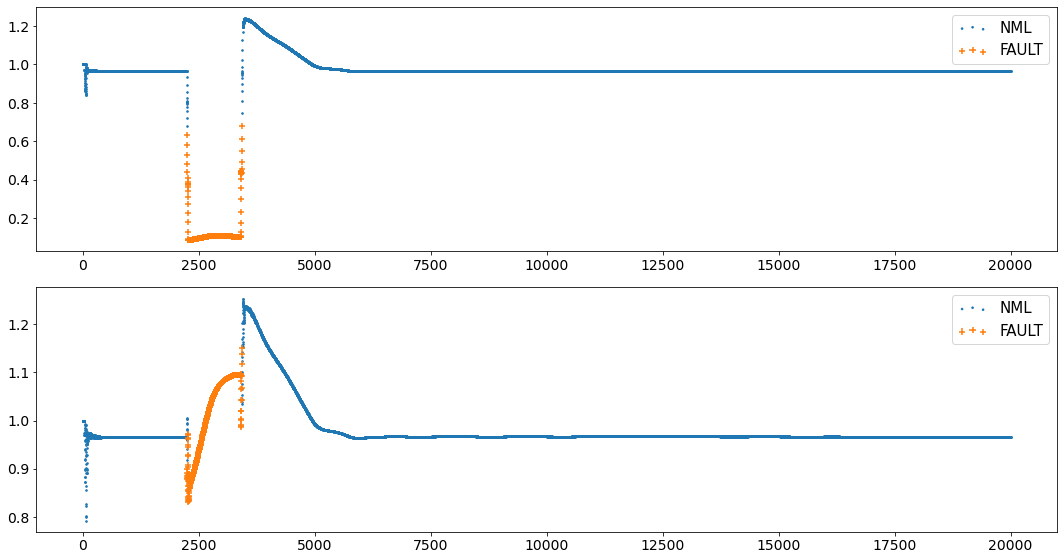

  Fault type Percentage
0         AB     99.23%
1        ABG       0.6%
2         BG      0.17%


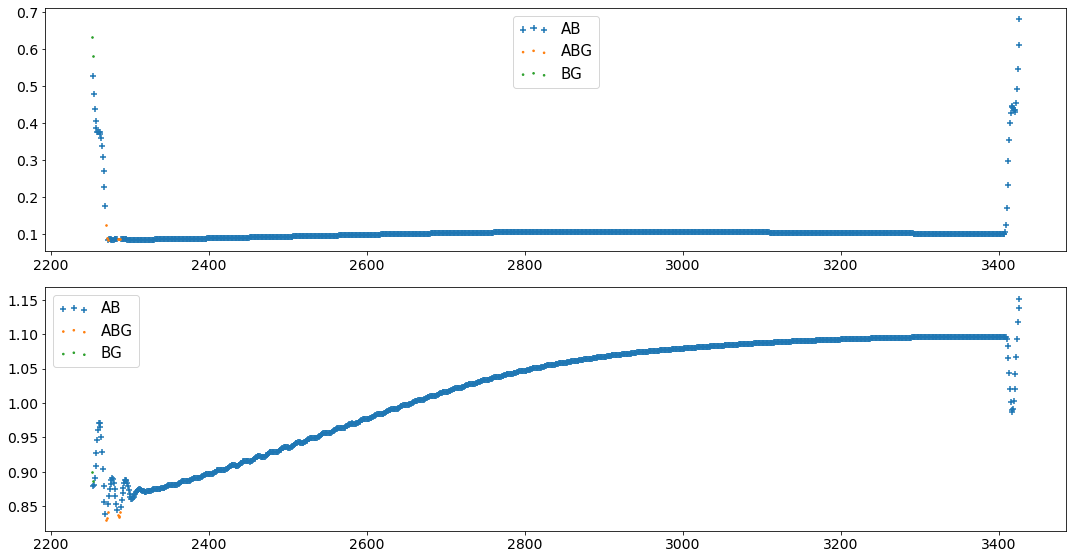


.
.
 10BCG.csv
  Fault type Percentage
0        NML     89.28%
1      FAULT     10.71%


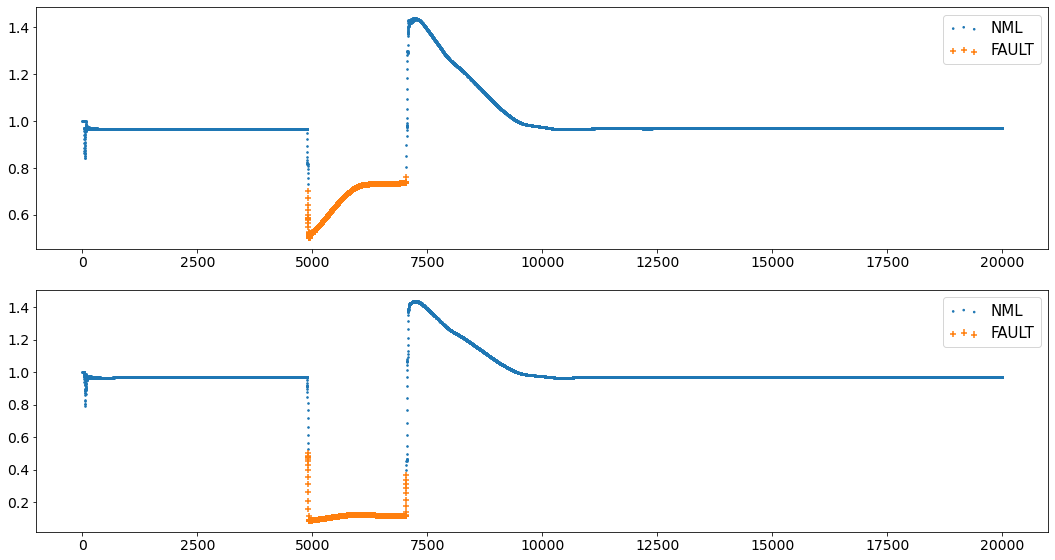

  Fault type Percentage
0        BCG     99.86%
1         BC      0.14%


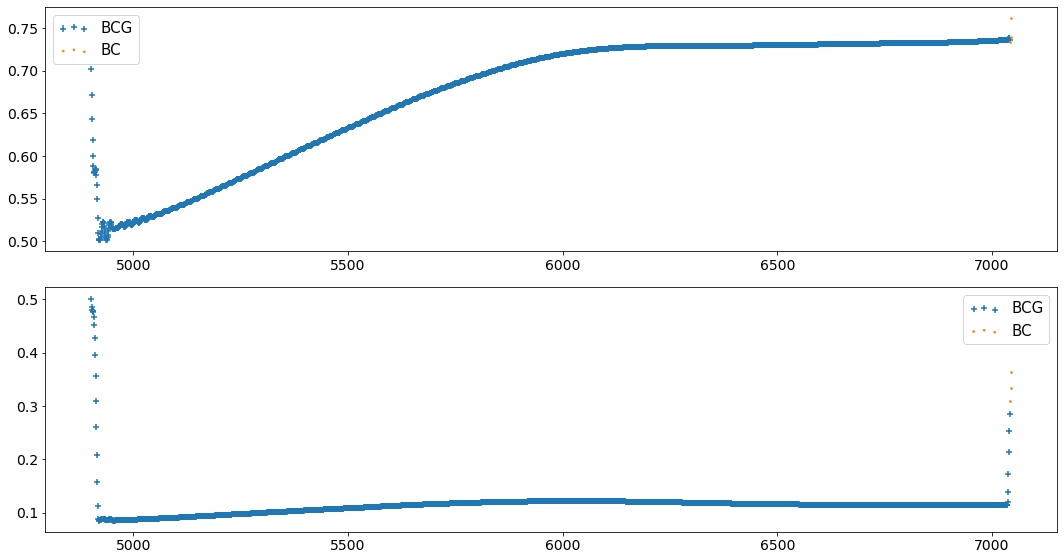


.
.
 8CG.csv
  Fault type Percentage
0        NML      96.8%
1      FAULT      3.21%


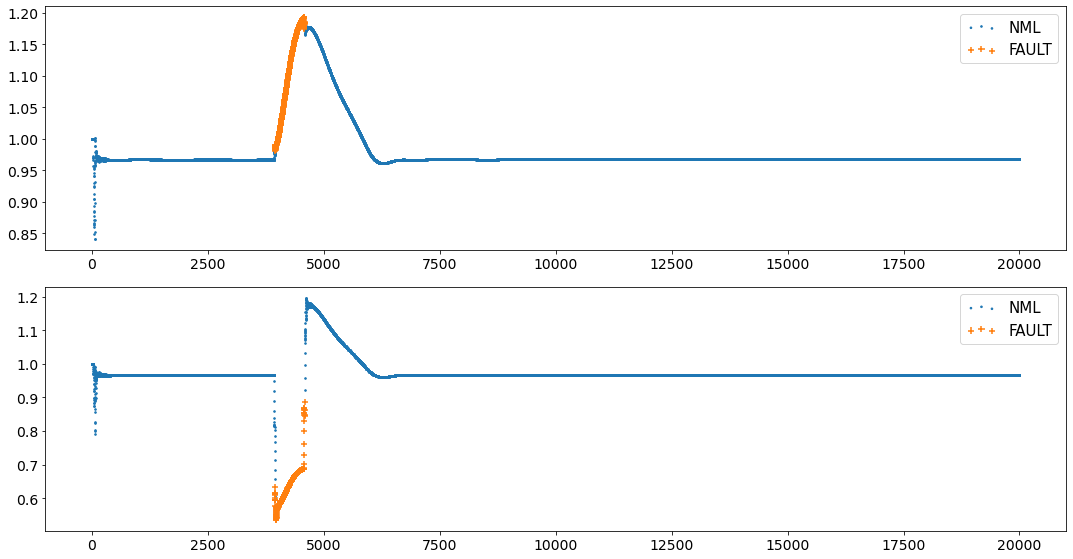

  Fault type Percentage
0         CG     100.0%


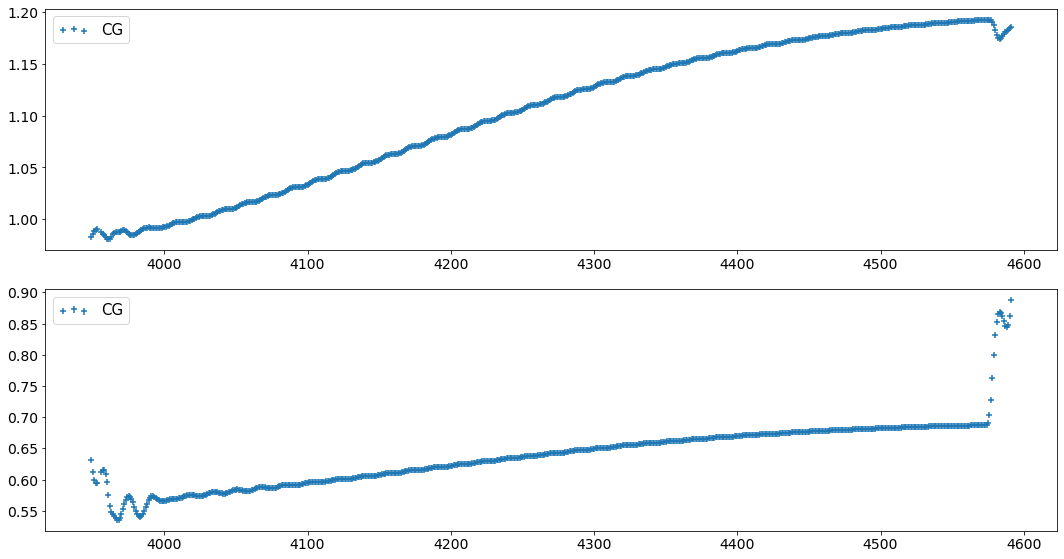


.
.
 8BC.csv
  Fault type Percentage
0        NML     93.67%
1      FAULT      6.33%


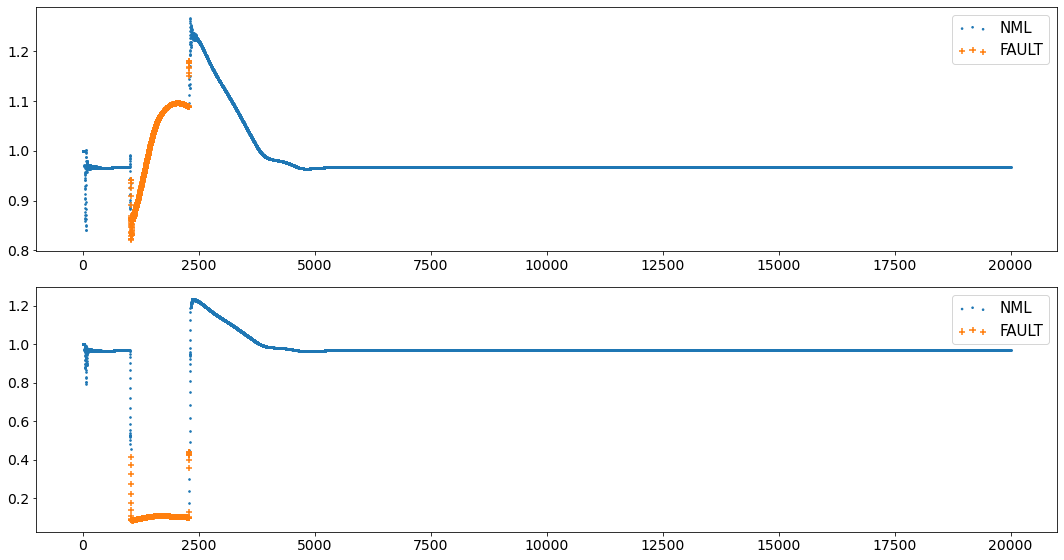

  Fault type Percentage
0         BC     100.0%


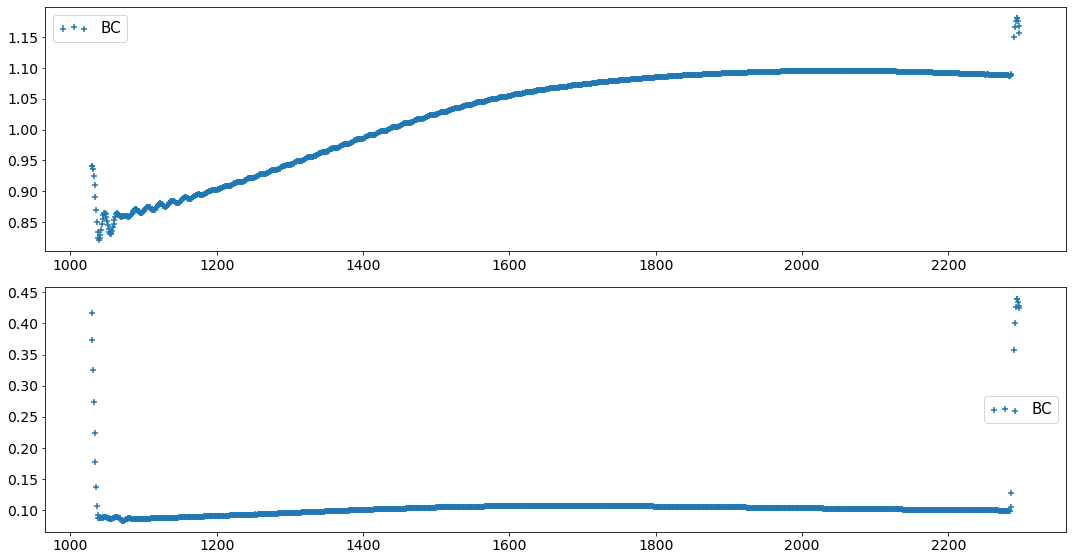


.
.
 4AB.csv
  Fault type Percentage
0        NML     91.66%
1      FAULT      8.34%


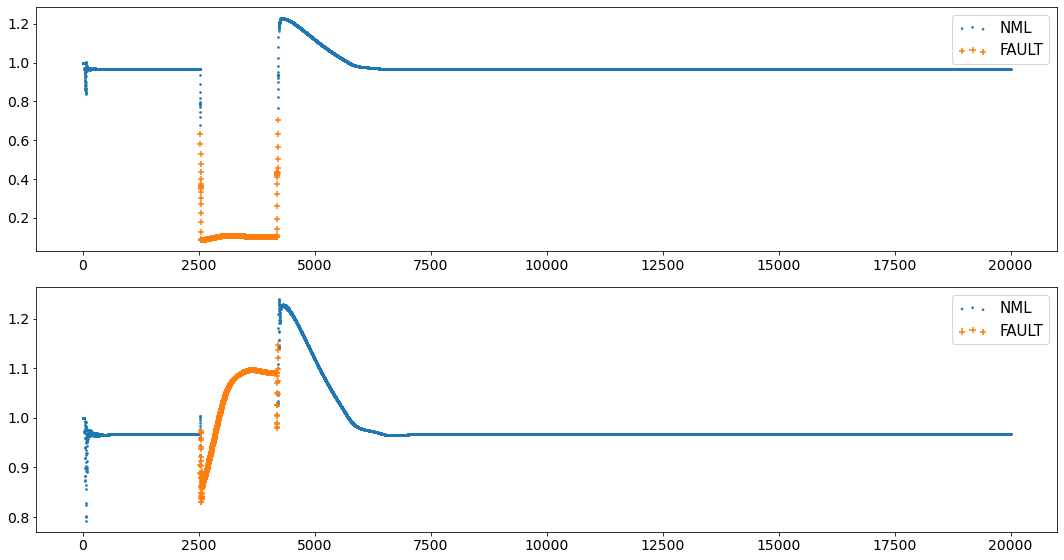

  Fault type Percentage
0         AB     99.46%
1        ABG      0.42%
2         BG      0.06%
3         AG      0.06%


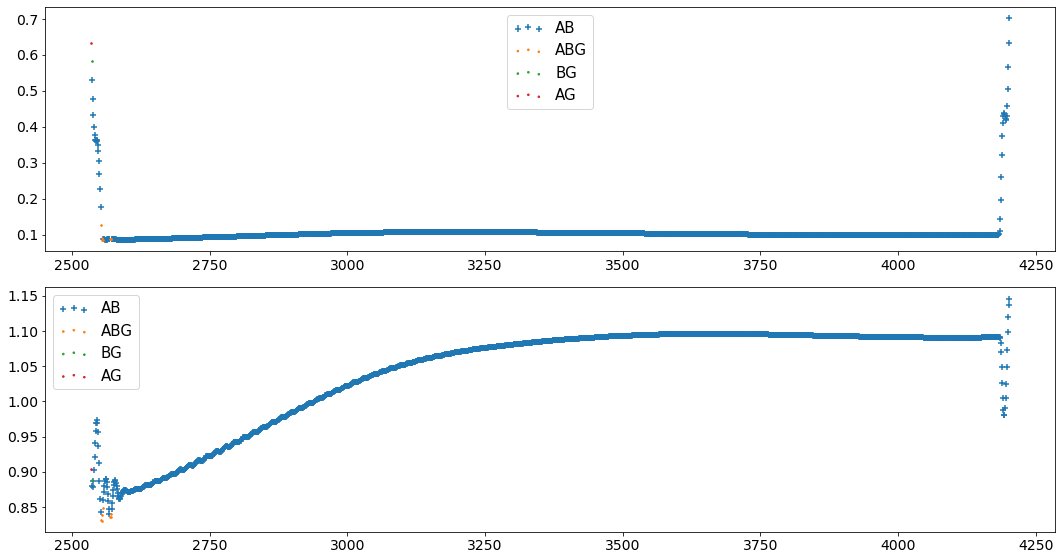


.
.
 6ACG.csv
  Fault type Percentage
0        NML     74.05%
1      FAULT     25.95%


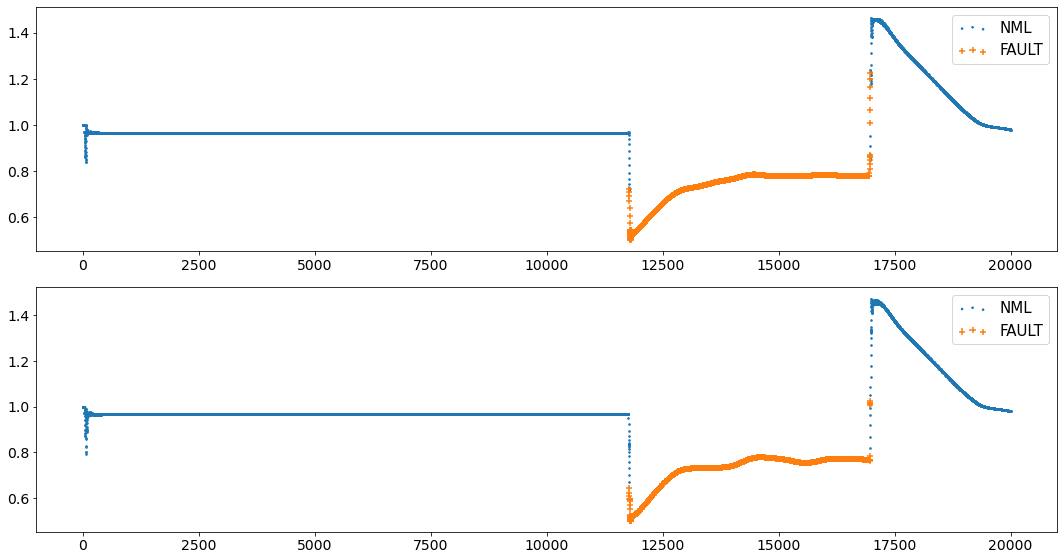

  Fault type Percentage
0        ACG     99.88%
1         AC       0.1%
2         CG      0.02%


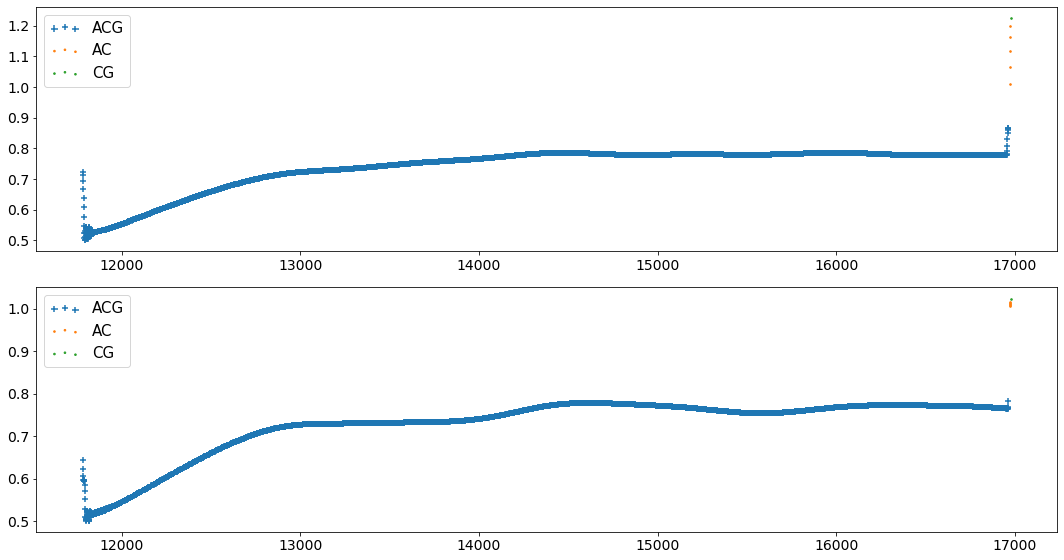


.
.
 8ABG.csv
  Fault type Percentage
0        NML     94.92%
1      FAULT      5.08%


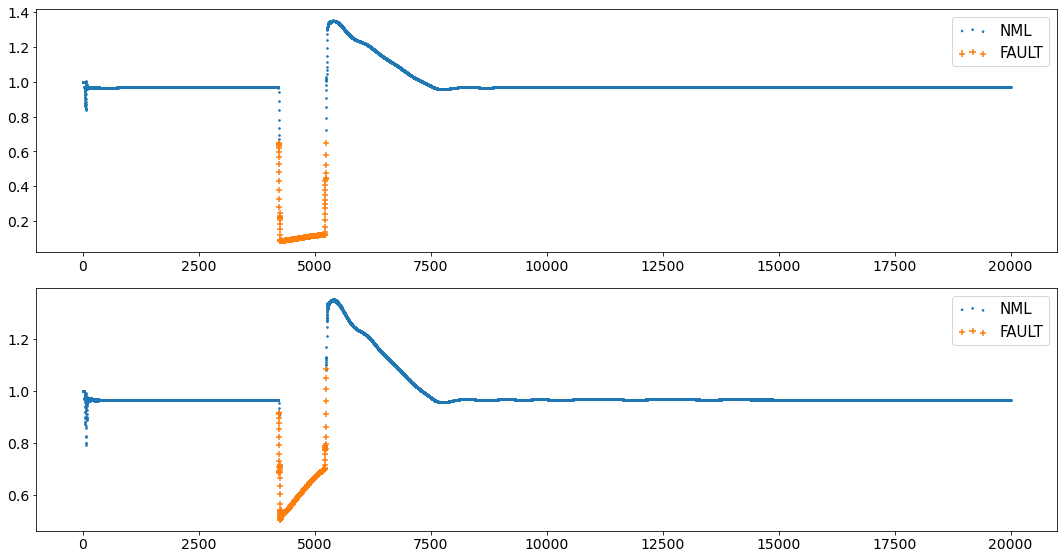

  Fault type Percentage
0        ABG     98.52%
1         AG      0.89%
2         AB      0.59%


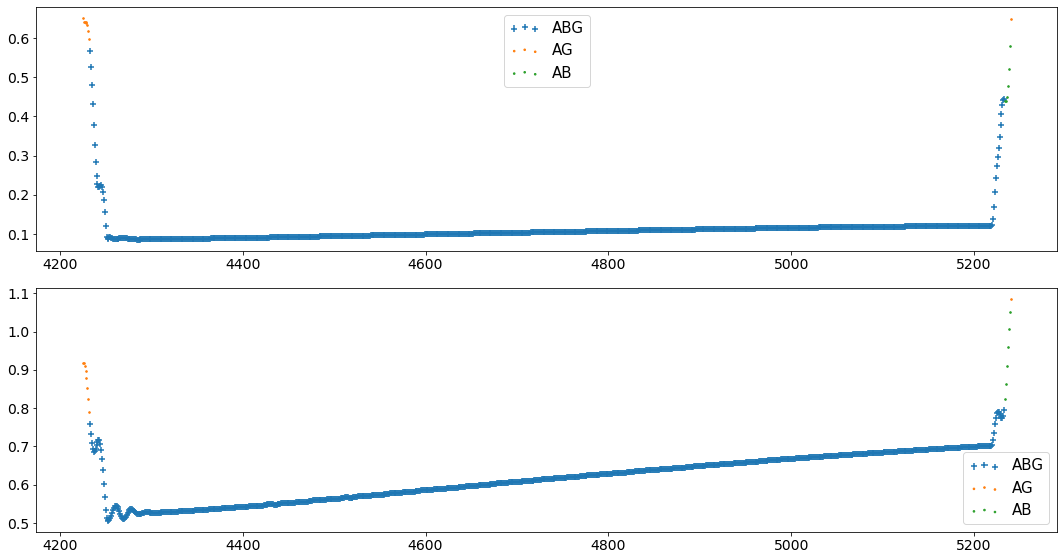


.
.
 4AC.csv
  Fault type Percentage
0        NML     88.22%
1      FAULT     11.78%


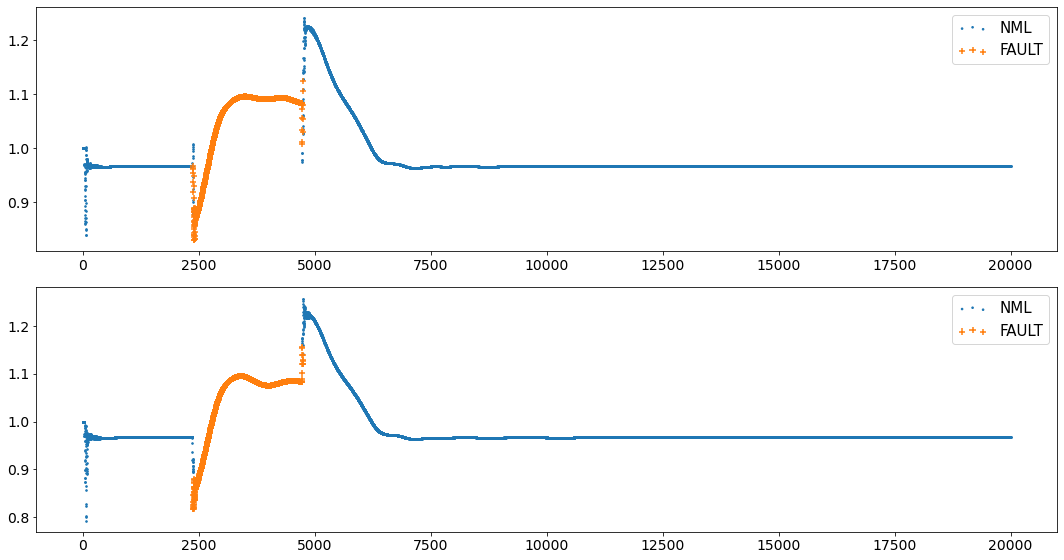

  Fault type Percentage
0         AC     99.49%
1        ACG      0.51%


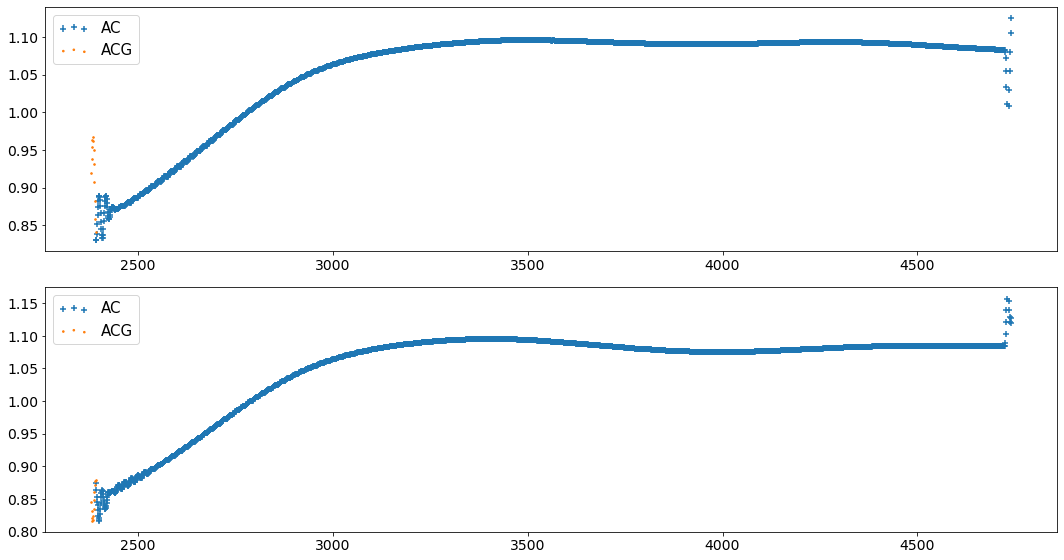


.
.
 4ABG.csv
  Fault type Percentage
0        NML     98.91%
1      FAULT      1.09%


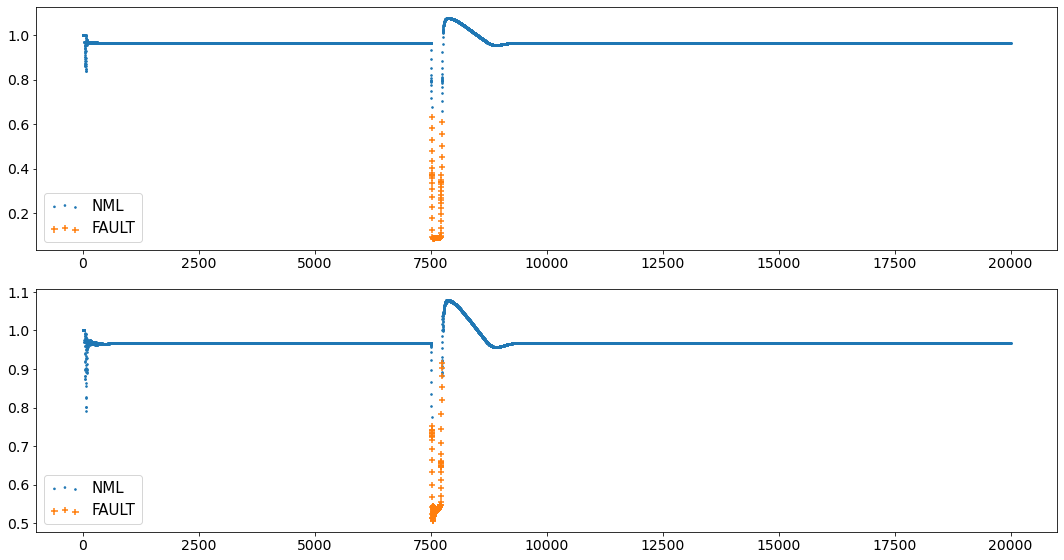

  Fault type Percentage
0        ABG     98.17%
1         AG      1.83%


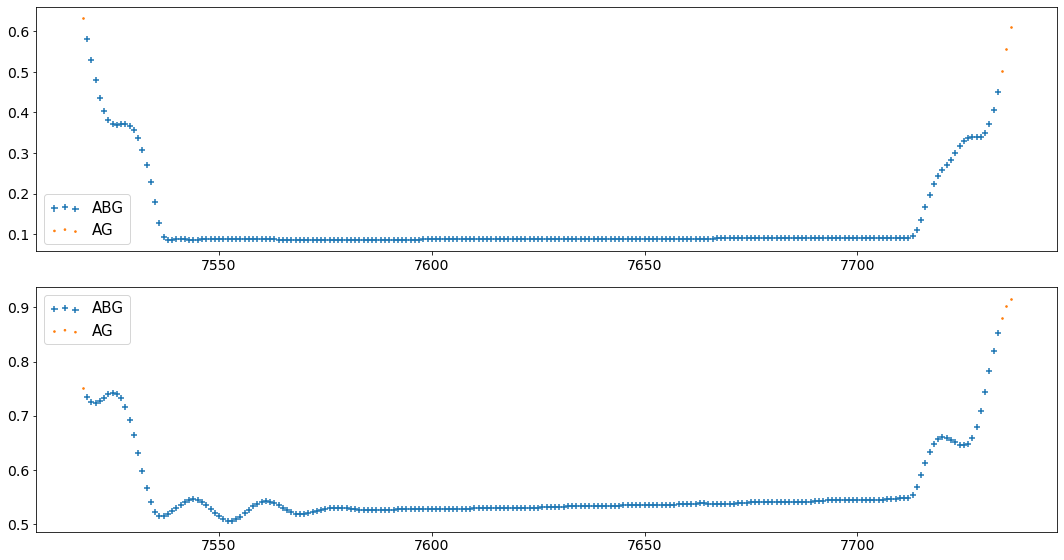


.
.
 2AG.csv
  Fault type Percentage
0        NML     98.67%
1      FAULT      1.32%


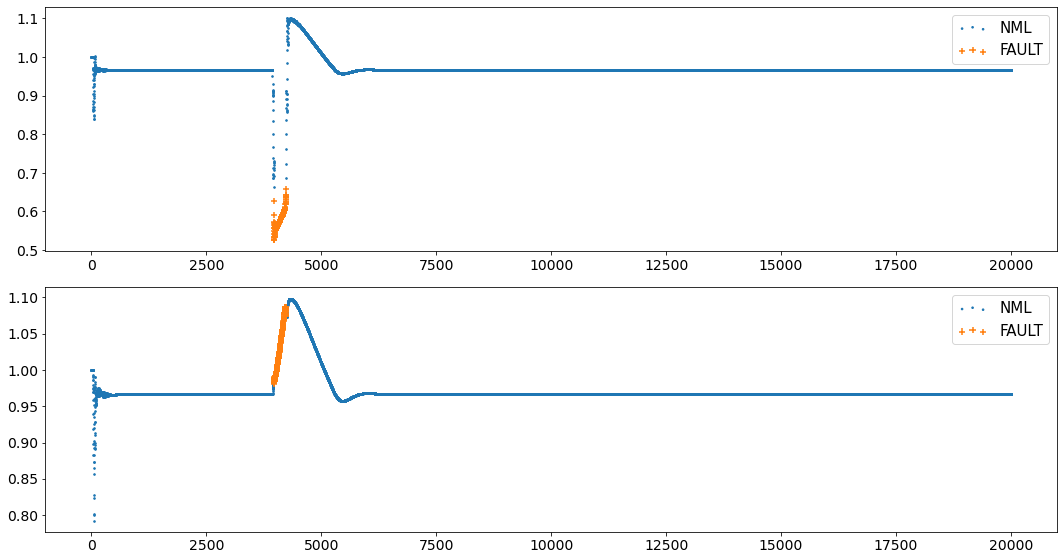

  Fault type Percentage
0         AG     100.0%


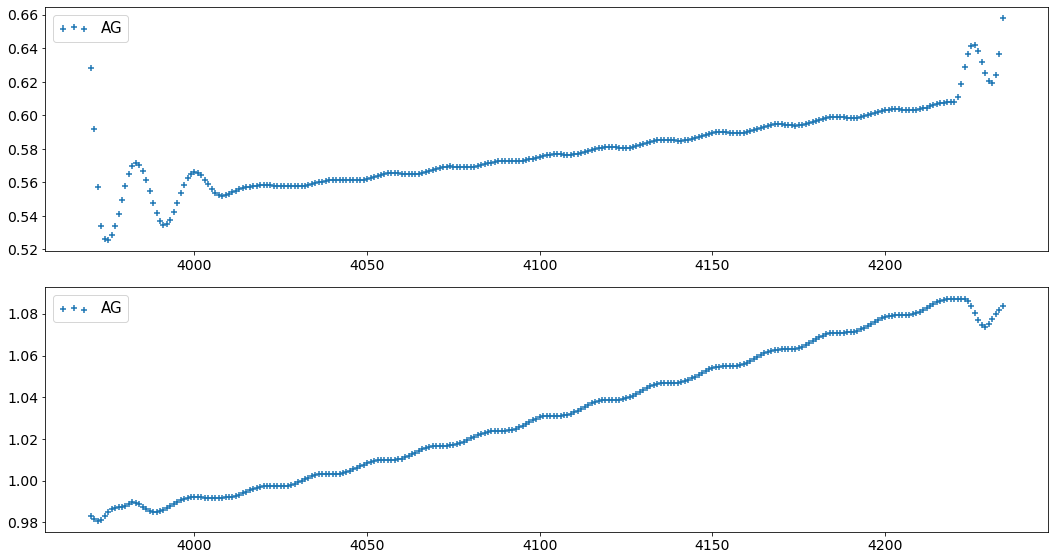


.
.
 6AC.csv
  Fault type Percentage
0        NML     93.29%
1      FAULT      6.71%


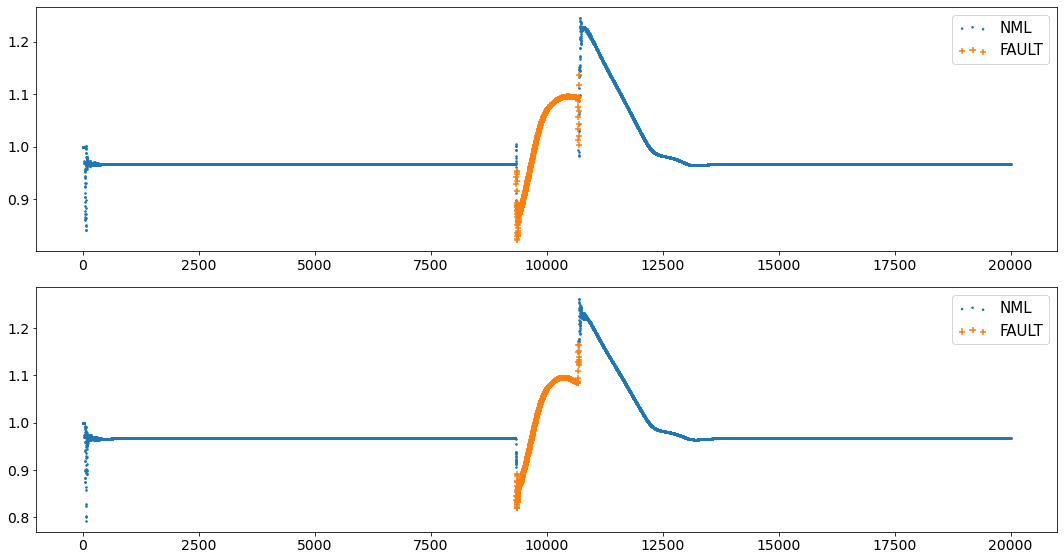

  Fault type Percentage
0         AC     99.25%
1        ACG      0.75%


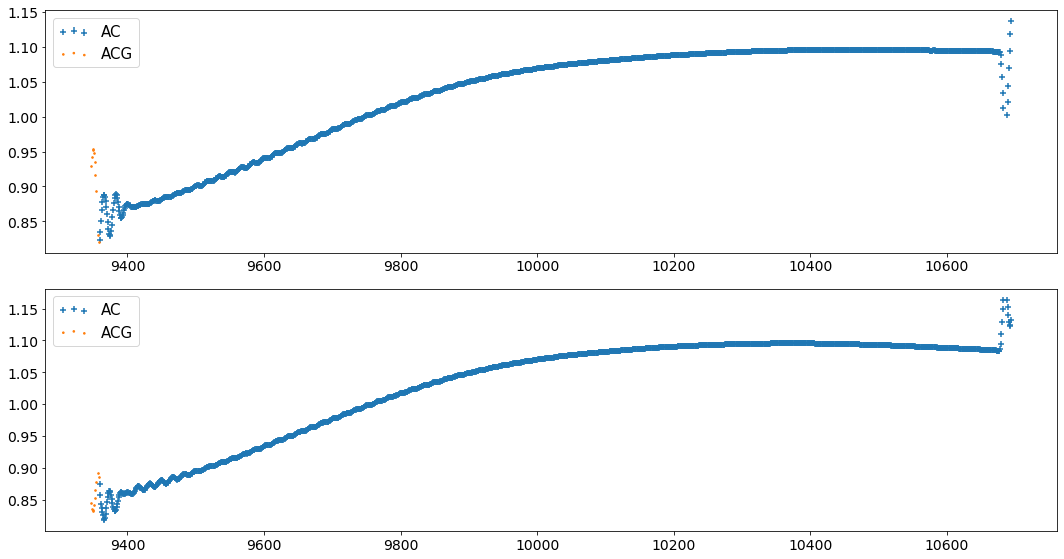


.
.
 6AB.csv
  Fault type Percentage
0        NML     65.58%
1      FAULT     34.41%


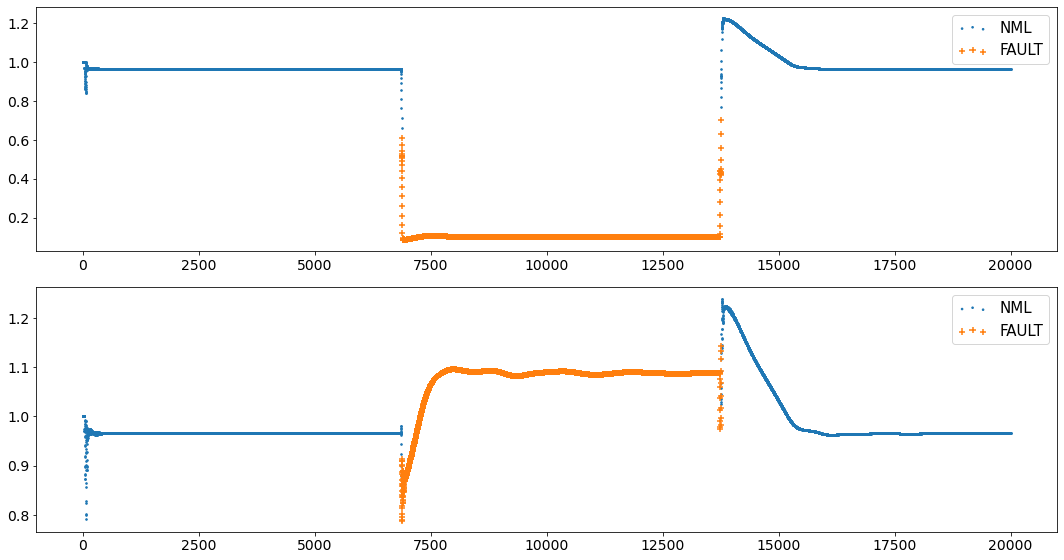

  Fault type Percentage
0         AB     99.77%
1        ABG      0.19%
2         BG      0.04%


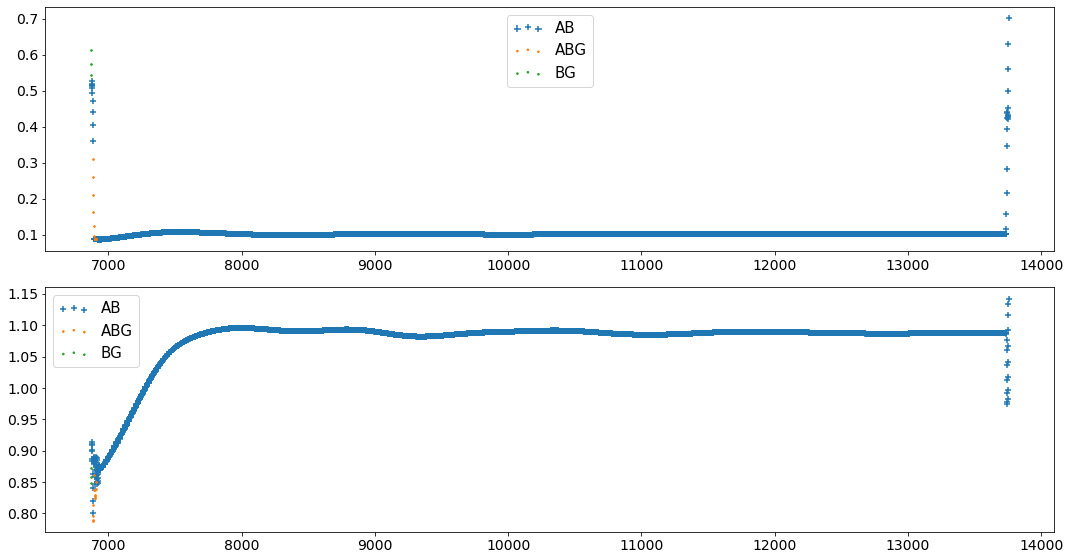


.
.
 2ABCG.csv
  Fault type Percentage
0        NML     90.34%
1      FAULT      9.65%


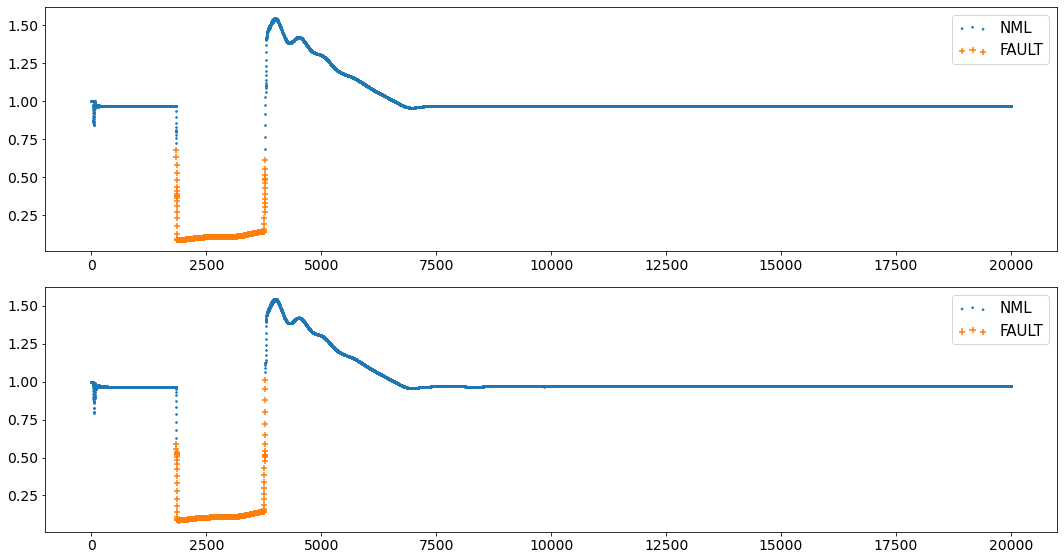

  Fault type Percentage
0       ABCG     98.76%
1        ABG      0.93%
2         AG      0.16%
3        BCG       0.1%
4        ACG      0.05%


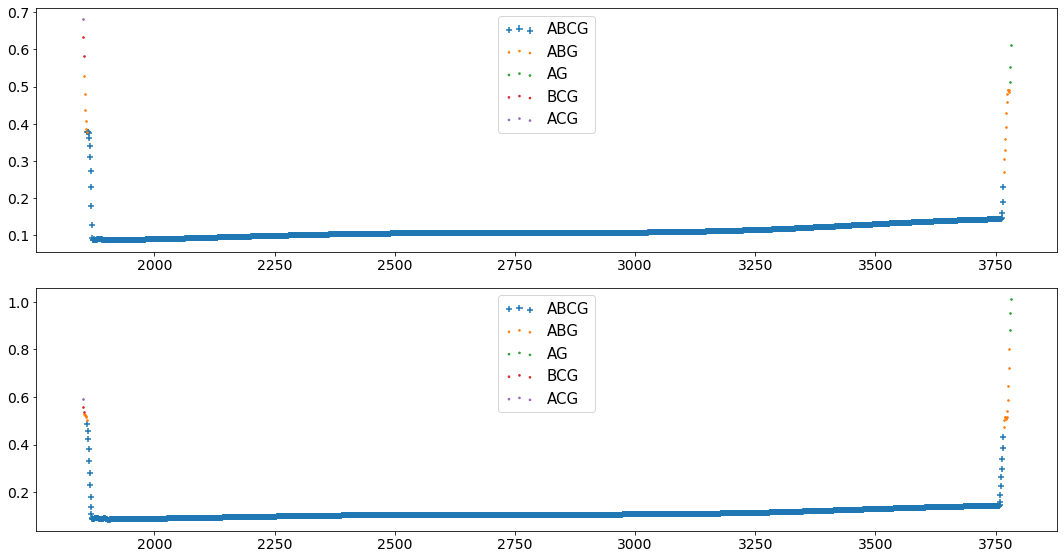


.
.
 10BG.csv
  Fault type Percentage
0        NML     97.57%
1      FAULT      2.43%


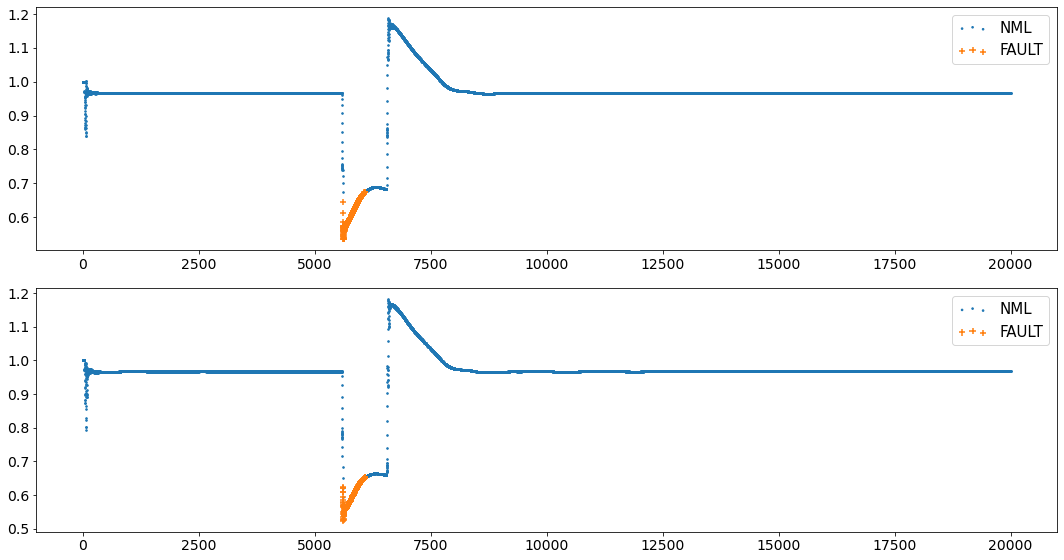

  Fault type Percentage
0         BG     100.0%


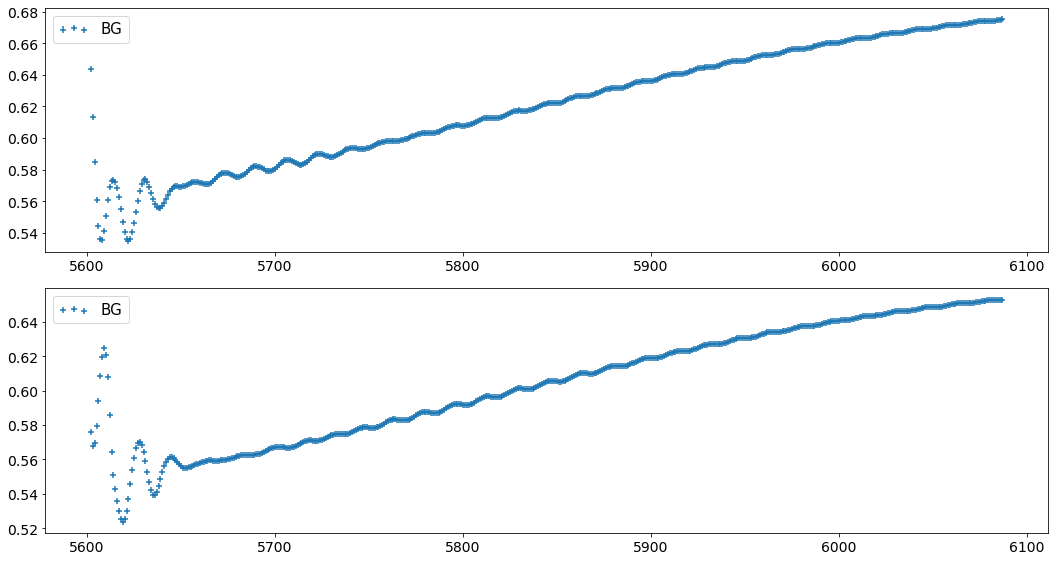


.
.
 2AB.csv
  Fault type Percentage
0        NML     99.27%
1      FAULT      0.73%


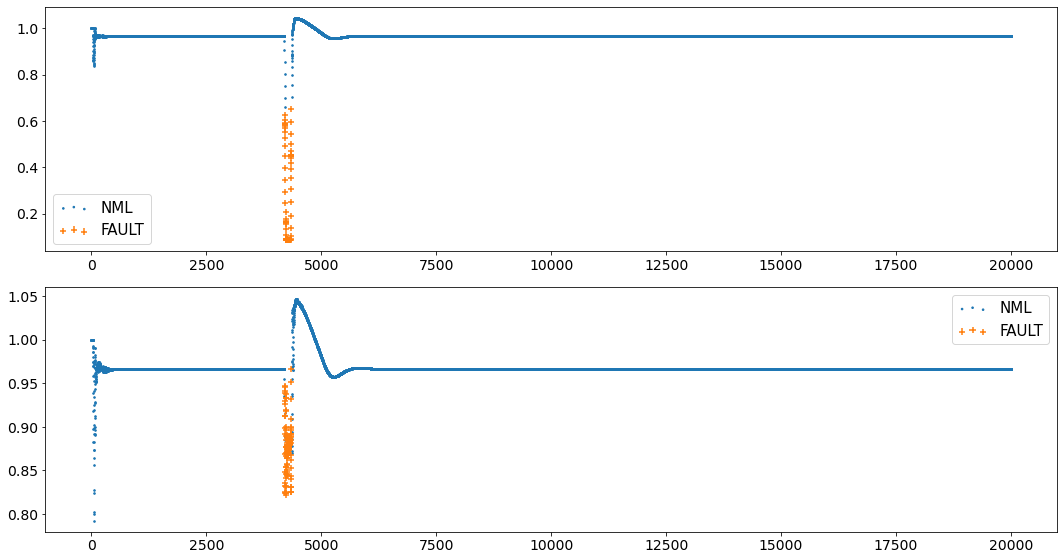

  Fault type Percentage
0         AB     87.76%
1         AG      6.12%
2        ABG      4.76%
3         BG      1.36%


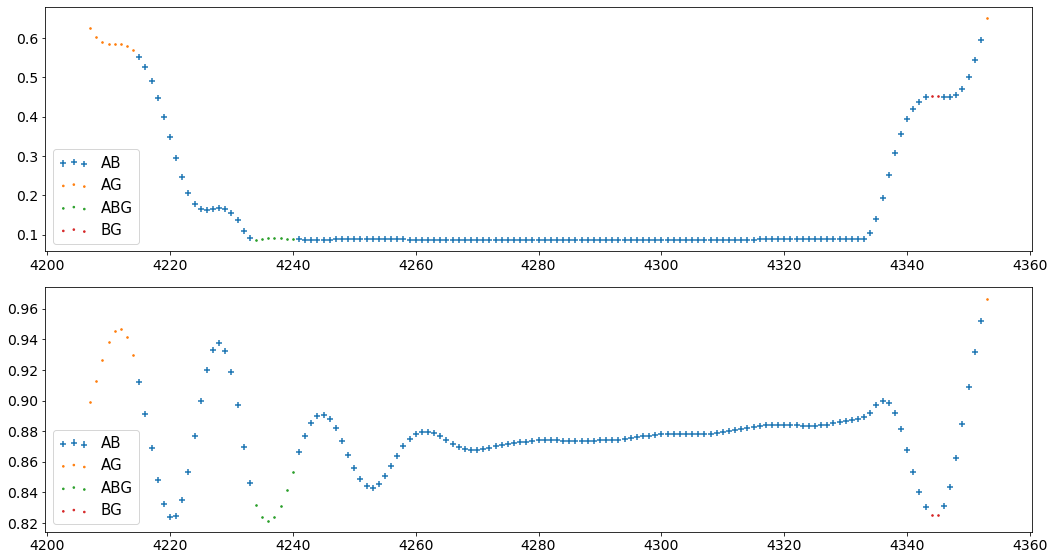


.
.
 2BCG.csv
  Fault type Percentage
0        NML     97.88%
1      FAULT      2.12%


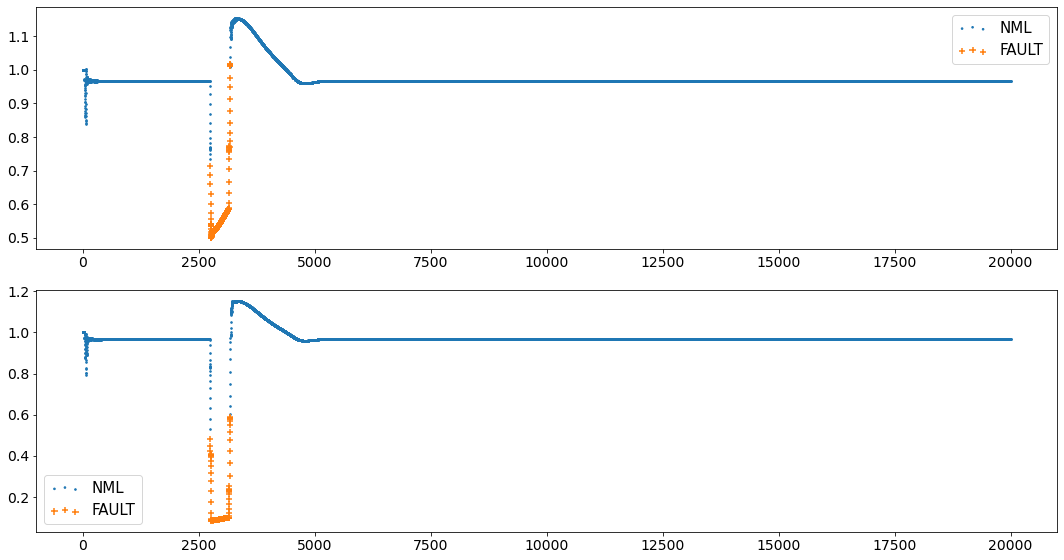

  Fault type Percentage
0        BCG     97.65%
1         CG      2.35%


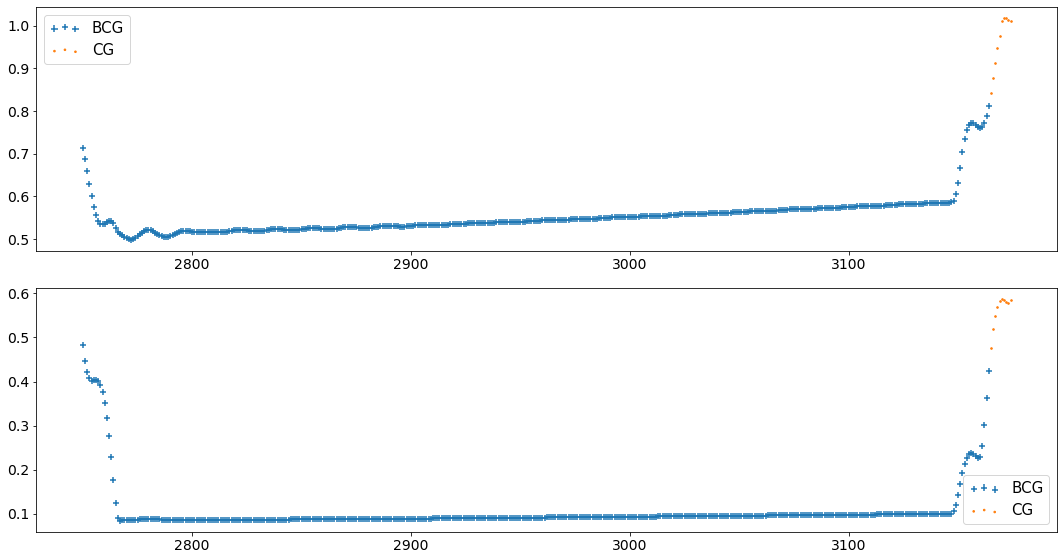


.
.
 10BC.csv
  Fault type Percentage
0        NML     85.77%
1      FAULT     14.23%


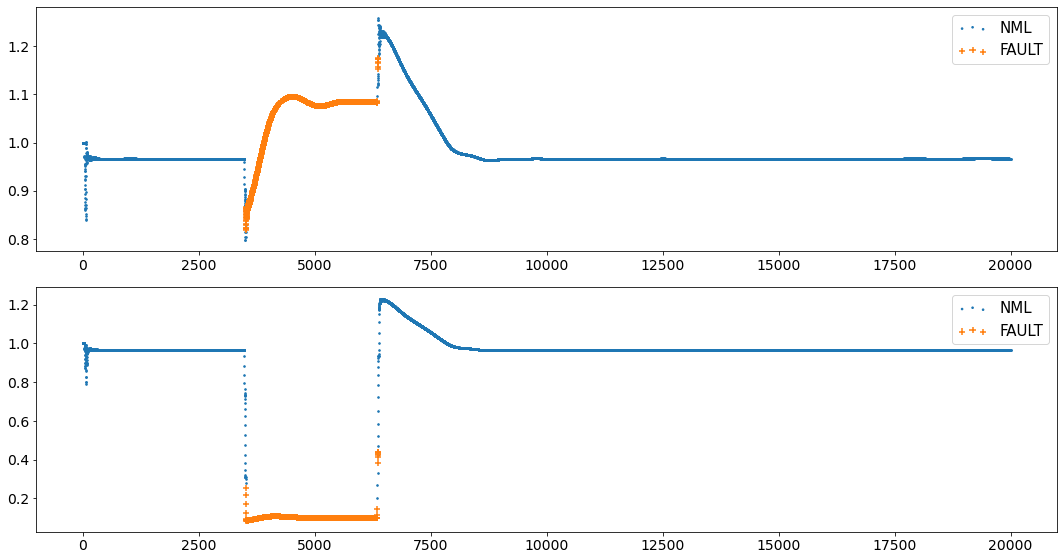

  Fault type Percentage
0         BC     100.0%


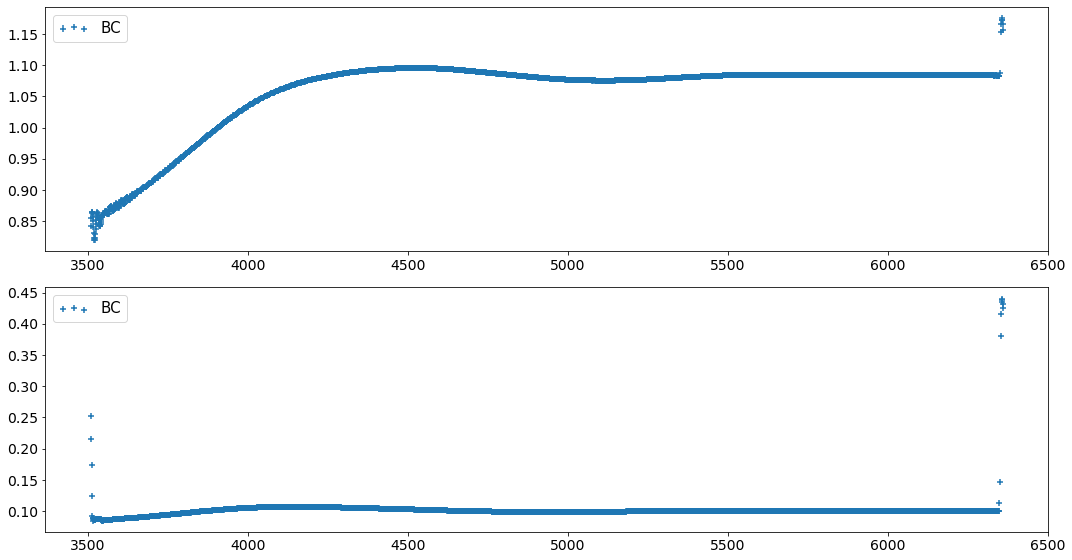


.
.
 10CG.csv
  Fault type Percentage
0        NML     99.39%
1      FAULT       0.6%


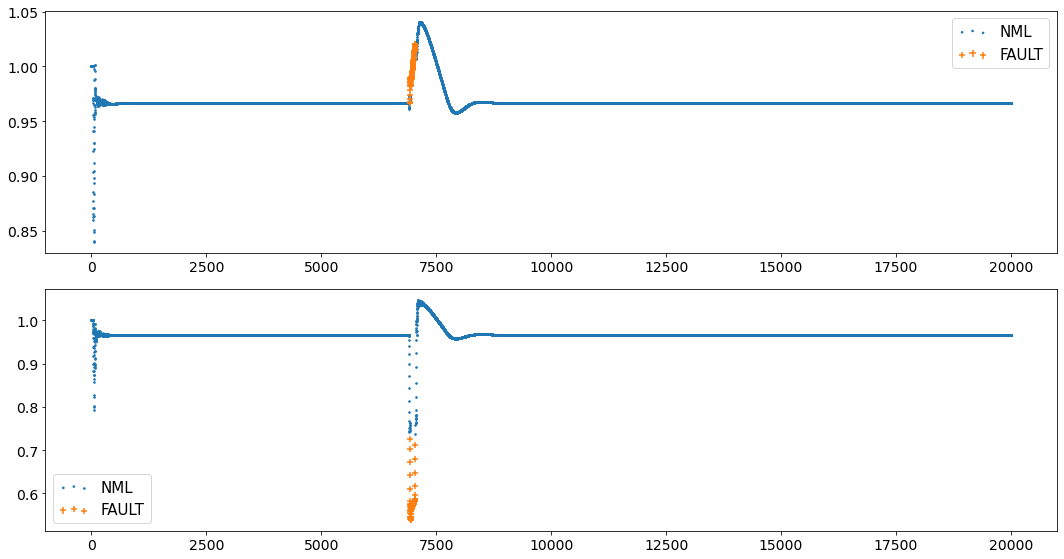

  Fault type Percentage
0         CG     100.0%


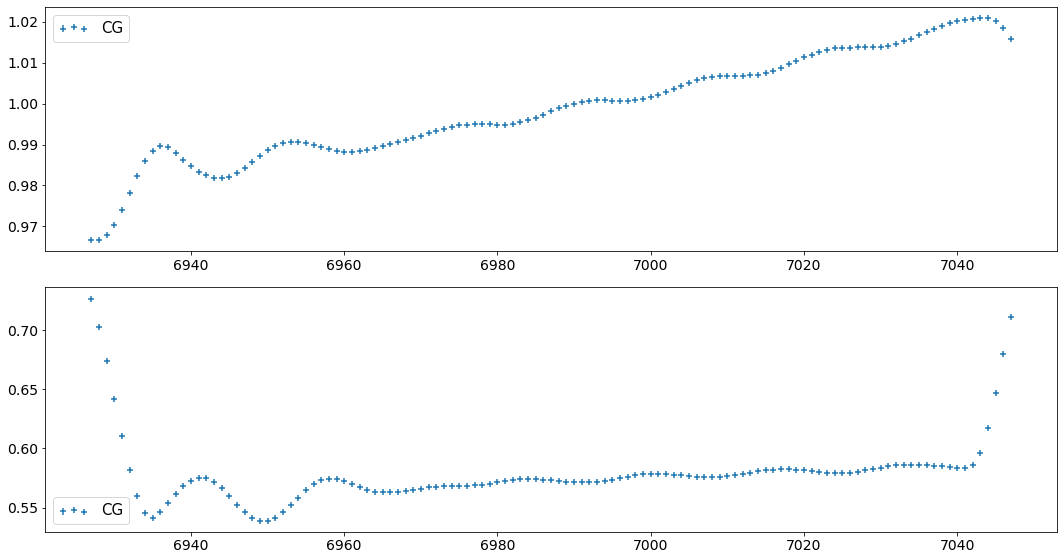


.
.
 10ABCG.csv
  Fault type Percentage
0        NML     71.24%
1      FAULT     28.76%


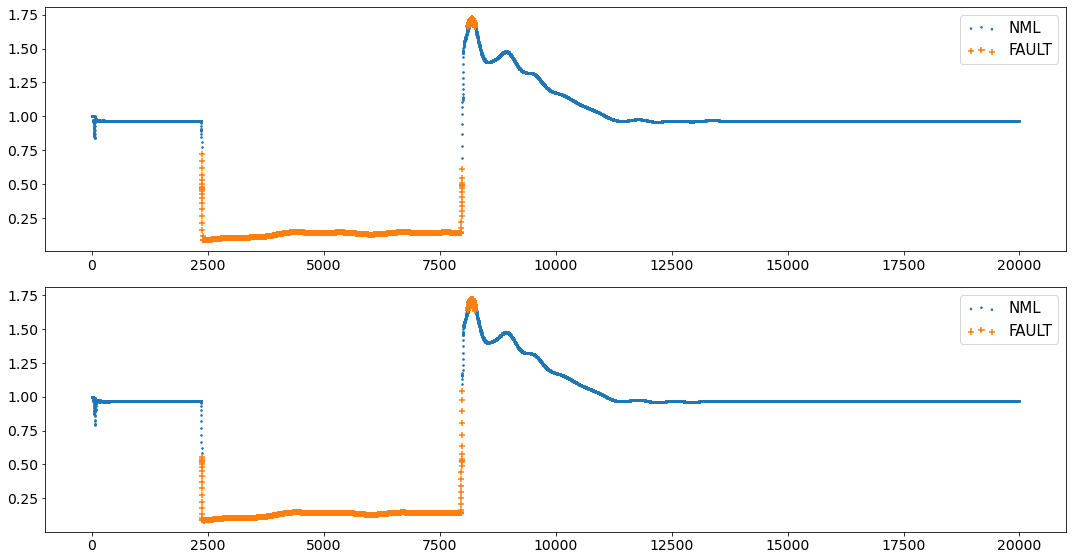

  Fault type Percentage
0       ABCG     97.24%
1        ACG      2.35%
2        ABG       0.3%
3        BCG      0.07%
4         AG      0.05%


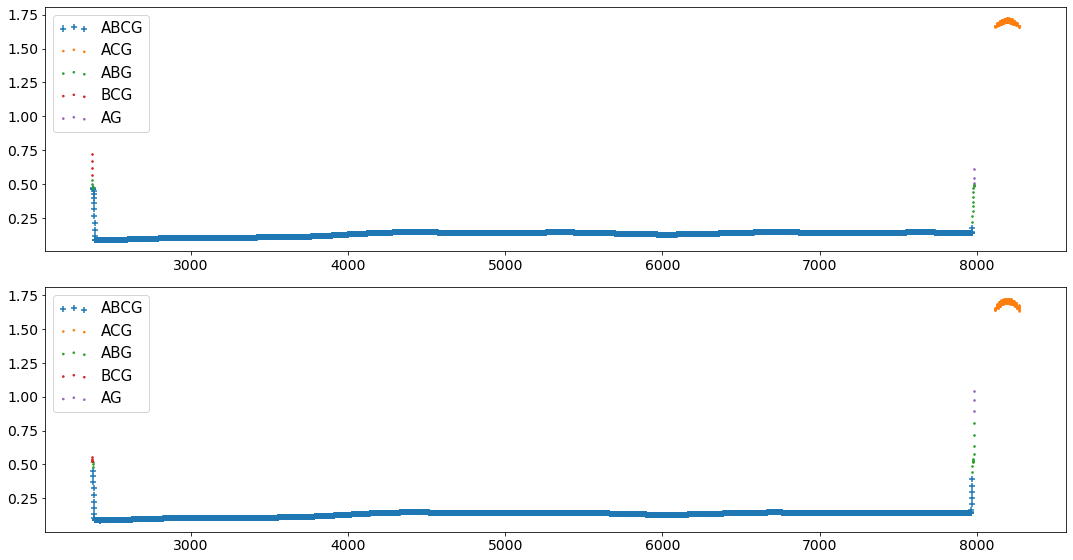


.
.
 6AG.csv
  Fault type Percentage
0        NML     67.97%
1      FAULT     32.02%


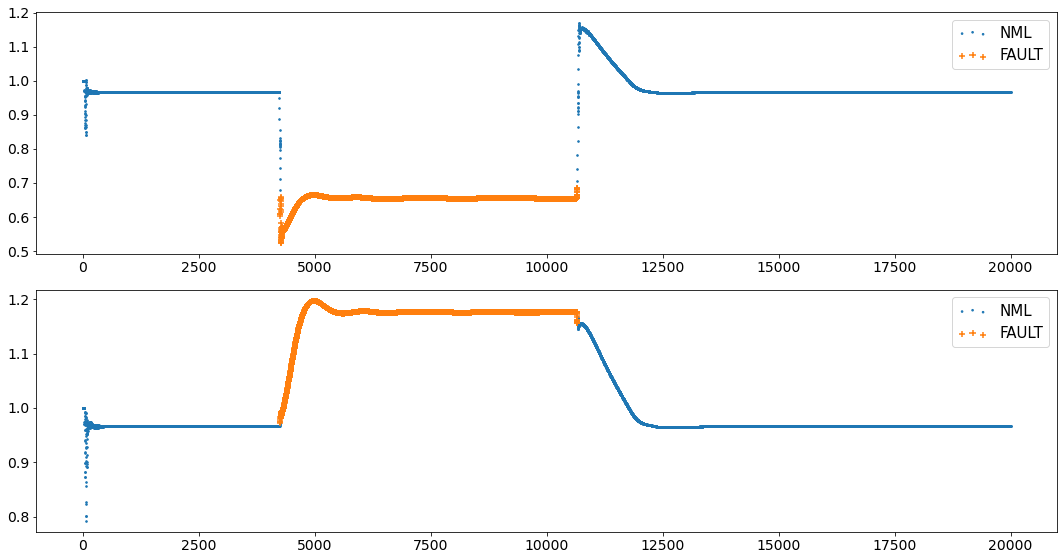

  Fault type Percentage
0         AG     100.0%


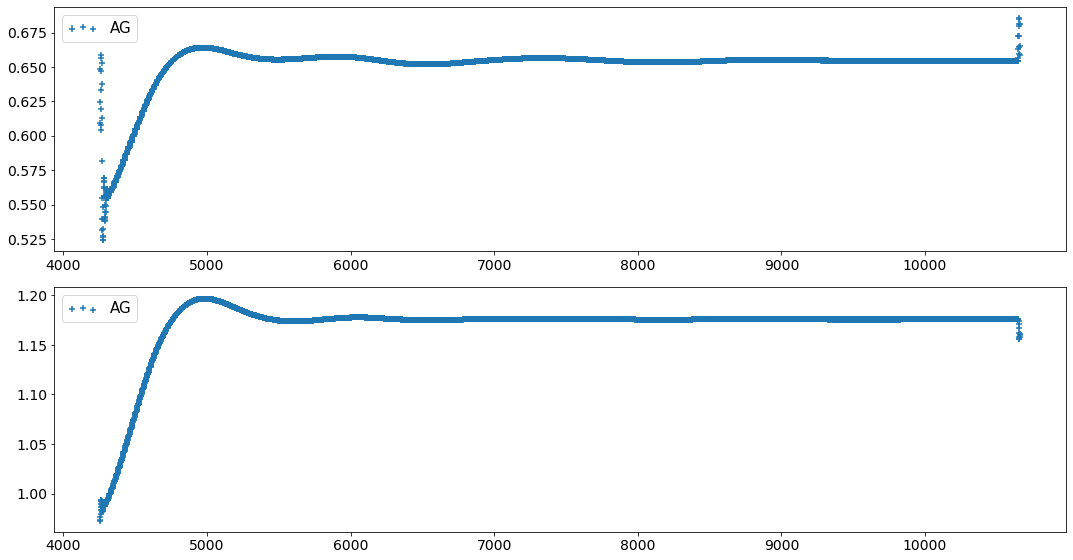


.
.
 3ABCG.csv
  Fault type Percentage
0        NML     94.98%
1      FAULT      5.01%


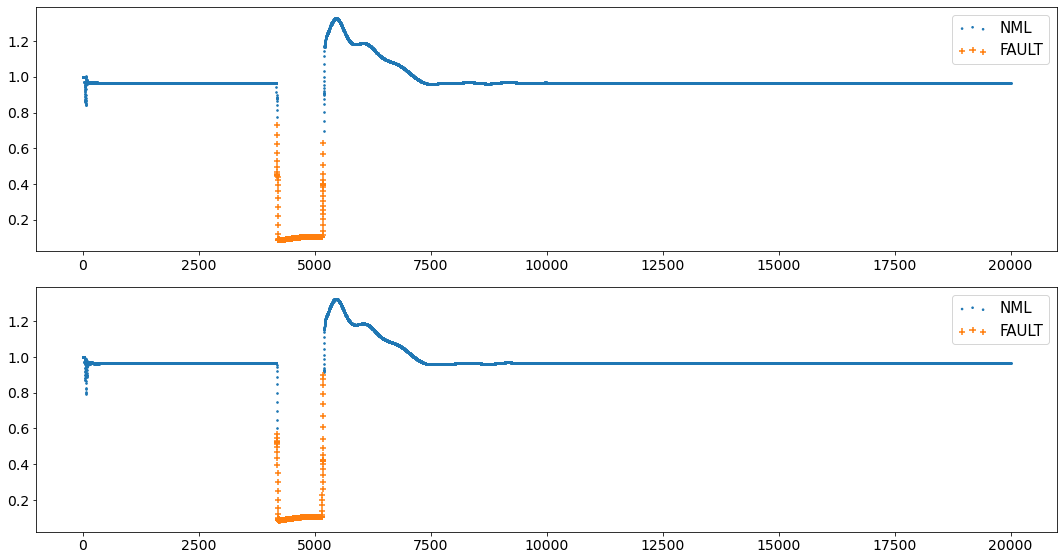

  Fault type Percentage
0       ABCG     98.01%
1        ABG       1.3%
2        BCG       0.4%
3         AG       0.3%


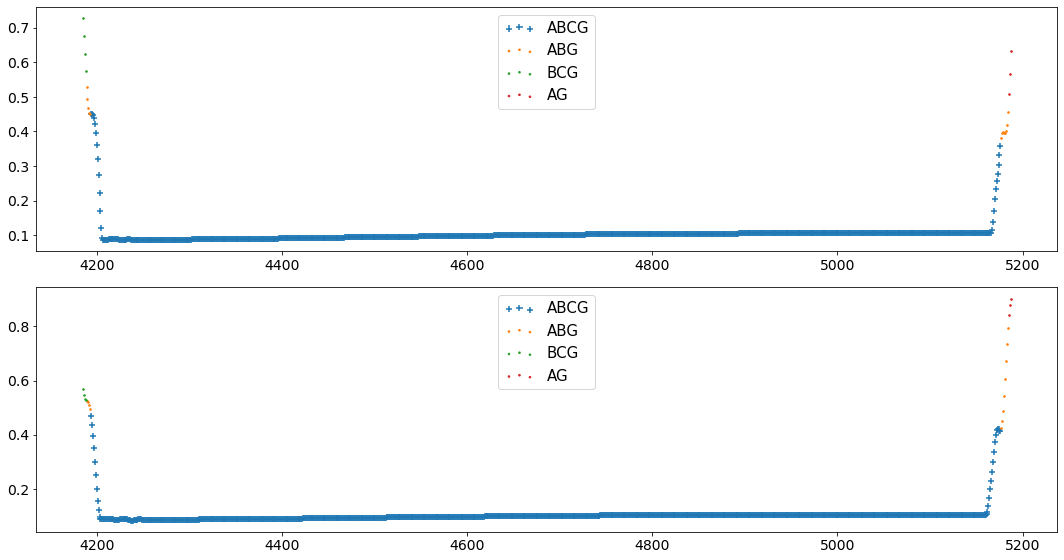


.
.
 2AC.csv
  Fault type Percentage
0        NML     98.75%
1      FAULT      1.25%


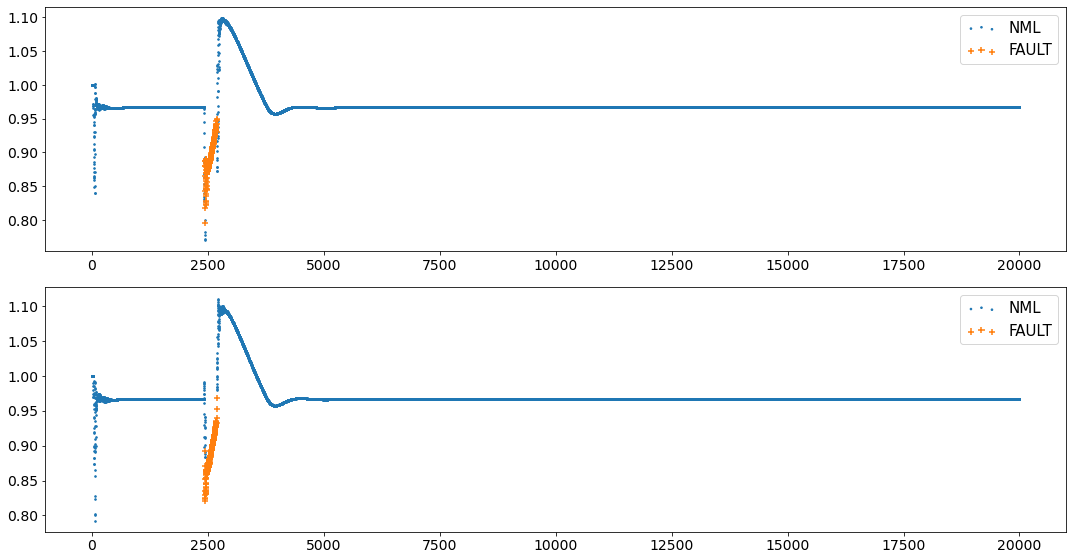

  Fault type Percentage
0         AC      99.6%
1        ACG       0.4%


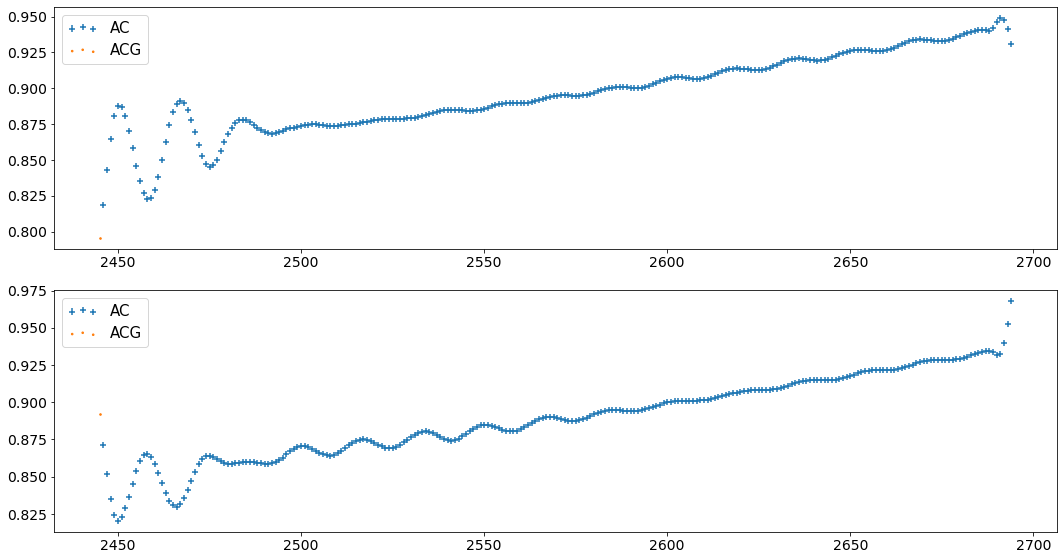


.
.
 4ACG.csv
  Fault type Percentage
0        NML     95.15%
1      FAULT      4.85%


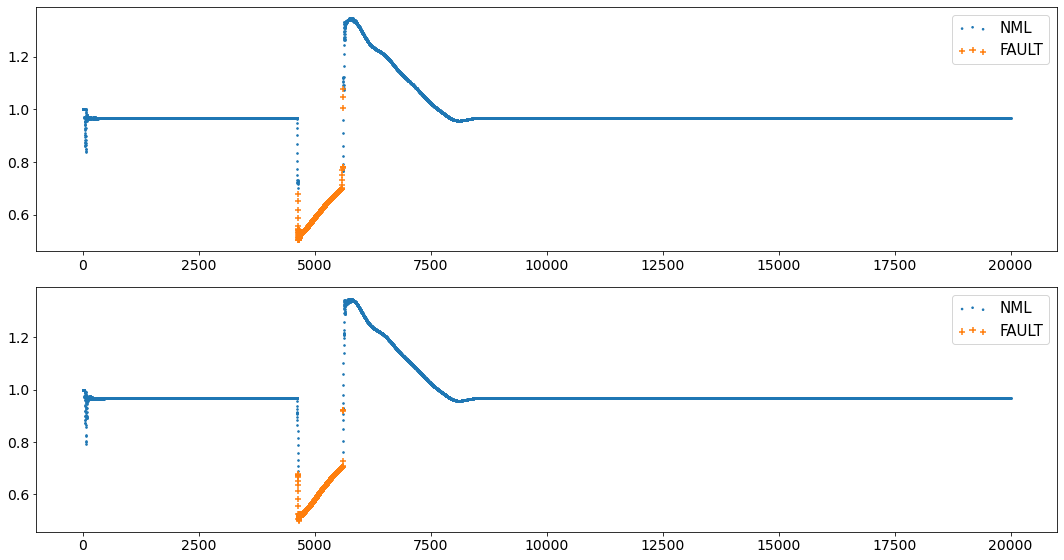

  Fault type Percentage
0        ACG     99.79%
1         AC      0.21%


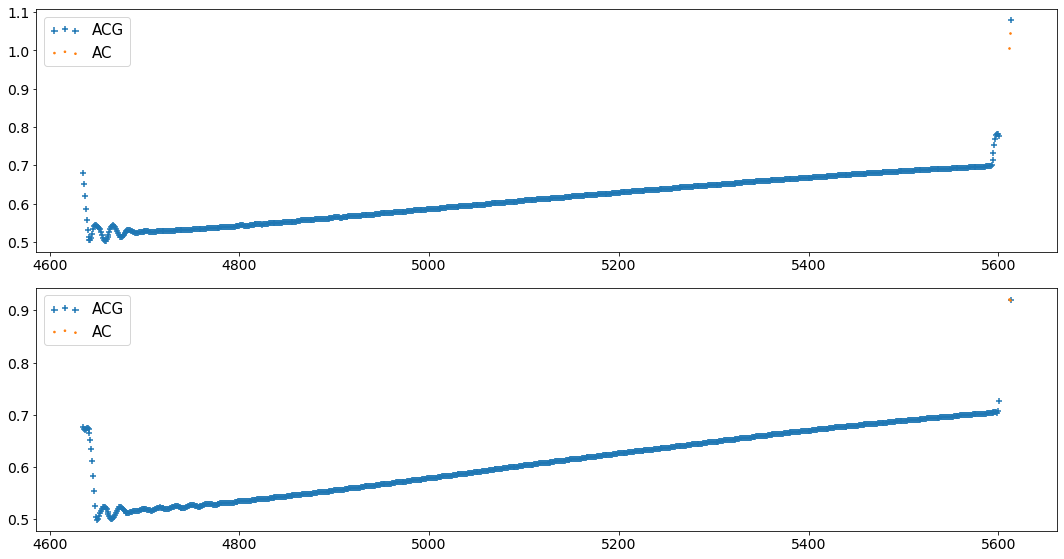


.
.
 8ACG.csv
  Fault type Percentage
0        NML     99.44%
1      FAULT      0.56%


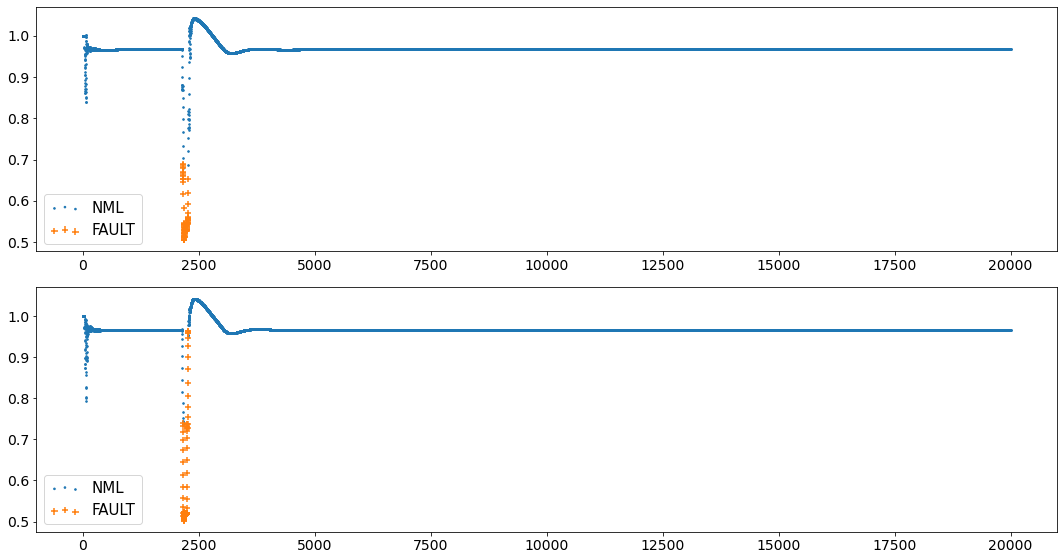

  Fault type Percentage
0        ACG     90.27%
1         AG      9.73%


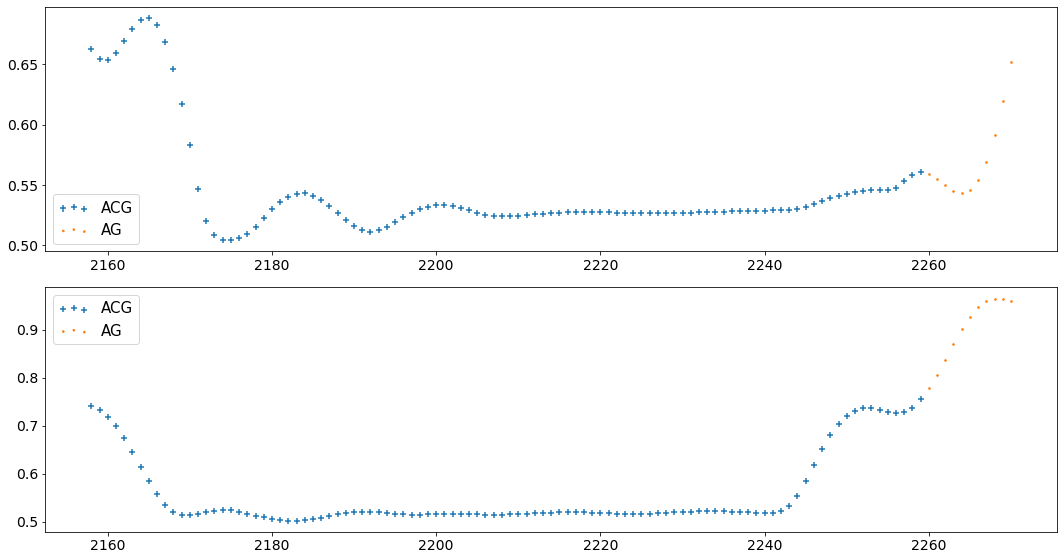


.
.
 4AG.csv
  Fault type Percentage
0        NML     73.69%
1      FAULT      26.3%


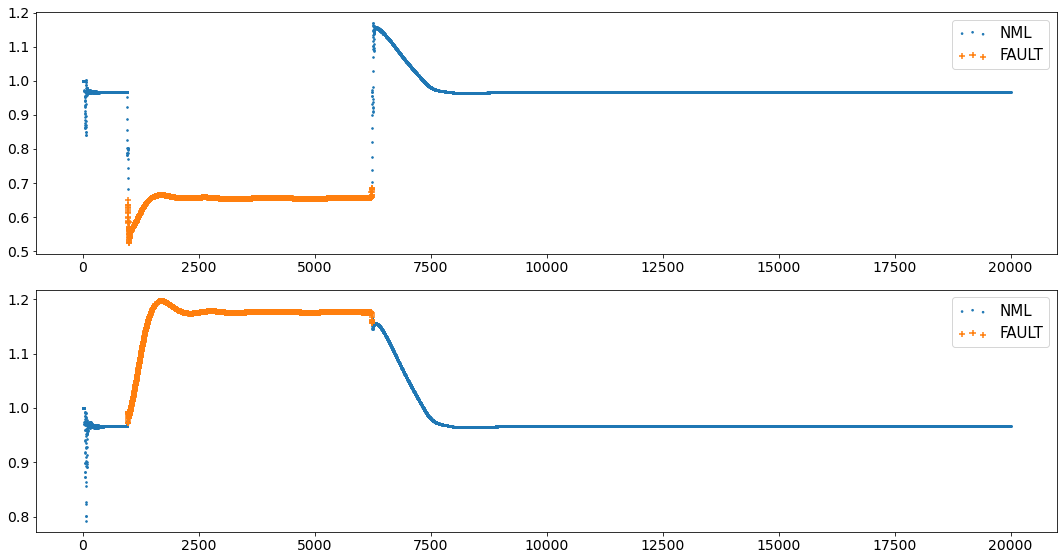

  Fault type Percentage
0         AG     100.0%


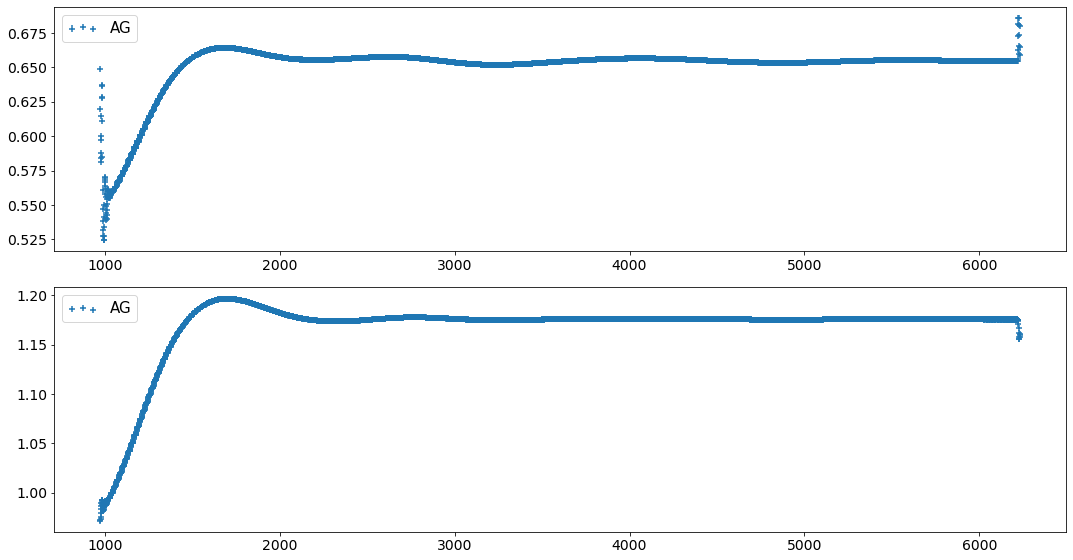


.
.
 6ABG.csv
  Fault type Percentage
0        NML     94.22%
1      FAULT      5.78%


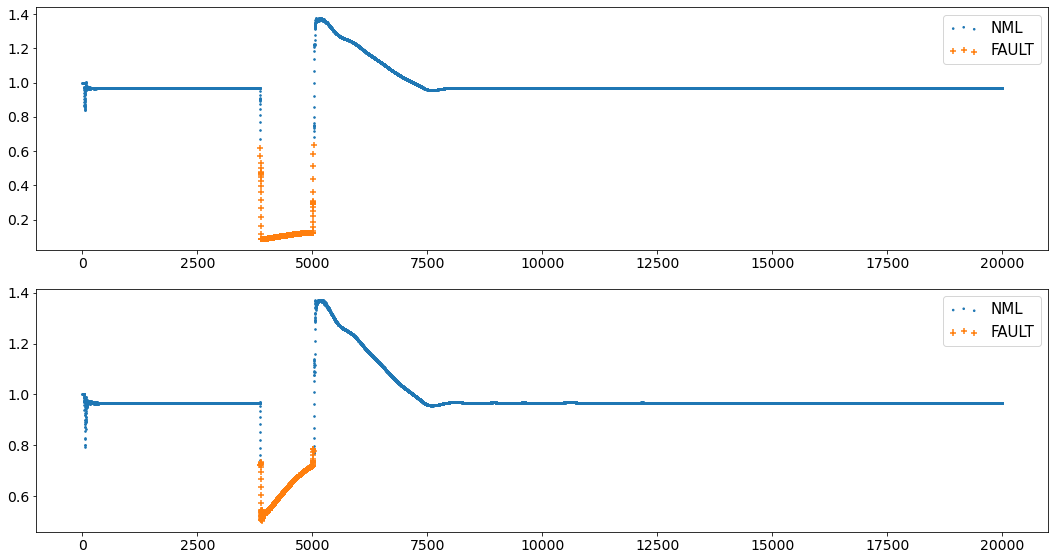

  Fault type Percentage
0        ABG     99.57%
1         BG      0.43%


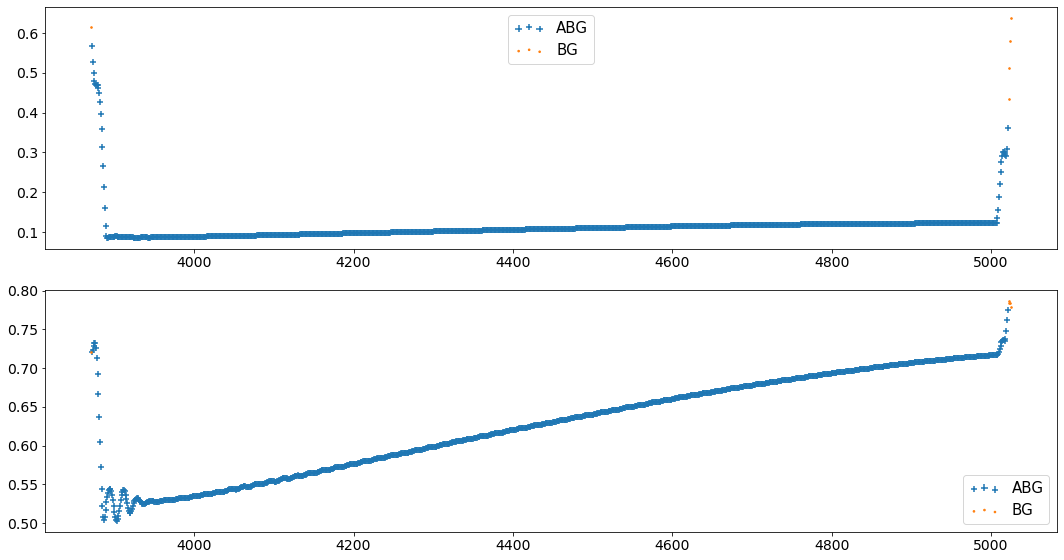


.
.
 8BG.csv
  Fault type Percentage
0        NML      98.1%
1      FAULT       1.9%


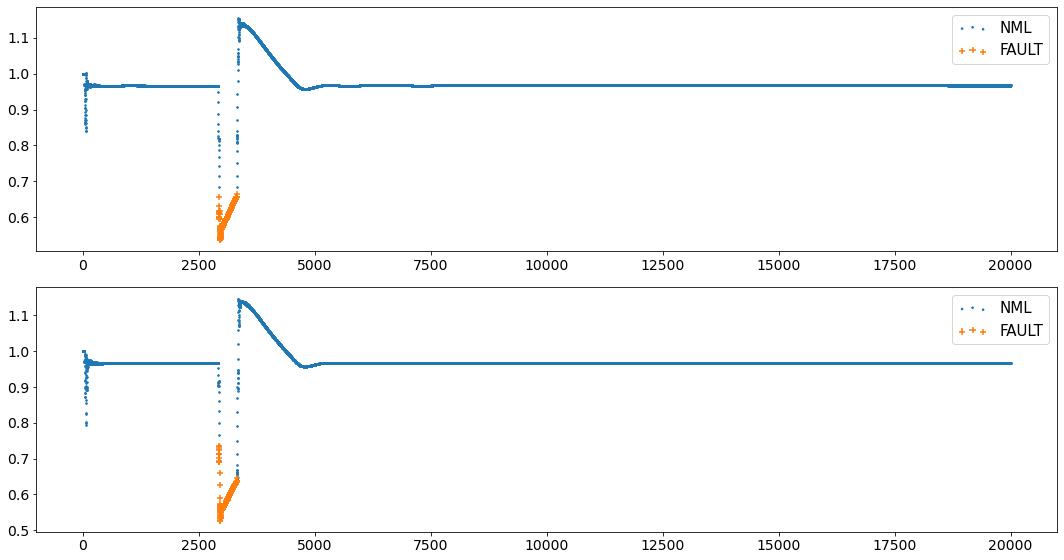

  Fault type Percentage
0         BG     100.0%


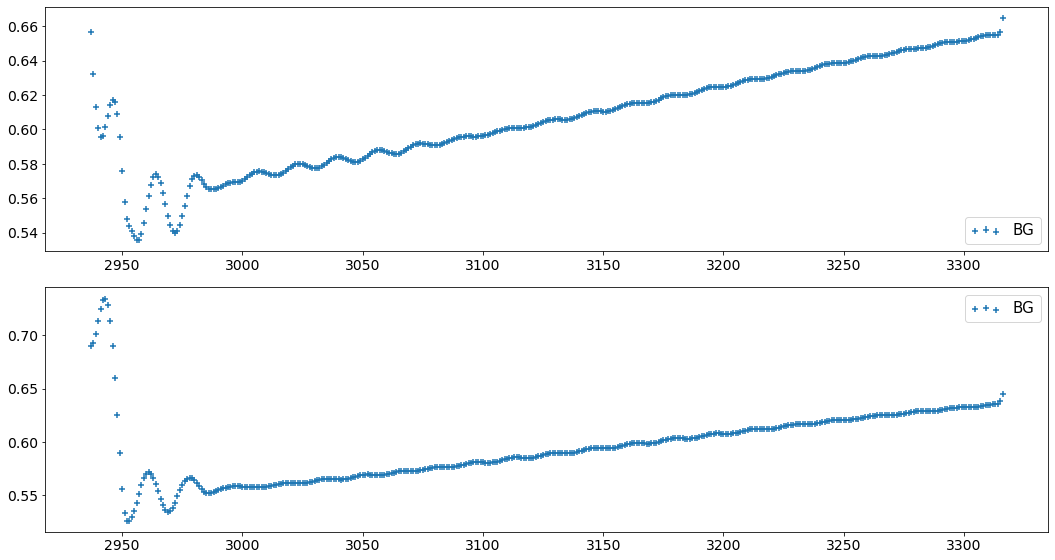


.
.
 7AC.csv
  Fault type Percentage
0        NML     98.08%
1      FAULT      1.92%


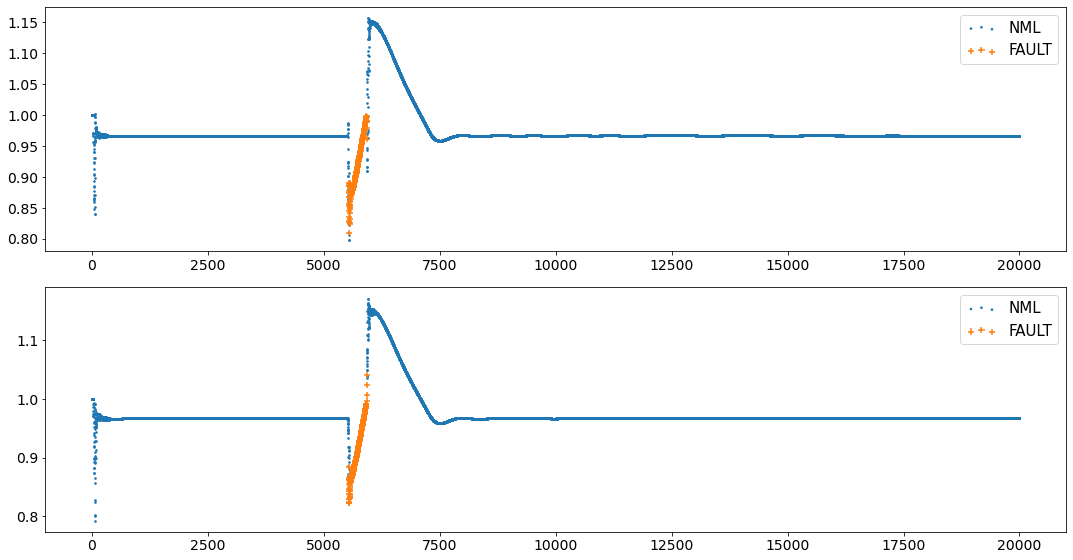

  Fault type Percentage
0         AC     99.74%
1        ACG      0.26%


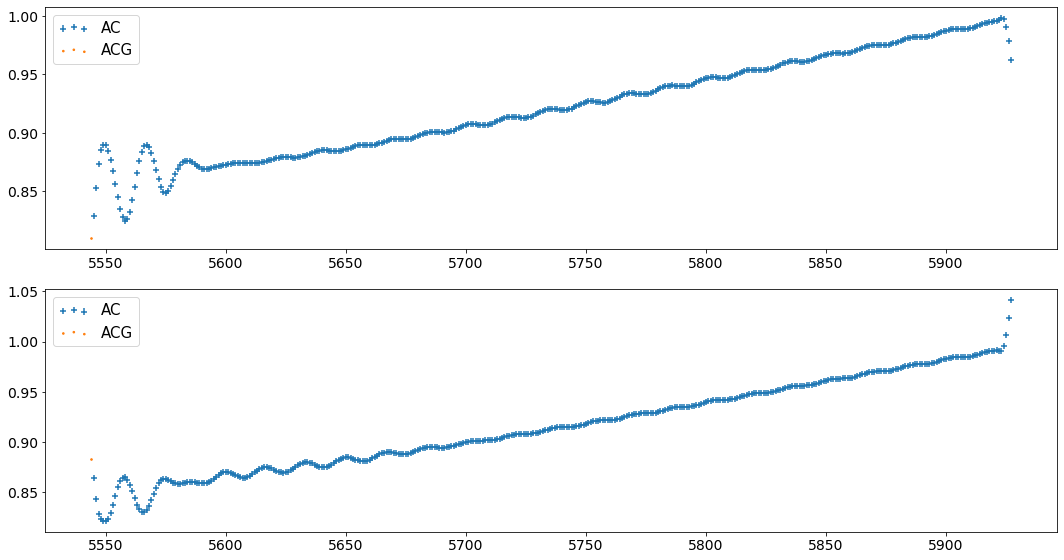


.
.
 3AG.csv
  Fault type Percentage
0        NML     83.95%
1      FAULT     16.05%


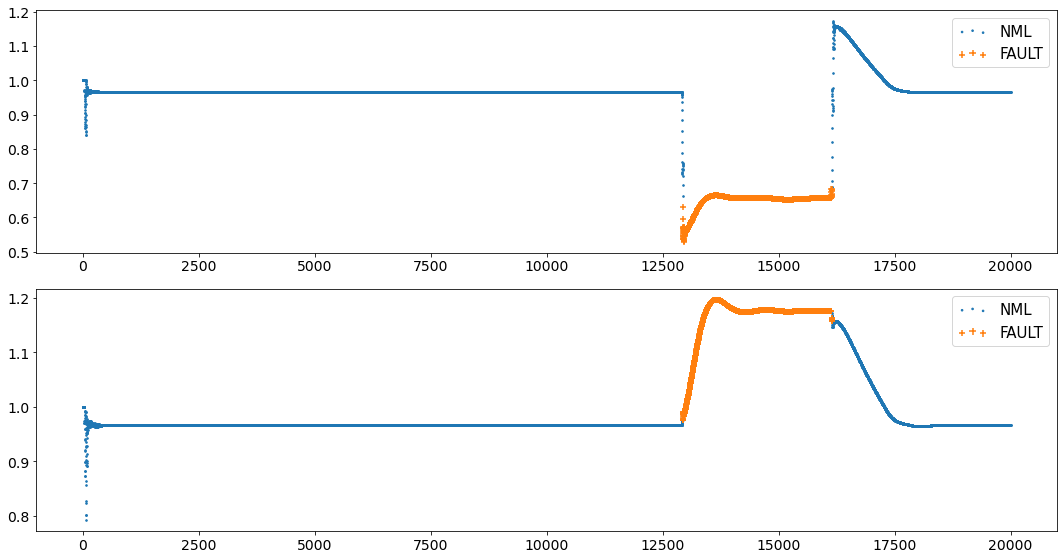

  Fault type Percentage
0         AG     100.0%


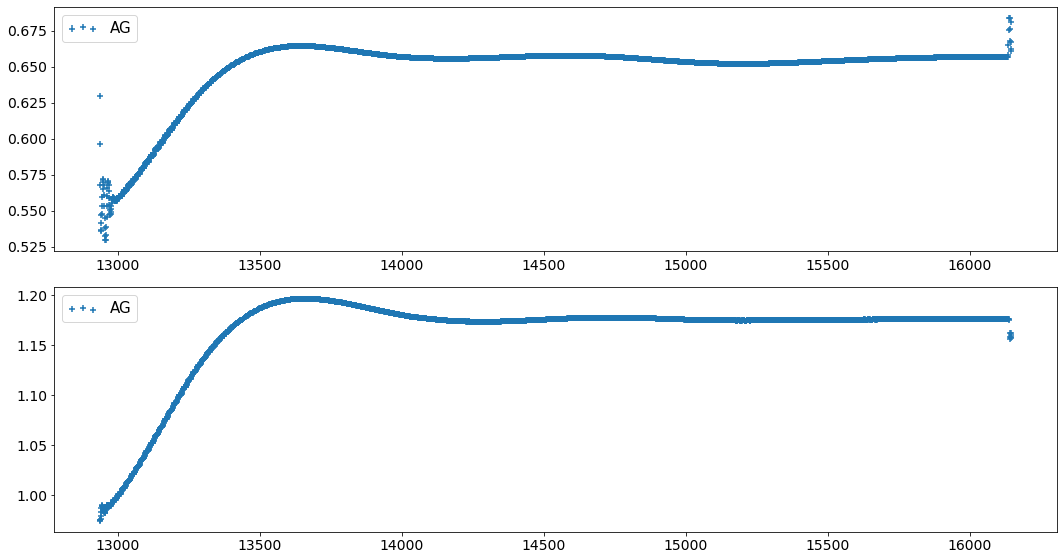


.
.
 1ABCG.csv
  Fault type Percentage
0        NML     91.47%
1      FAULT      8.53%


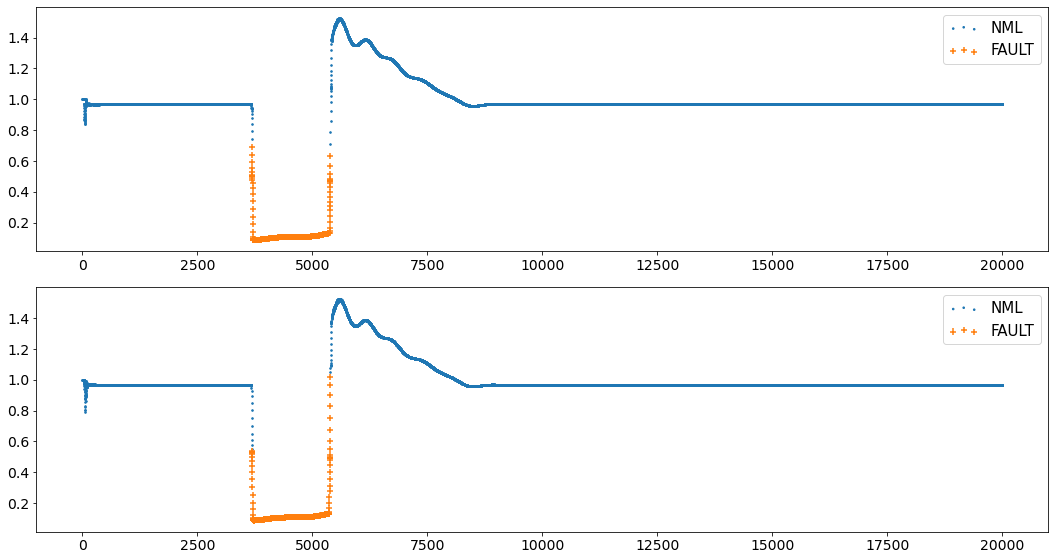

  Fault type Percentage
0       ABCG     98.48%
1        ABG      0.88%
2        BCG      0.47%
3         AG      0.18%


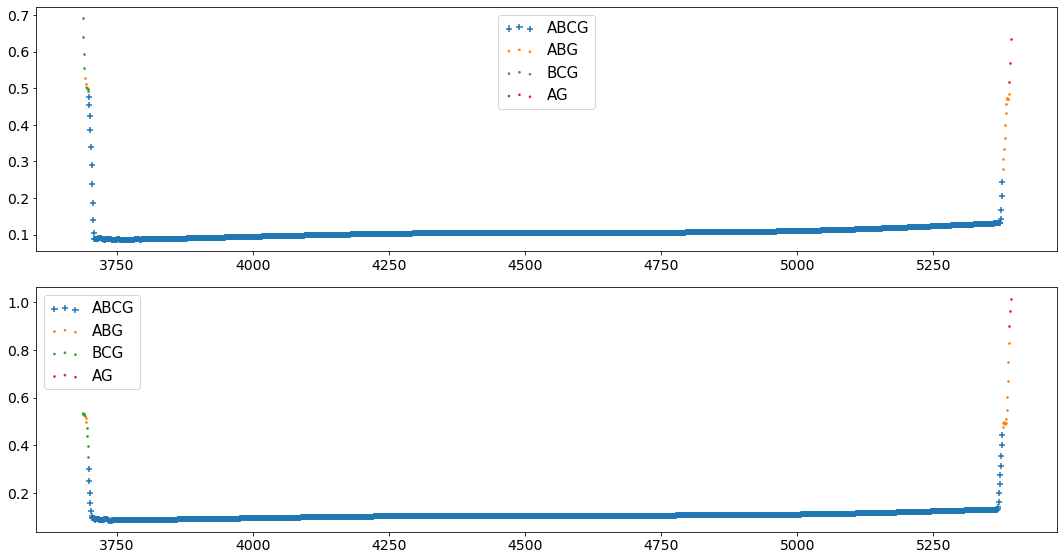


.
.
 7AB.csv
  Fault type Percentage
0        NML     97.59%
1      FAULT       2.4%


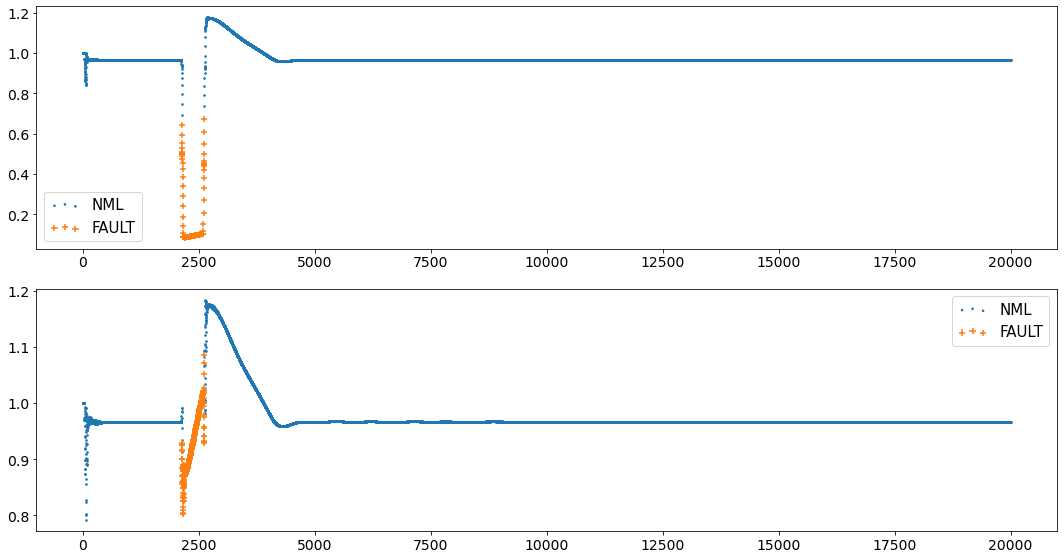

  Fault type Percentage
0         AB     97.09%
1        ABG      2.29%
2         BG      0.62%


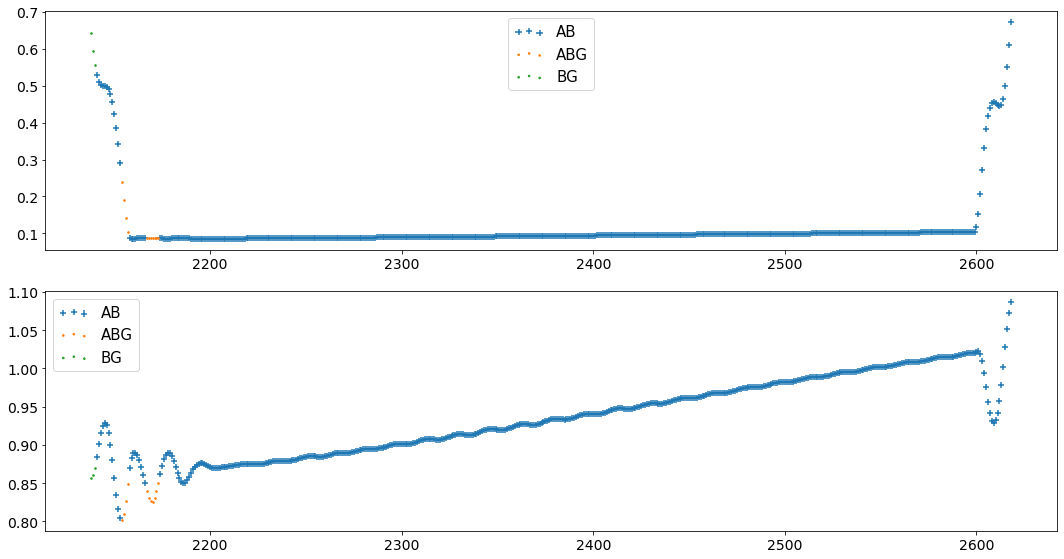


.
.
 6BCG.csv
  Fault type Percentage
0        NML     78.04%
1      FAULT     21.96%


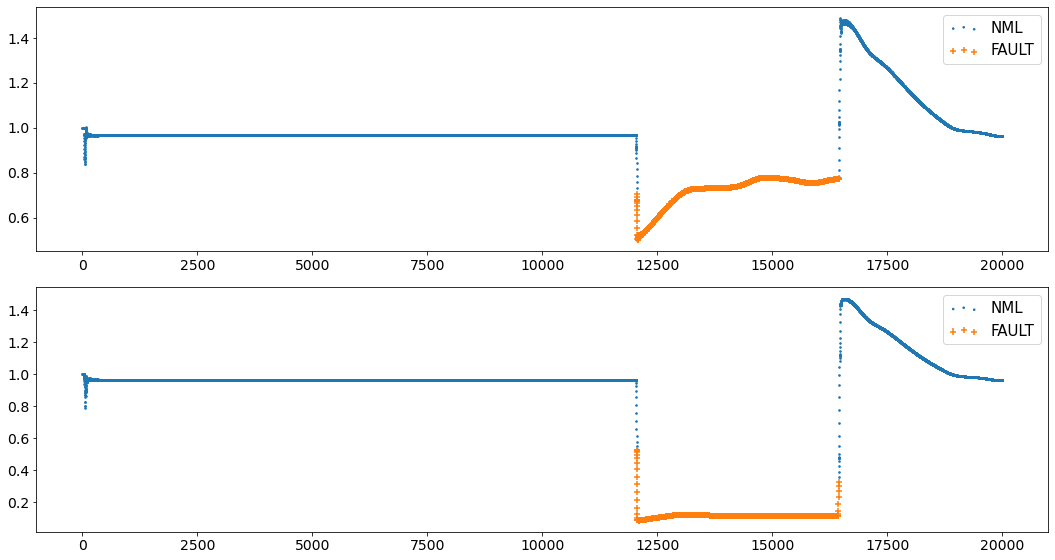

  Fault type Percentage
0        BCG     99.91%
1         BC      0.09%


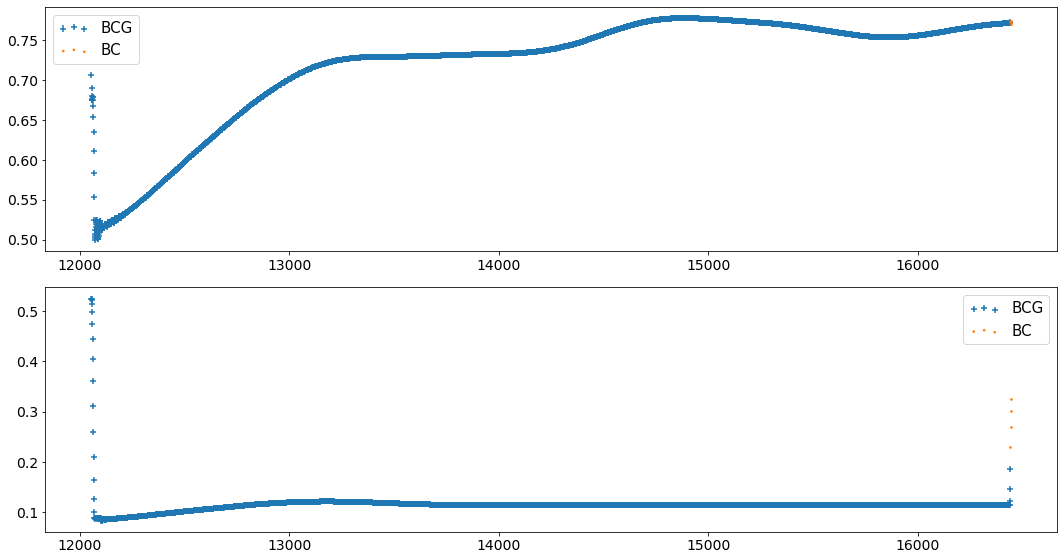


.
.
 5AB.csv
  Fault type Percentage
0        NML     60.13%
1      FAULT     39.87%


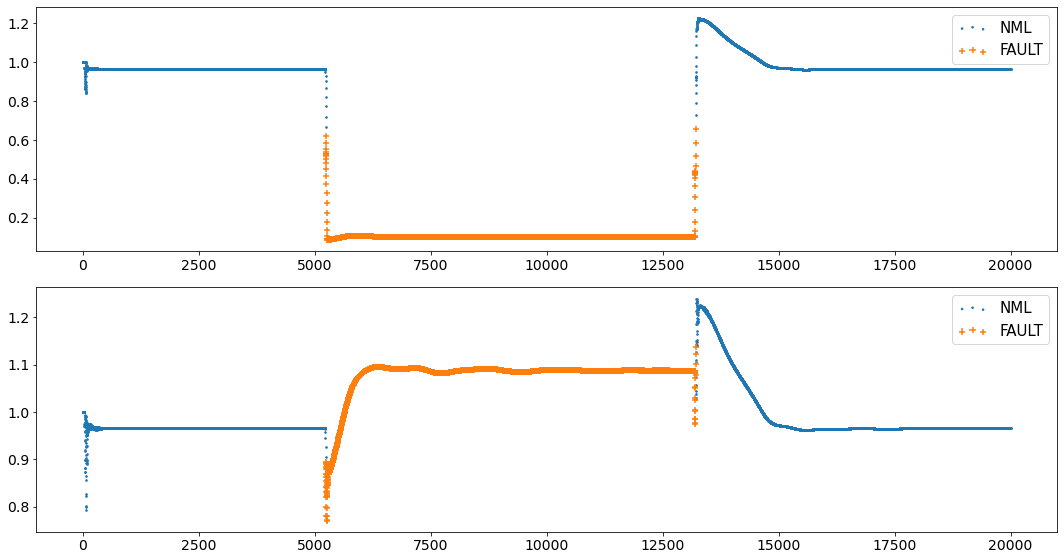

  Fault type Percentage
0         AB     99.79%
1        ABG      0.18%
2         BG      0.04%


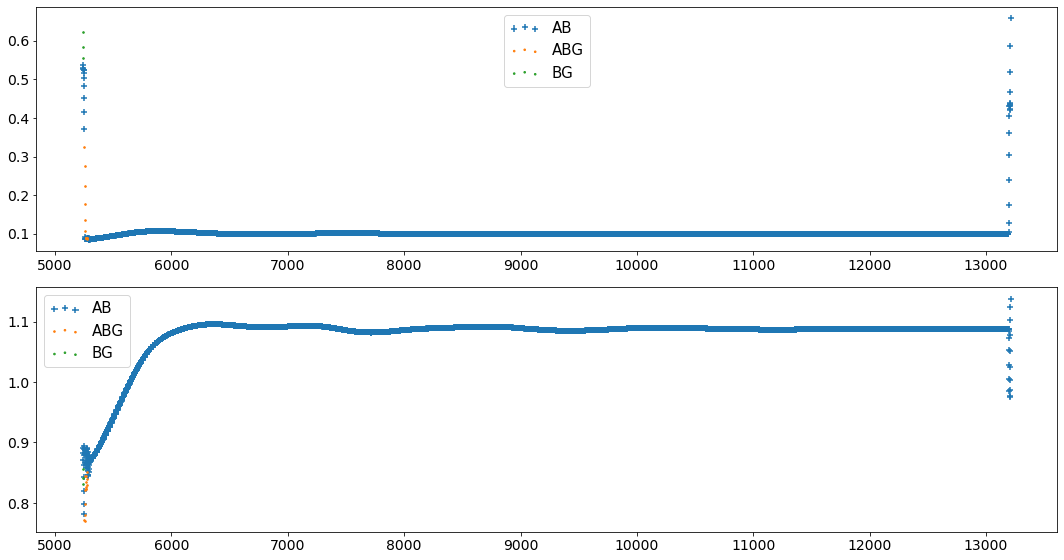


.
.
 9CG.csv
  Fault type Percentage
0        NML     86.95%
1      FAULT     13.04%


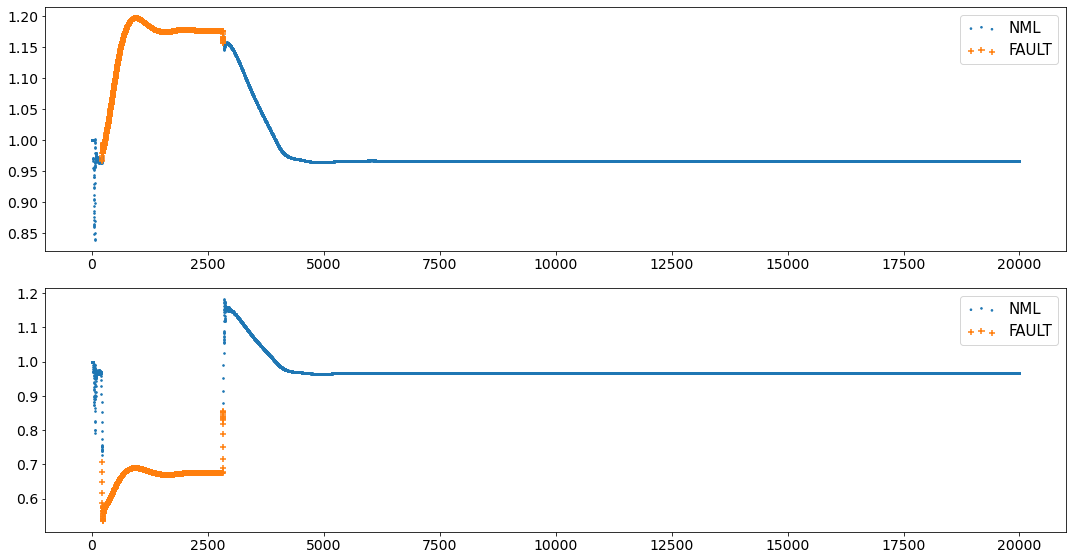

  Fault type Percentage
0         CG     100.0%


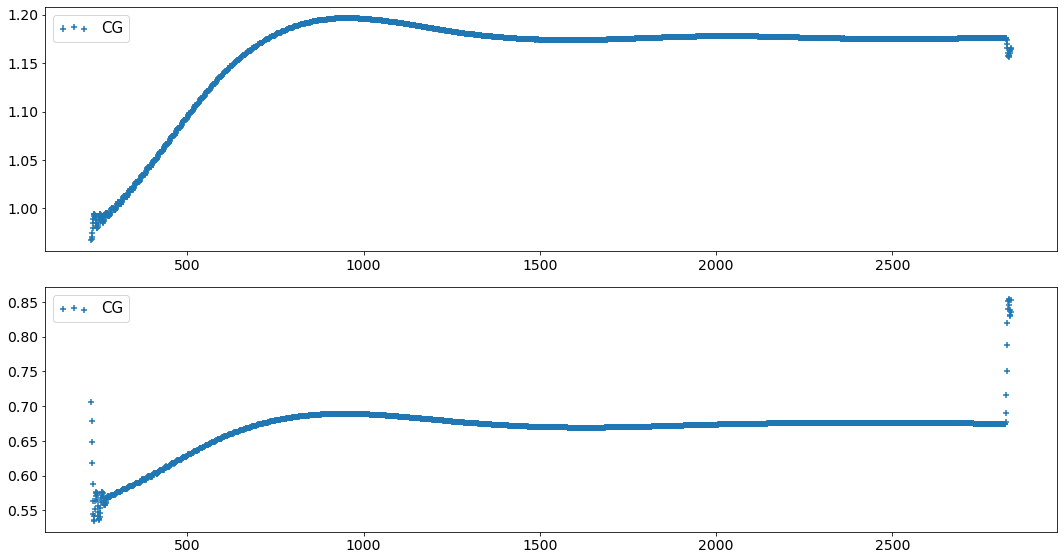


.
.
 9BC.csv
  Fault type Percentage
0        NML     99.42%
1      FAULT      0.58%


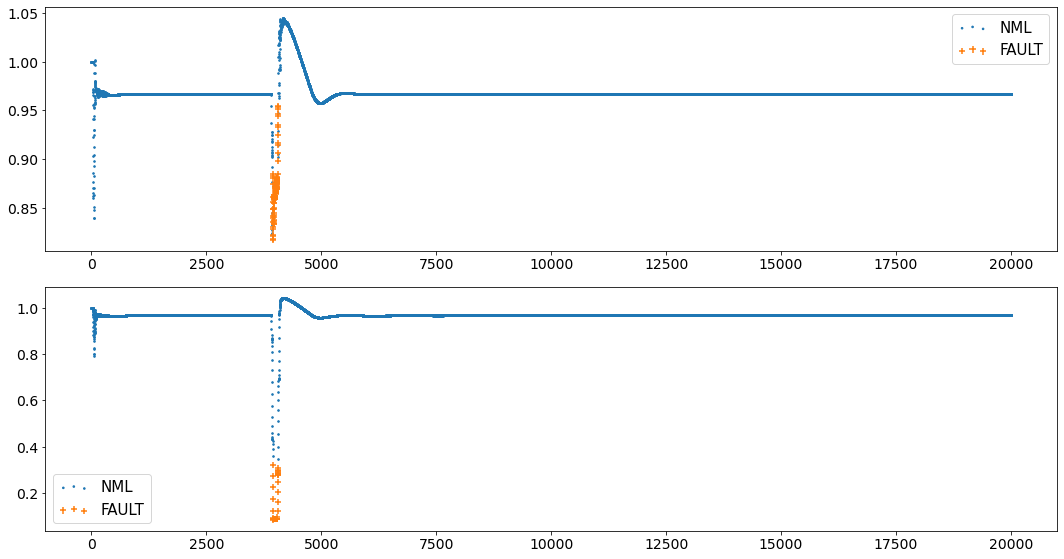

  Fault type Percentage
0         BC     100.0%


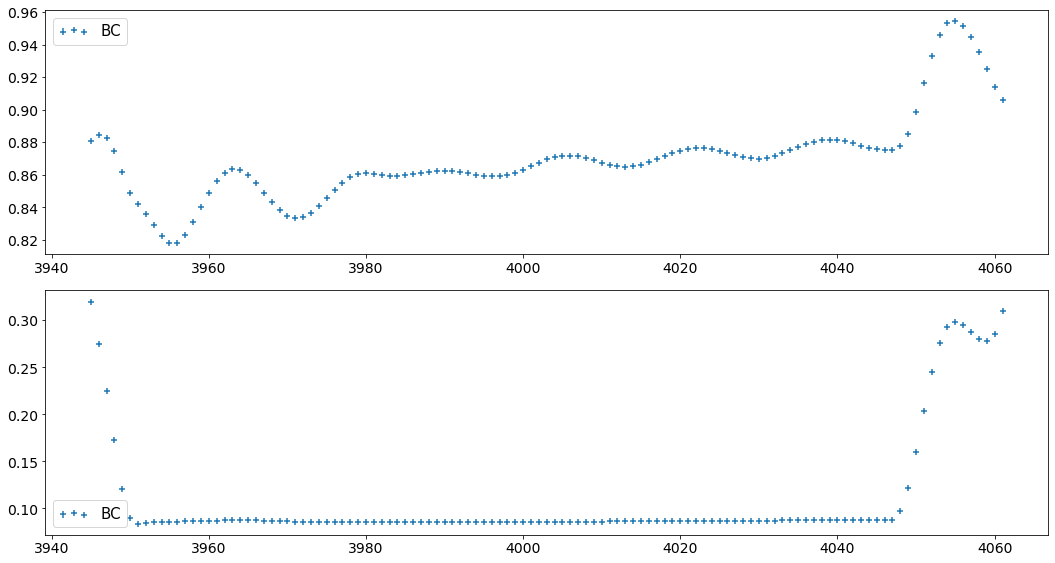


.
.
 2ABG.csv
  Fault type Percentage
0        NML     94.25%
1      FAULT      5.75%


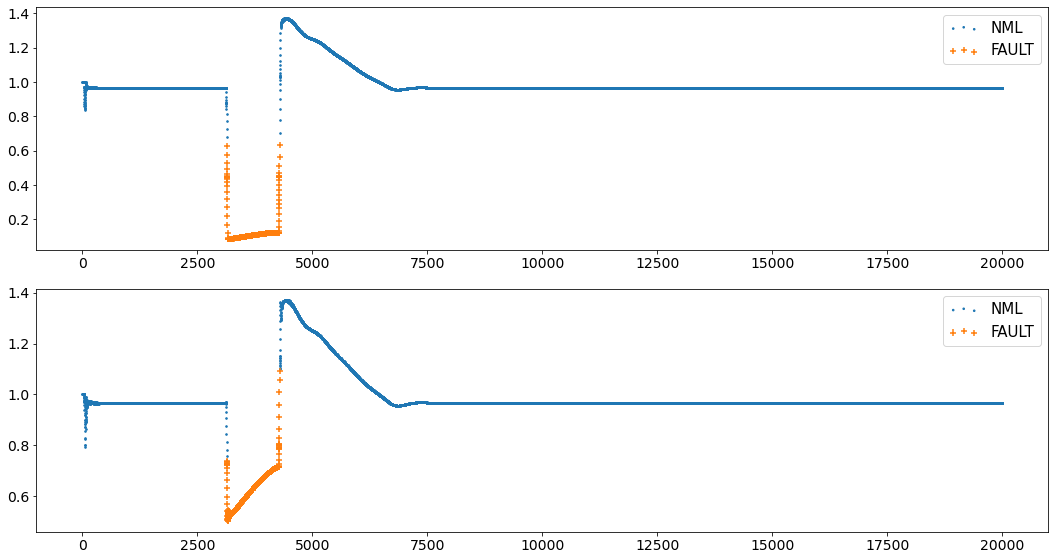

  Fault type Percentage
0        ABG     99.22%
1         AB      0.52%
2         BG      0.17%
3         AG      0.09%


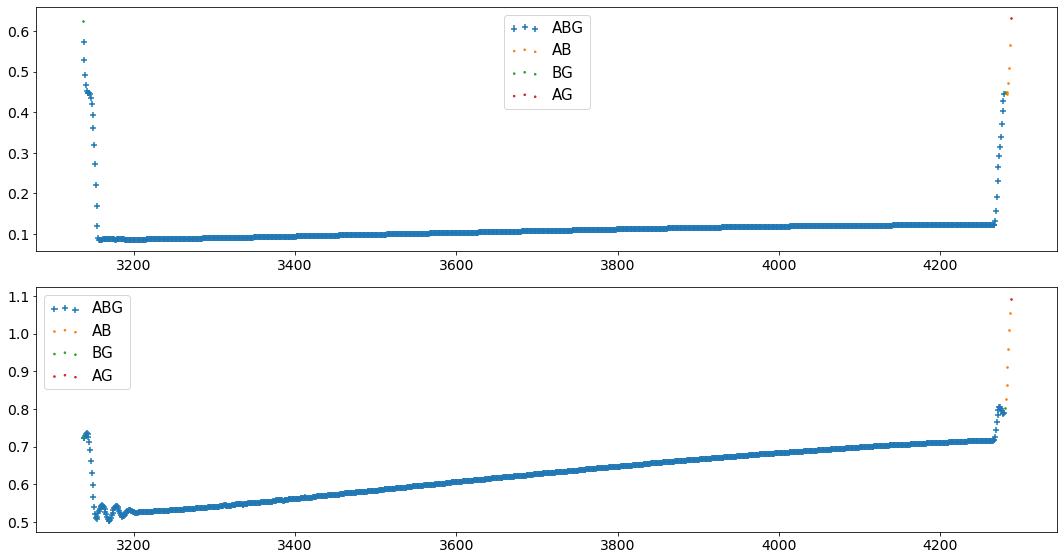


.
.
 1AG.csv
  Fault type Percentage
0        NML     94.39%
1      FAULT      5.62%


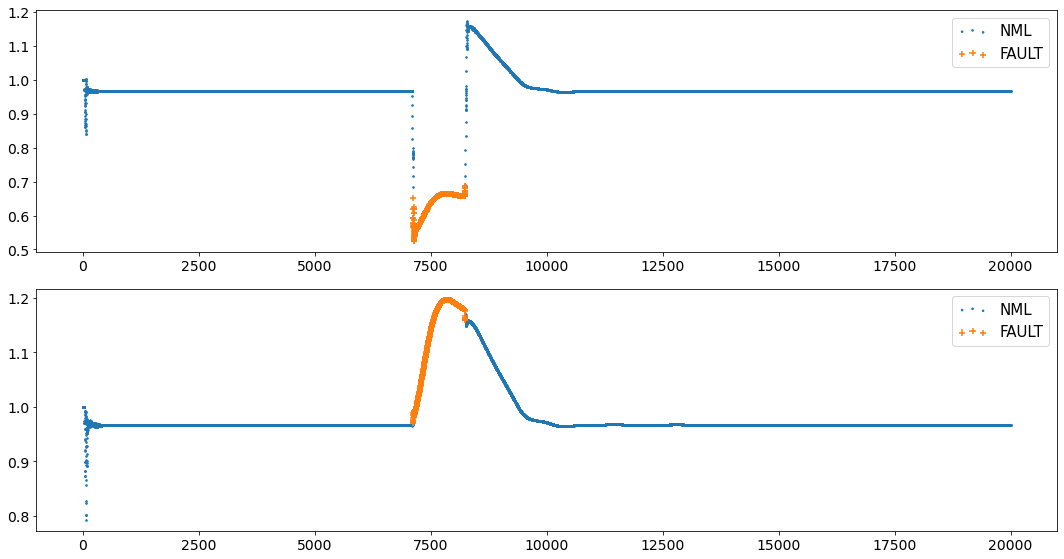

  Fault type Percentage
0         AG     100.0%


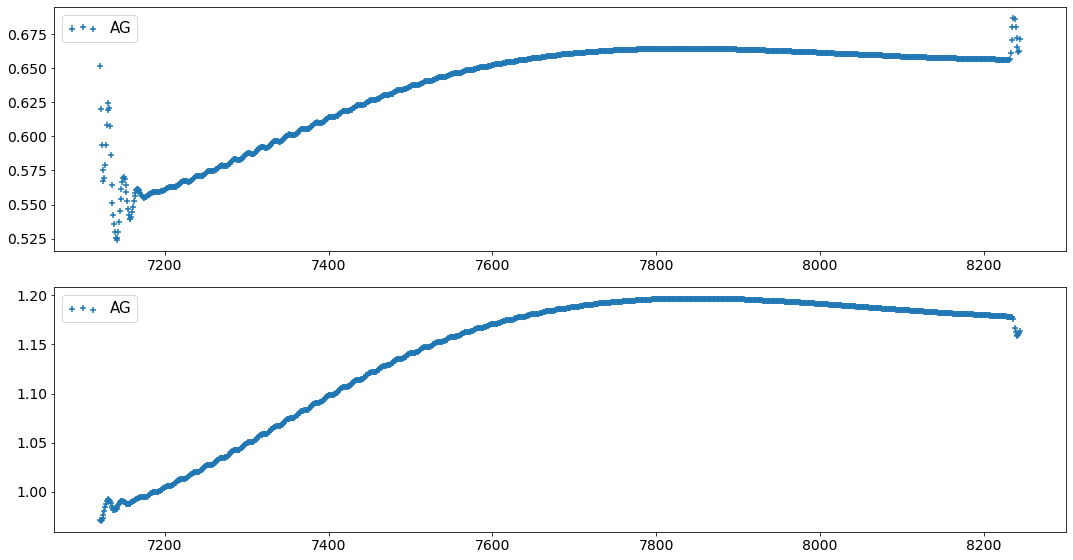


.
.
 8ABCG.csv
  Fault type Percentage
0        NML     95.34%
1      FAULT      4.66%


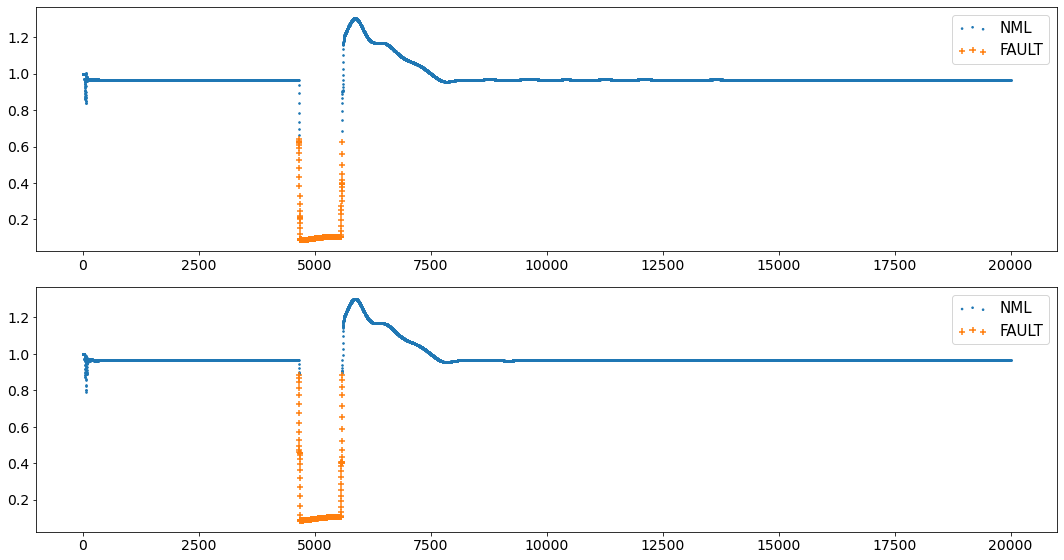

  Fault type Percentage
0       ABCG     96.89%
1        ABG      2.04%
2         AG      0.97%
3        ACG      0.11%


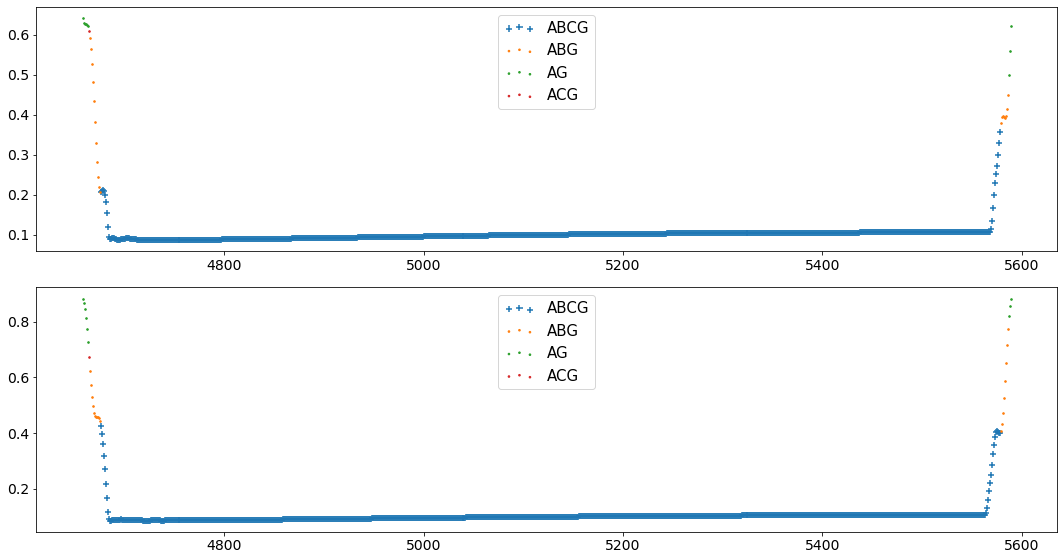


.
.
 5AC.csv
  Fault type Percentage
0        NML     78.88%
1      FAULT     21.12%


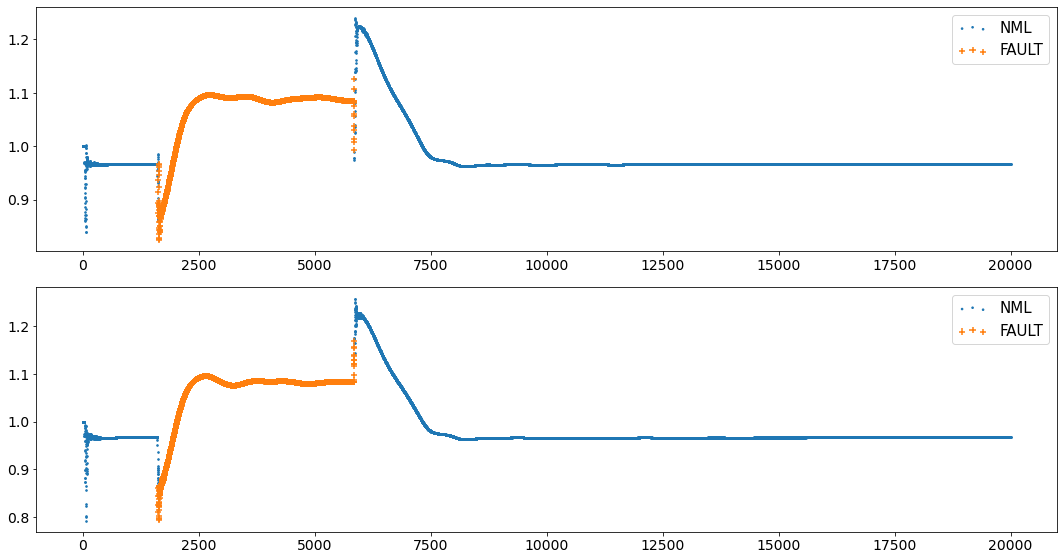

  Fault type Percentage
0         AC     99.93%
1        ACG      0.07%


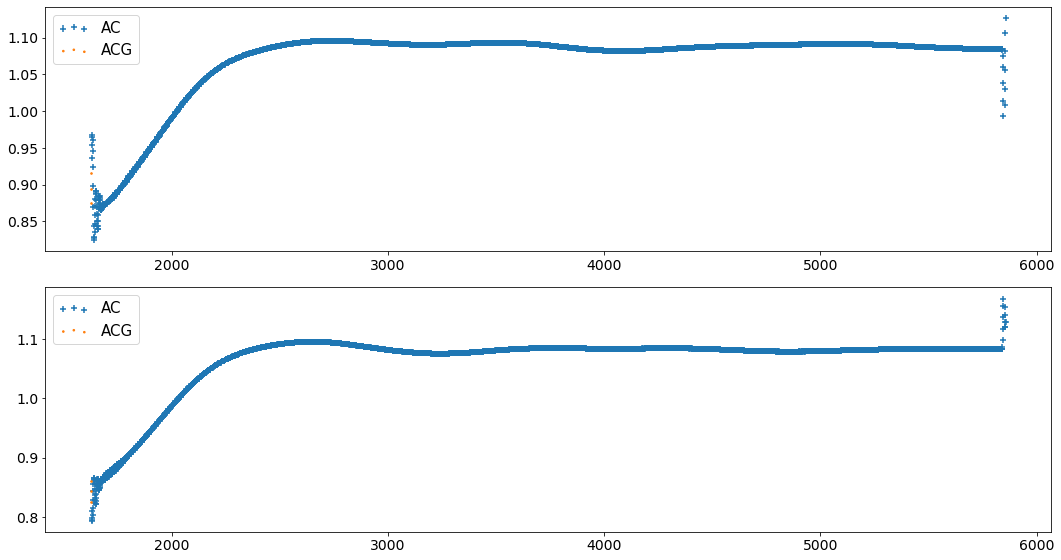


.
.
 5AG.csv
  Fault type Percentage
0        NML      97.6%
1      FAULT       2.4%


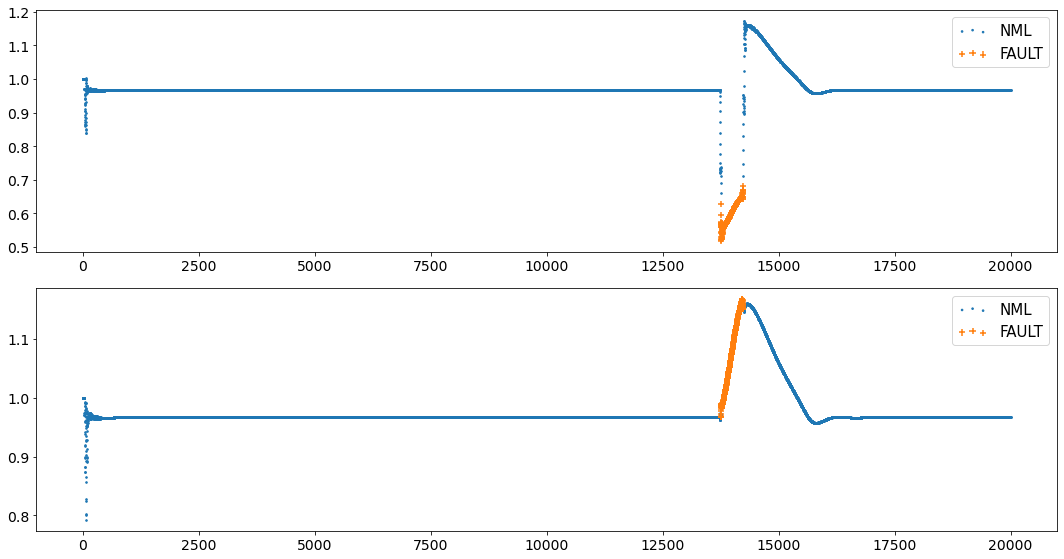

  Fault type Percentage
0         AG     100.0%


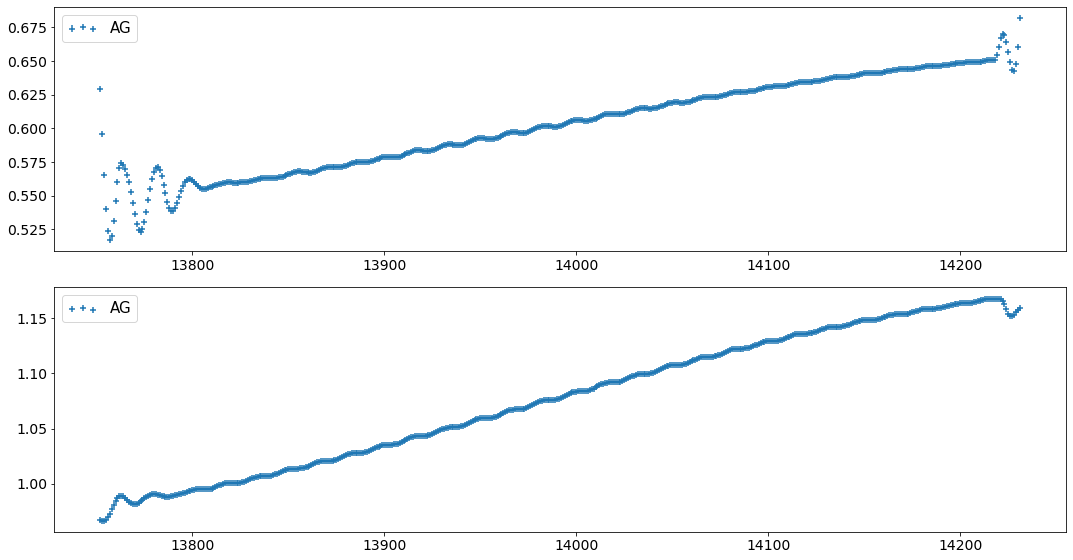


.
.
 1AC.csv
  Fault type Percentage
0        NML     95.73%
1      FAULT      4.26%


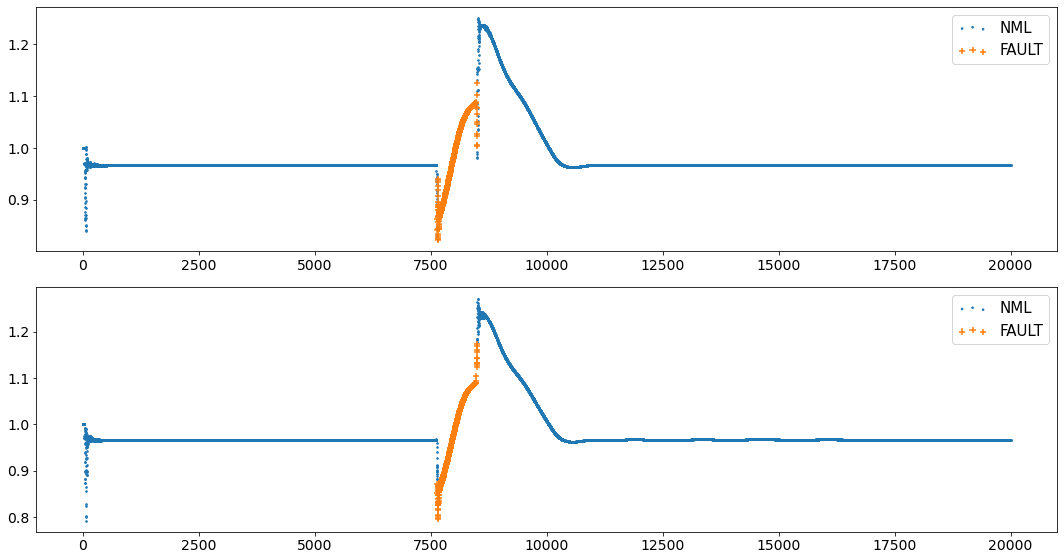

  Fault type Percentage
0         AC     99.88%
1        ACG      0.12%


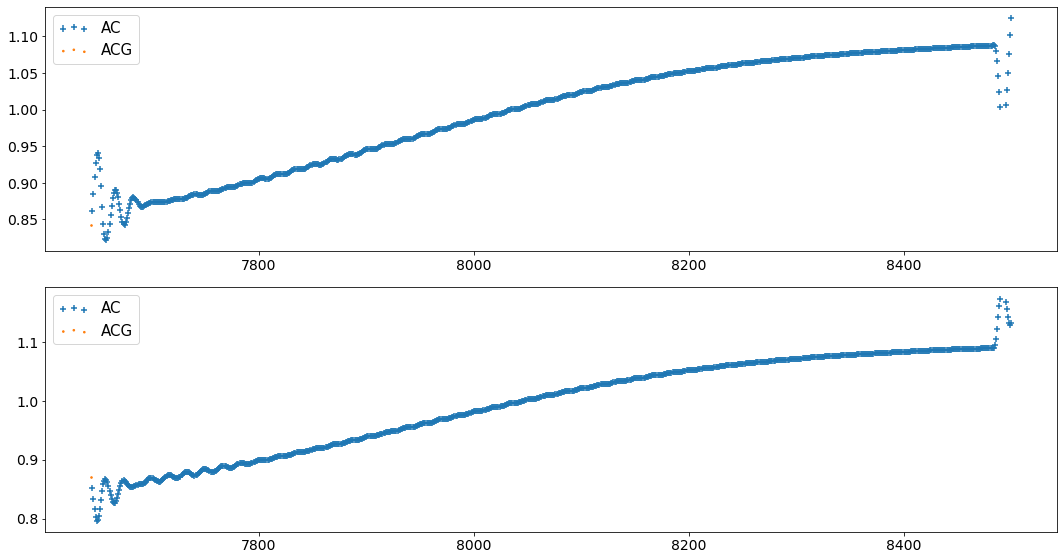


.
.
 2ACG.csv
  Fault type Percentage
0        NML     87.67%
1      FAULT     12.33%


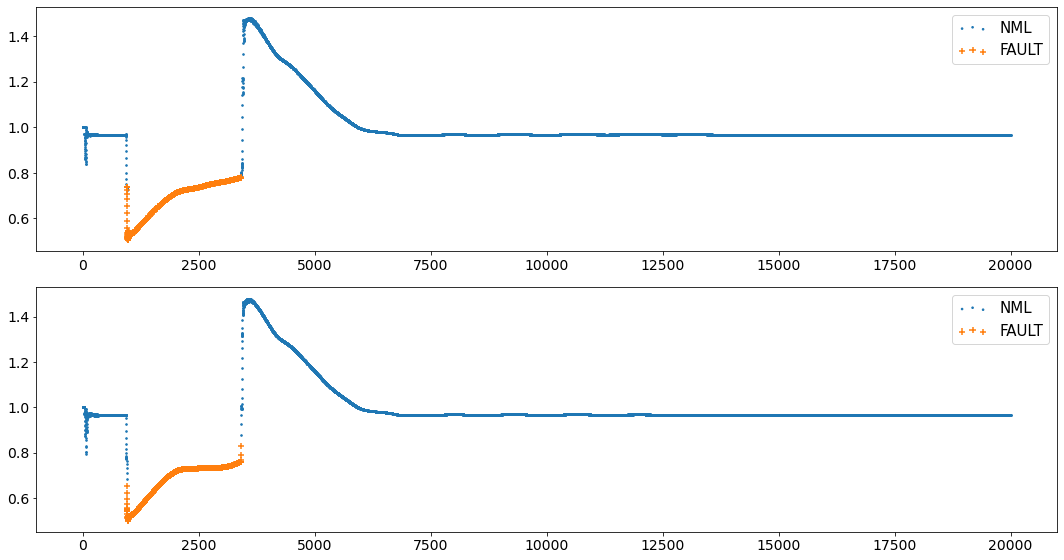

  Fault type Percentage
0        ACG     100.0%


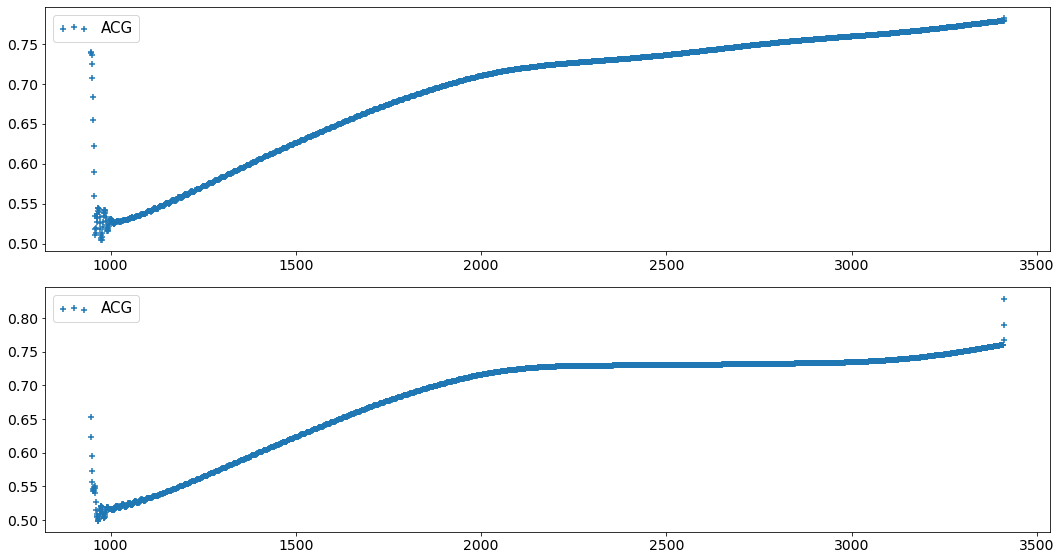


.
.
 1AB.csv
  Fault type Percentage
0        NML     87.31%
1      FAULT      12.7%


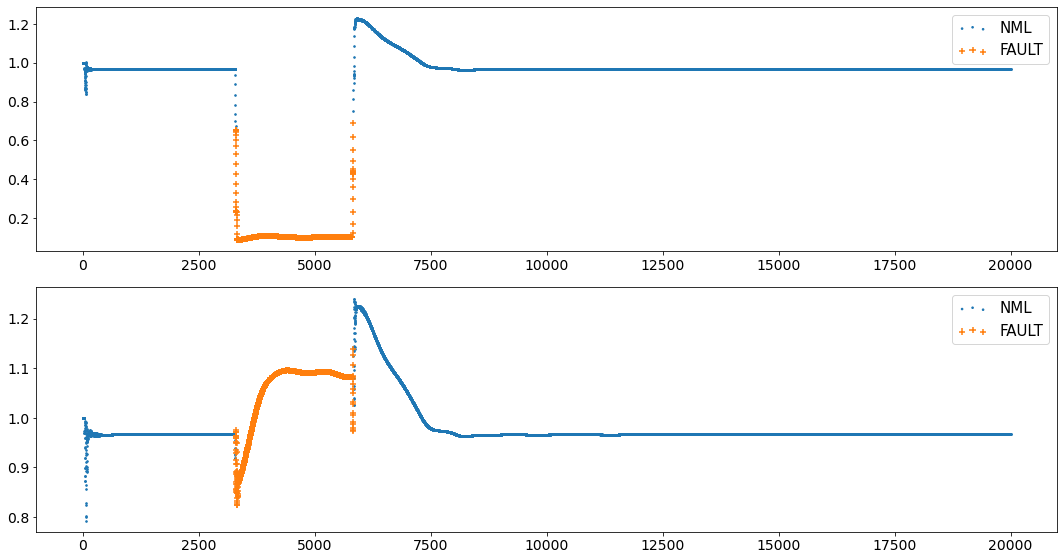

  Fault type Percentage
0         AB     99.41%
1         AG      0.32%
2        ABG      0.28%


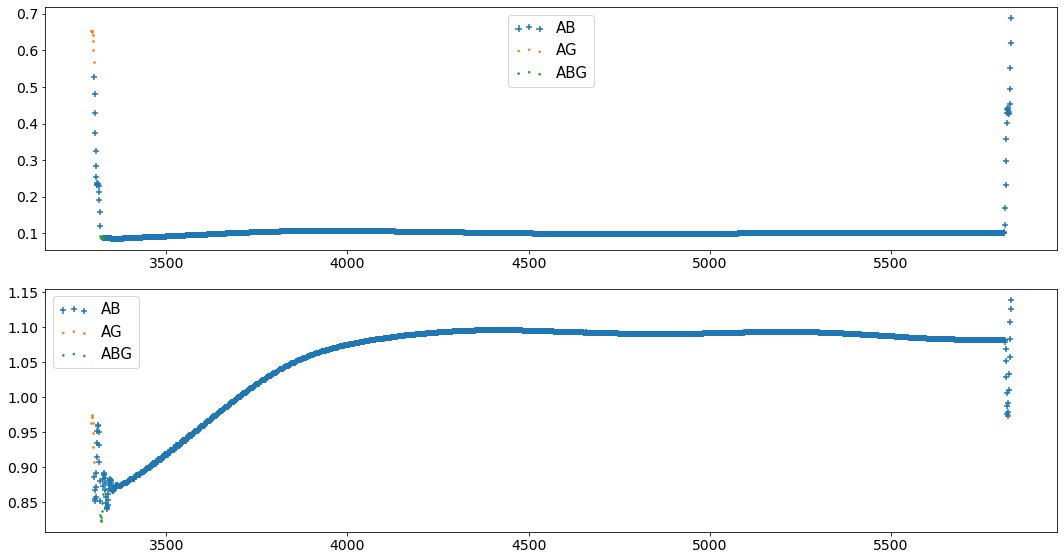


.
.
 9BG.csv
  Fault type Percentage
0        NML     100.0%


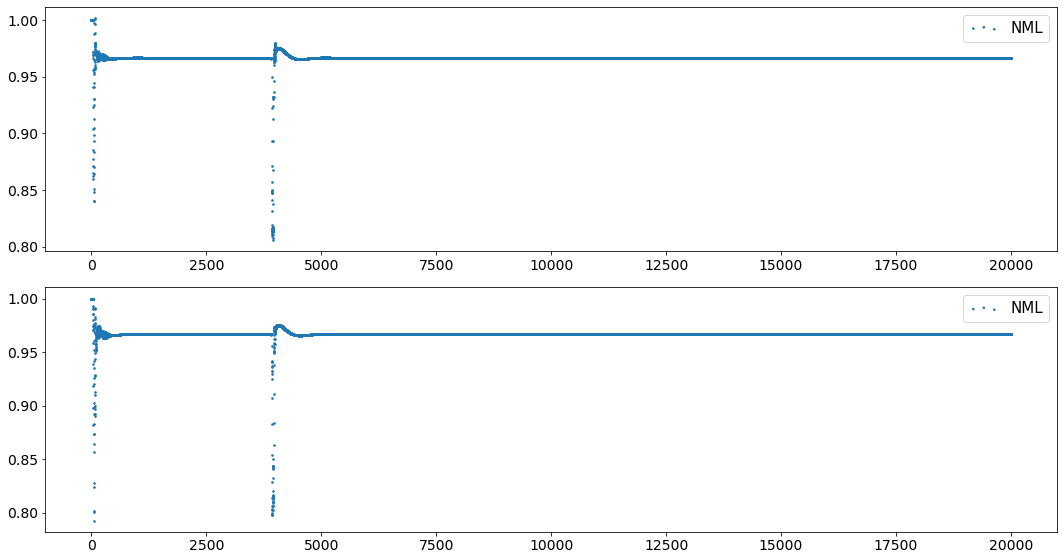


.
.
 9ABCG.csv
  Fault type Percentage
0        NML     99.56%
1      FAULT      0.44%


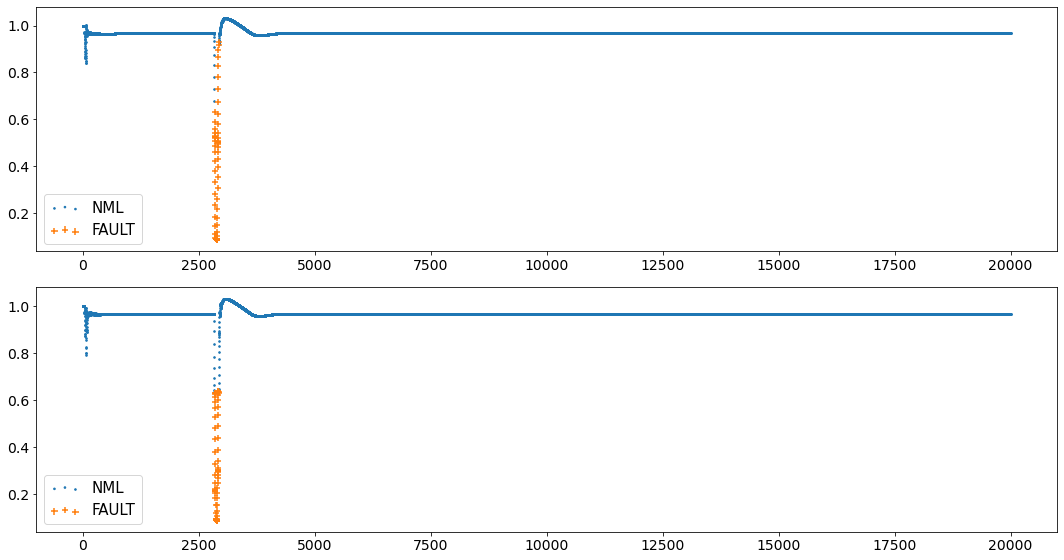

  Fault type Percentage
0       ABCG     63.64%
1        BCG     17.05%
2        ACG      7.95%
3        ABG      5.68%
4         CG      3.41%
5         BG      2.27%


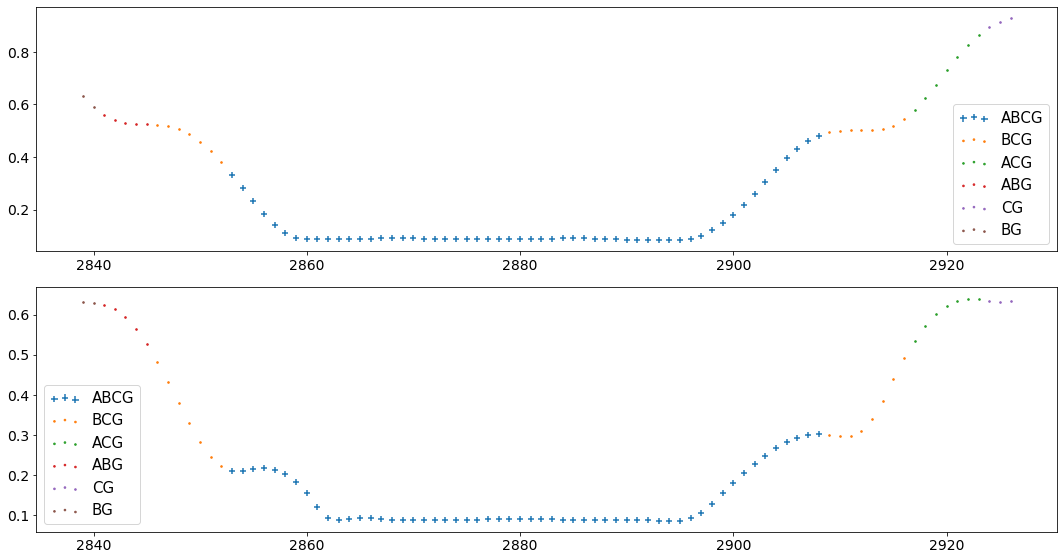


.
.
 3AB.csv
  Fault type Percentage
0        NML     53.41%
1      FAULT     46.59%


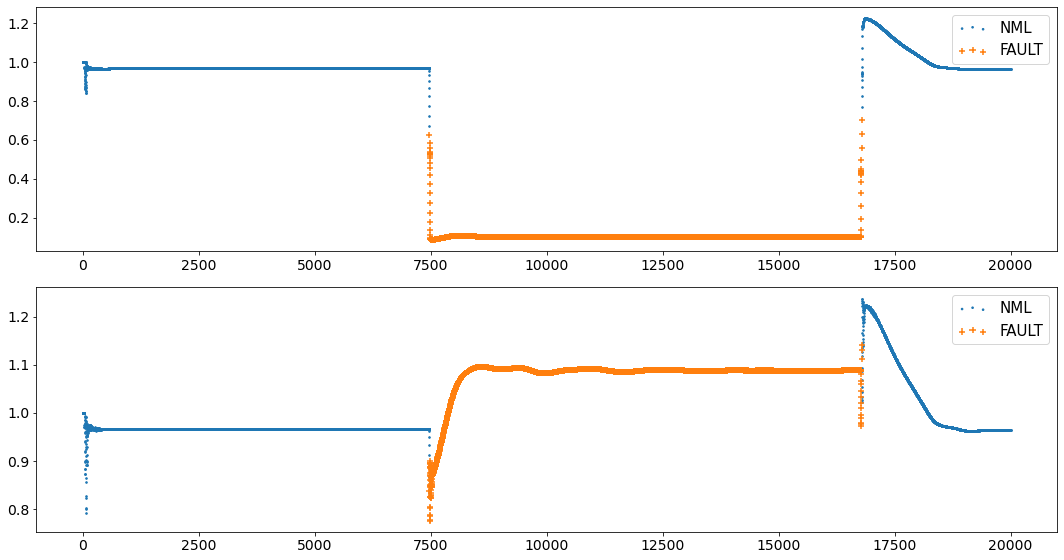

  Fault type Percentage
0         AB     99.82%
1        ABG      0.15%
2         BG      0.03%


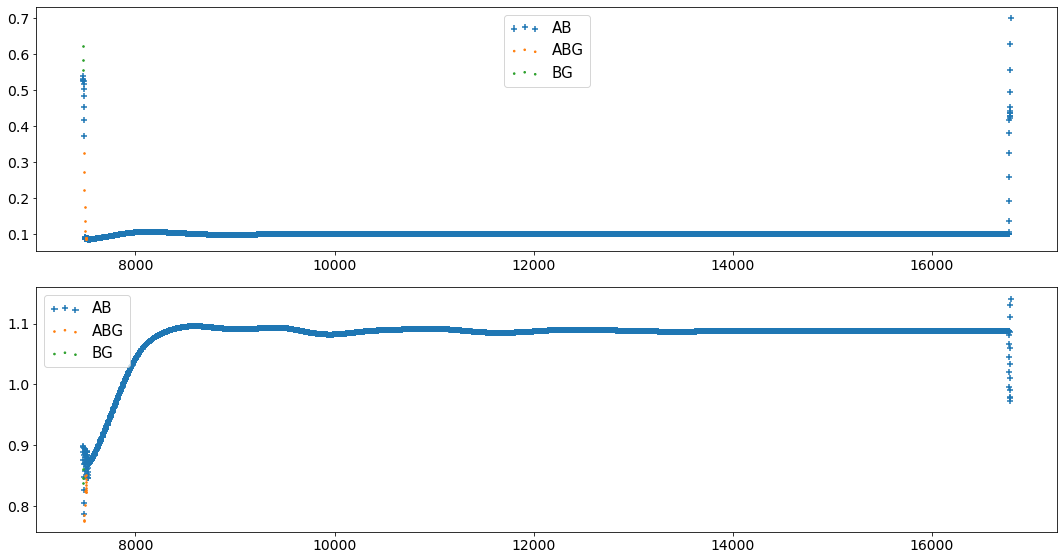


.
.
 3AC.csv
  Fault type Percentage
0        NML     71.73%
1      FAULT     28.27%


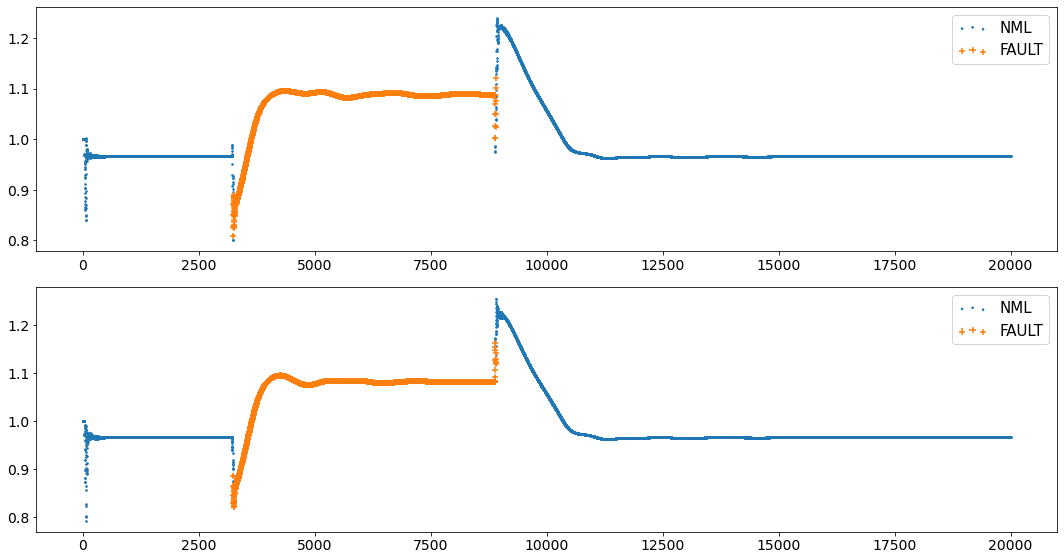

  Fault type Percentage
0         AC     99.98%
1        ACG      0.02%


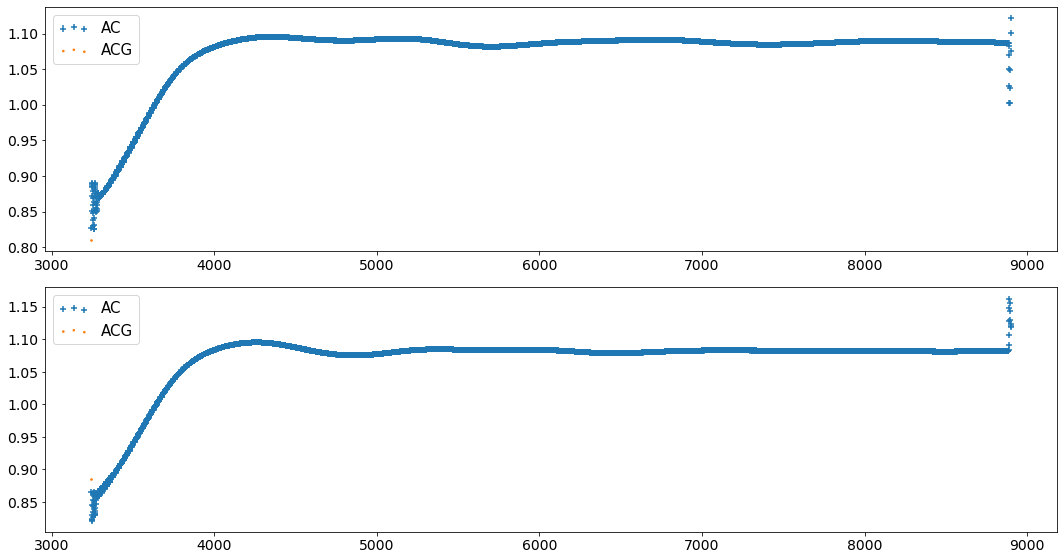


.
.
 4BCG.csv
  Fault type Percentage
0        NML      99.5%
1      FAULT       0.5%


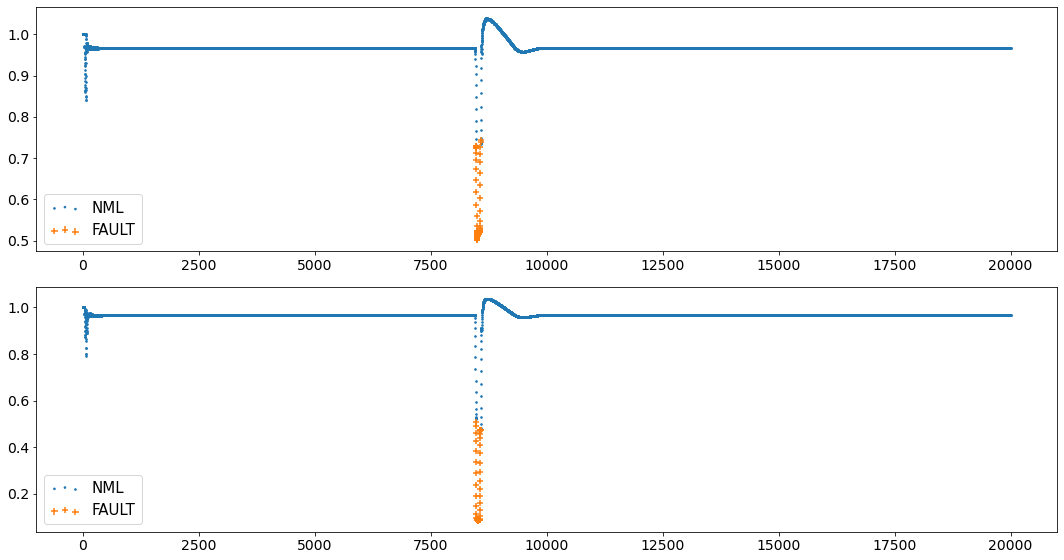

  Fault type Percentage
0        BCG     100.0%


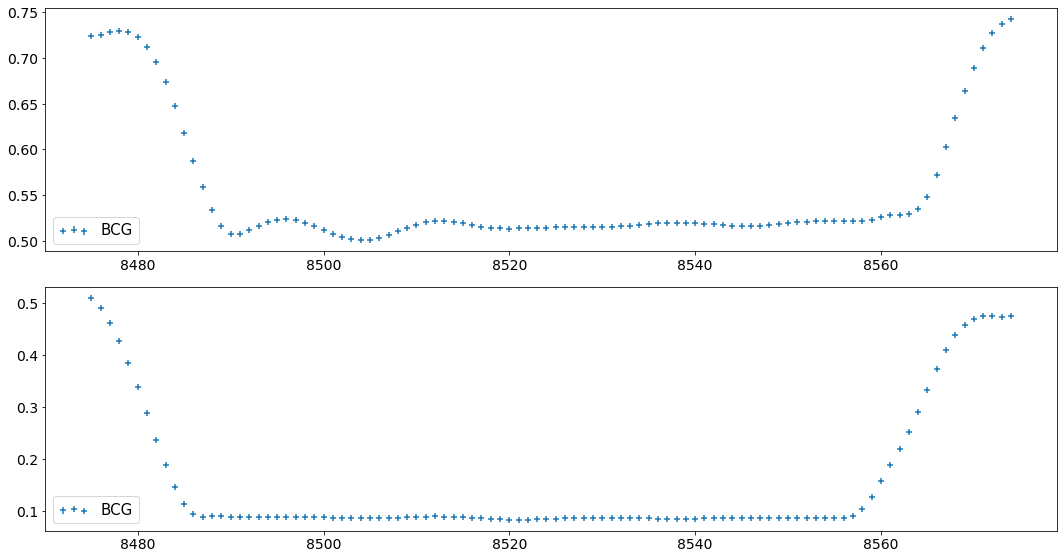


.
.
 7AG.csv
  Fault type Percentage
0        NML     88.93%
1      FAULT     11.07%


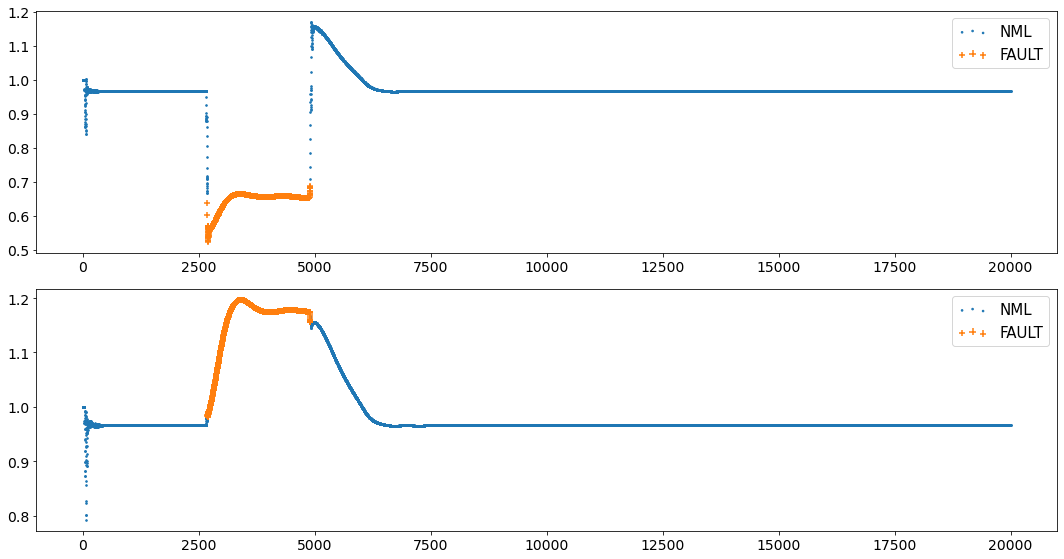

  Fault type Percentage
0         AG     100.0%


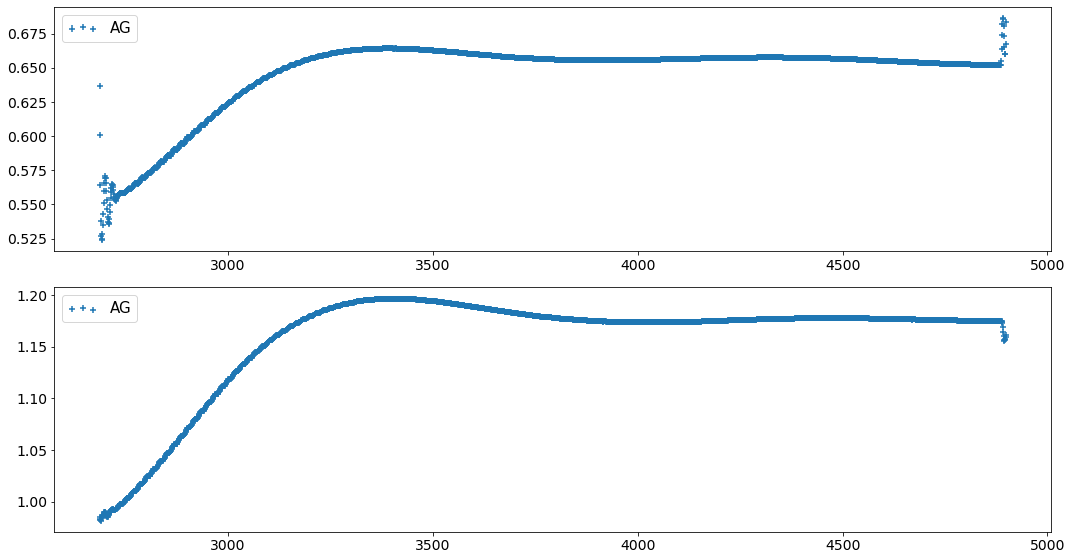


.
.
 8BCG.csv
  Fault type Percentage
0        NML     92.24%
1      FAULT      7.76%


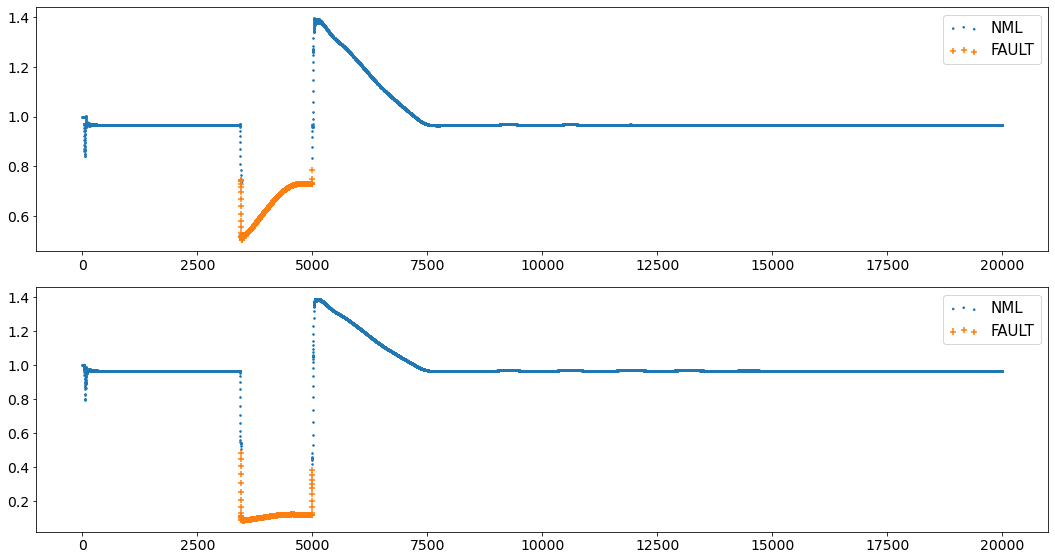

  Fault type Percentage
0        BCG     99.87%
1         BC      0.13%


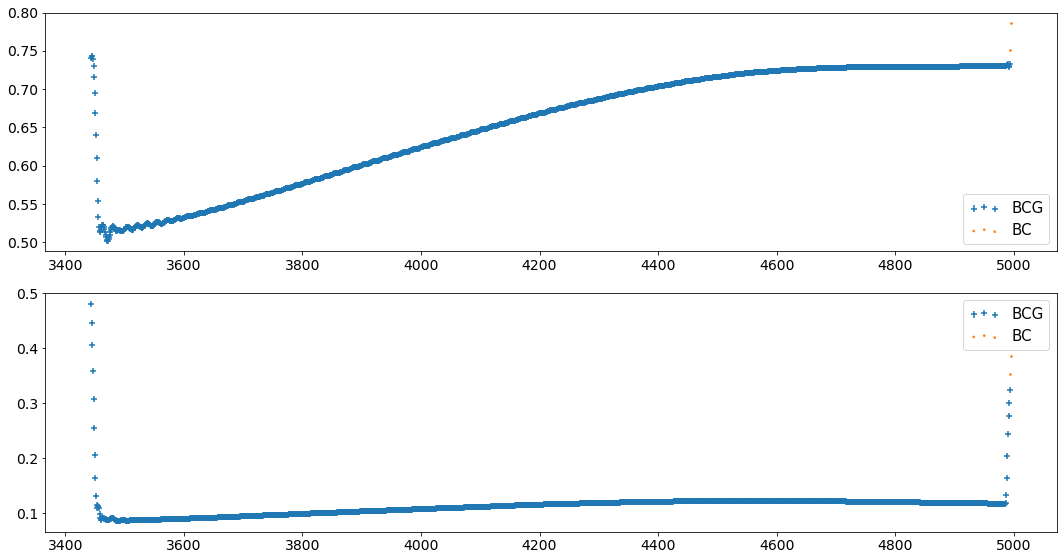

In [40]:
files_failing_the_test = []
files_passing_the_test = []

for each in file_list:
    print("\n.\n.\n",each)      
    temp = pd.read_csv('./RangeTrainingset/'+each)    
    temp = tester(binary_model,temp[temp.columns[:3]])
    plotter(temp,binary_labels_list,2)
    temp = temp[temp.label!=0]
    if temp.shape[0]>0:
        temp = tester(multi_model,temp[temp.columns[:3]])
        high = plotter(temp,multi_labels_list,2)
        if high!=0:
            if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
                files_passing_the_test.append(each)
            else:
                files_failing_the_test.append(each)


In [ ]:
print(files_passing_the_test,"....\n\n....",files_failing_the_test)

In [ ]:
names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_passing_the_test]

In [ ]:
Counter(names)

In [ ]:
temp = tester(binary_model,pd.read_csv('ml_test.csv'))
plotter(temp,binary_labels_list,2)
temp = tester(multi_model,temp[temp.label!=0])
high = plotter(temp,multi_labels_list,2)
print(high)

In [ ]:
files_failing_the_test = []
files_passing_the_test = []
for i in range(1,10):
    print("___________________________________________________________________")
    temp = tester(binary_model,pd.read_csv('./KMTrainingSet/'+str(i)+'ABC.csv'))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        checker.append(str(i)+'ABC.csv')
    else:
        checker.append('incorrect')
    print("----------------------------------------------------------------")
    

In [ ]:
files_failing_model = [str(i)+'ABC.csv' for i in range(len(checker)) if checker[i]=='incorrect']

names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_failing_model]

In [ ]:
Counter(names)

In [ ]:
data = pd.read_csv('./KMTrainingSet/1AG.csv')

In [ ]:
round(data['3V'])

In [ ]:
dat = Counter((round(data['3V'])/10))
matrics = sorted(zip([each for each in Counter(dat).keys()],Counter(dat).values() ), key=lambda x: x[0])





In [ ]:
data = pd.read_csv('KMTrainingset/2ABG.csv')

In [ ]:
features = data[data.columns[:-1]].values.tolist()
#true_labels = data['label'].values.tolist()

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [ ]:
scaled_features

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=500,
    random_state=42
)

In [ ]:
kmeans.fit(scaled_features)

In [ ]:
kmeans.cluster_centers_

In [ ]:
labels = kmeans.fit_predict(features)


In [ ]:
#data['label']=labels
data.head()

In [ ]:
dic = Counter(labels)

In [ ]:
dic

In [ ]:
if dic[1]>dic[0]:
    print("1 = 0 , 0 =1")
    data['label']=[1 if i == 0 else 0 for i in labels]
else:
    print(True)

In [ ]:
dic = Counter(data['label'])

In [ ]:
data

In [ ]:
n_plots = 6
fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))
unique_labels = ['NML','Fault']
cols = data.columns[:-1]

for j in range(6):

    
    legend_list = []
    for i in list(set(data.label)):
        
        plo = data[data.label == i]
        temp = ax[j].scatter(plo.index,plo[cols[j]],marker='+',s=40)  


        legend_list.append(temp)

    ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

fig.tight_layout()
plt.show()

In [ ]:
org = [0,1,0,1,1,1,0,0,1,0,1]
[1 if i == 0 else 0 for i in org]

In [ ]:
for x,y in zip(org,[1 if i == 0 else 0 for i in org]):
    print(x+y)